<a href="https://colab.research.google.com/github/kimjinseong-ctrl/DScover_Guide_Project_G/blob/main/G_Guide_Project_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 결측치 파악

In [ ]:
import random
import pandas as pd
import numpy as np
import os

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
building = pd.read_csv('building_info.csv')

In [ ]:
building.info() # 결측치 없음, 실수형 2개, 정수형 1개, 문자형 4개, 태양광 용량이 문자형인것은 문제

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   건물번호          100 non-null    int64  
 1   건물유형          100 non-null    object 
 2   연면적(m2)       100 non-null    float64
 3   냉방면적(m2)      100 non-null    float64
 4   태양광용량(kW)     100 non-null    object 
 5   ESS저장용량(kWh)  100 non-null    object 
 6   PCS용량(kW)     100 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ KB


In [ ]:
building = building.replace('-', np.nan)
for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
    building[col] = building[col].astype(float).fillna(0)

In [ ]:
building.head() # 태양광용량을 실수로 표현

건물번호 건물유형    연면적(m2)   냉방면적(m2)  태양광용량(kW)  ESS저장용량(kWh)  PCS용량(kW)
0     1   호텔   82912.71   77586.00       0.00           0.0        0.0
1     2   상용   40658.90   30392.82       0.00           0.0        0.0
2     3   병원  560431.00  418992.00     278.58           0.0        0.0
3     4   호텔   41813.29   23715.71       0.00           0.0        0.0
4     5   학교  403749.39  248507.00    1983.05        1025.0      250.0

In [ ]:
train = pd.merge(train, building, on='건물번호')
test = pd.merge(test, building, on='건물번호')
train.head()

num_date_time  건물번호           일시  기온(°C)  강수량(mm)  풍속(m/s)  습도(%)  일조(hr)  \
0  1_20240601 00     1  20240601 00    18.3      0.0      2.6   82.0     0.0   
1  1_20240601 01     1  20240601 01    18.3      0.0      2.7   82.0     0.0   
2  1_20240601 02     1  20240601 02    18.1      0.0      2.6   80.0     0.0   
3  1_20240601 03     1  20240601 03    18.0      0.0      2.6   81.0     0.0   
4  1_20240601 04     1  20240601 04    17.8      0.0      1.3   81.0     0.0   

   일사(MJ/m2)  전력소비량(kWh) 건물유형   연면적(m2)  냉방면적(m2)  태양광용량(kW)  ESS저장용량(kWh)  \
0        0.0     5794.80   호텔  82912.71   77586.0        0.0           0.0   
1        0.0     5591.85   호텔  82912.71   77586.0        0.0           0.0   
2        0.0     5338.17   호텔  82912.71   77586.0        0.0           0.0   
3        0.0     4554.42   호텔  82912.71   77586.0        0.0           0.0   
4        0.0     3602.25   호텔  82912.71   77586.0        0.0           0.0   

   PCS용량(kW)  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0

In [ ]:
train.info(), test.info() # 세가지 데이터셋에 결측치가 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(°C)         204000 non-null  float64
 4   강수량(mm)        204000 non-null  float64
 5   풍속(m/s)        204000 non-null  float64
 6   습도(%)          204000 non-null  float64
 7   일조(hr)         204000 non-null  float64
 8   일사(MJ/m2)      204000 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
 10  건물유형           204000 non-null  object 
 11  연면적(m2)        204000 non-null  float64
 12  냉방면적(m2)       204000 non-null  float64
 13  태양광용량(kW)      204000 non-null  float64
 14  ESS저장용량(kWh)   204000 non-null  float64
 15  PCS용량(kW)      204000 non-null  float64
dtypes: float64(12), int64(1), object(3)
memory usage: 24.9+ MB
<class 'pandas.

(None, None)

### 이상치 탐지

In [ ]:
train.columns

Index(['num_date_time', '건물번호', '일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)', '건물유형', '연면적(m2)', '냉방면적(m2)',
       '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)'],
      dtype='object')

In [ ]:
train['month'] = train['일시'].apply(lambda x : int(x[4:6]))
train['day'] = train['일시'].apply(lambda x : int(x[6:8]))
train['time'] = train['일시'].apply(lambda x : int(x[9:11]))

train.head()

num_date_time  건물번호           일시  기온(°C)  강수량(mm)  풍속(m/s)  습도(%)  일조(hr)  \
0  1_20240601 00     1  20240601 00    18.3      0.0      2.6   82.0     0.0   
1  1_20240601 01     1  20240601 01    18.3      0.0      2.7   82.0     0.0   
2  1_20240601 02     1  20240601 02    18.1      0.0      2.6   80.0     0.0   
3  1_20240601 03     1  20240601 03    18.0      0.0      2.6   81.0     0.0   
4  1_20240601 04     1  20240601 04    17.8      0.0      1.3   81.0     0.0   

   일사(MJ/m2)  전력소비량(kWh) 건물유형   연면적(m2)  냉방면적(m2)  태양광용량(kW)  ESS저장용량(kWh)  \
0        0.0     5794.80   호텔  82912.71   77586.0        0.0           0.0   
1        0.0     5591.85   호텔  82912.71   77586.0        0.0           0.0   
2        0.0     5338.17   호텔  82912.71   77586.0        0.0           0.0   
3        0.0     4554.42   호텔  82912.71   77586.0        0.0           0.0   
4        0.0     3602.25   호텔  82912.71   77586.0        0.0           0.0   

   PCS용량(kW)  month  day  time  
0        0.0      6    1     0  
1        0.0      6    1     1  
2        0.0      6    1     2  
3        0.0      6    1     3  
4        0.0      6    1     4

In [ ]:
alist = []
blist = []
clist = []

for i in range(0,204000):
    alist.append(train['month'][i])
    blist.append(train['day'][i])
    c = str(alist[i]) + '-' + str(blist[i])
    clist.append(c)

train['month-date'] = clist
train.head()

num_date_time  건물번호           일시  기온(°C)  강수량(mm)  풍속(m/s)  습도(%)  일조(hr)  \
0  1_20240601 00     1  20240601 00    18.3      0.0      2.6   82.0     0.0   
1  1_20240601 01     1  20240601 01    18.3      0.0      2.7   82.0     0.0   
2  1_20240601 02     1  20240601 02    18.1      0.0      2.6   80.0     0.0   
3  1_20240601 03     1  20240601 03    18.0      0.0      2.6   81.0     0.0   
4  1_20240601 04     1  20240601 04    17.8      0.0      1.3   81.0     0.0   

   일사(MJ/m2)  전력소비량(kWh) 건물유형   연면적(m2)  냉방면적(m2)  태양광용량(kW)  ESS저장용량(kWh)  \
0        0.0     5794.80   호텔  82912.71   77586.0        0.0           0.0   
1        0.0     5591.85   호텔  82912.71   77586.0        0.0           0.0   
2        0.0     5338.17   호텔  82912.71   77586.0        0.0           0.0   
3        0.0     4554.42   호텔  82912.71   77586.0        0.0           0.0   
4        0.0     3602.25   호텔  82912.71   77586.0        0.0           0.0   

   PCS용량(kW)  month  day  time month-date  
0        0.0      6    1     0        6-1  
1        0.0      6    1     1        6-1  
2        0.0      6    1     2        6-1  
3        0.0      6    1     3        6-1  
4        0.0      6    1     4        6-1

In [ ]:
jun = train.loc[train['month'] == 6, ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)']]
jul = train.loc[train['month'] == 7, ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)']]
aug = train.loc[train['month'] == 8, ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)']]


In [ ]:
def outliers(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = [x for x in data if x < lower_bound or x > upper_bound]
    print(f'정상 범위: {lower_bound: .2f} ~ {upper_bound: .2f}')
    return outliers

outlier_dict = {}
columns_to_check = ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)']
for col_name in columns_to_check:
    detected_outliers = outliers(jun[col_name])

    if detected_outliers:
        outlier_dict[col_name] = detected_outliers

if not outlier_dict:
    print(x)
else:
    for col, outliers in outlier_dict.items():
        outliers_rounded = [round(o, 2) for o in outliers]
        print(f"'{col}'의 이상치: {len(outliers_rounded)}")

#6월달 측정치 중 이상치 파악

정상 범위:  11.70 ~  34.90
정상 범위:  0.00 ~  0.00
정상 범위: -1.65 ~  5.15
정상 범위:  5.50 ~  129.50
'기온(°C)'의 이상치: 243
'강수량(mm)'의 이상치: 4746
'풍속(m/s)'의 이상치: 774


In [ ]:
def outliers(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = [x for x in data if x < lower_bound or x > upper_bound]
    print(f'정상 범위: {lower_bound: .2f} ~ {upper_bound: .2f}')
    return outliers

outlier_dict = {}
columns_to_check = ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)']
for col_name in columns_to_check:
    detected_outliers = outliers(jul[col_name])

    if detected_outliers:
        outlier_dict[col_name] = detected_outliers

if not outlier_dict:
    print(x)
else:
    for col, outliers in outlier_dict.items():
        outliers_rounded = [round(o, 2) for o in outliers]
        print(f"'{col}'의 이상치: {len(outliers_rounded)}")



정상 범위:  17.90 ~  34.70
정상 범위:  0.00 ~  0.00
정상 범위: -1.50 ~  5.70
정상 범위:  47.00 ~  119.00
'기온(°C)'의 이상치: 172
'강수량(mm)'의 이상치: 11251
'풍속(m/s)'의 이상치: 1868
'습도(%)'의 이상치: 253


In [ ]:
def outliers(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = [x for x in data if x < lower_bound or x > upper_bound]
    print(f'정상 범위: {lower_bound: .2f} ~ {upper_bound: .2f}')
    return outliers

outlier_dict = {}
columns_to_check = ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)']
for col_name in columns_to_check:
    detected_outliers = outliers(aug[col_name])

    if detected_outliers:
        outlier_dict[col_name] = detected_outliers

if not outlier_dict:
    print(x)
else:
    for col, outliers in outlier_dict.items():
        outliers_rounded = [round(o, 2) for o in outliers]
        print(f"'{col}'의 이상치: {len(outliers_rounded)}")



정상 범위:  20.60 ~  37.40
정상 범위:  0.00 ~  0.00
정상 범위: -1.35 ~  4.65
정상 범위:  38.50 ~  114.50
'기온(°C)'의 이상치: 11
'강수량(mm)'의 이상치: 2615
'풍속(m/s)'의 이상치: 1276
'습도(%)'의 이상치: 70


In [ ]:
import pandas as pd
import numpy as np

def find_outliers_tukey(data_series):
    """
    Pandas 시리즈를 입력받아 Tukey's HSD 방식으로 이상치를 찾습니다.
    결측치(NaN)는 자동으로 제외하고 계산합니다.
    데이터가 3개 미만인 경우, 이상치 계산이 무의미하므로 빈 리스트를 반환합니다.

    Args:
        data_series (pd.Series): 검사할 데이터 (데이터프레임의 한 열)

    Returns:
        list: 이상치로 탐지된 값들의 리스트
    """
    # 결측치를 제외한 데이터만으로 계산
    clean_data = data_series.dropna()

    if len(clean_data) < 3:
        return []

    # 1사분위수(Q1)와 3사분위수(Q3) 계산
    q1, q3 = np.percentile(clean_data, [25, 75])
    iqr = q3 - q1

    # 이상치 경계 계산 (IQR의 1.5배수 사용)
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # 경계를 벗어나는 값들을 이상치로 식별하여 리스트로 반환
    outliers = clean_data[(clean_data < lower_bound) | (clean_data > upper_bound)]
    return outliers.tolist()

# --- 1. 데이터 불러오기 ---
try:
    # train.csv 파일을 Pandas 데이터프레임으로 읽어옵니다.
    df_train = pd.read_csv('train.csv', encoding='utf-8')
except FileNotFoundError:
    print("오류: 'train.csv' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()

# --- 2. 데이터 전처리 (시간 관련) ---
# '일시' 열을 datetime 형식으로 변환합니다. 'YYYYMMDD HH' 형식에 맞춥니다.
df_train['일시'] = pd.to_datetime(df_train['일시'], format='%Y%m%d %H')

# '일시' 열에서 '월'과 '날짜' 정보를 추출하여 각각의 열을 새로 만듭니다.
df_train['월'] = df_train['일시'].dt.month
df_train['날짜'] = df_train['일시'].dt.date

# --- 3. 6월 데이터만 필터링 ---
# '월' 열의 값이 6인 데이터만 선택합니다.
# .copy()를 사용하여 SettingWithCopyWarning을 방지합니다.
df_june = df_train[df_train['월'] == 6].copy()

# --- 4. 6월 데이터에 대해 날짜별 이상치 탐지 실행 ---
# 이상치를 탐지할 대상 열 목록
columns_to_check = ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)']

# 최종 결과를 저장할 딕셔너리
outliers_by_date_june = {}

# '날짜'를 기준으로 6월 데이터프레임을 그룹화하고, 각 날짜 그룹에 대해 반복
for date, daily_group in df_june.groupby('날짜'):
    daily_outliers_found = {}  # 현재 날짜에서 발견된 이상치를 임시 저장할 딕셔너리

    # 각 날짜 그룹 내에서 검사할 열들(기온, 강수량 등)을 순회
    for col_name in columns_to_check:
        # 해당 날짜의 특정 열 데이터로 이상치 탐지 함수 호출
        detected_outliers = find_outliers_tukey(daily_group[col_name])

        # 이상치가 발견된 경우에만 결과에 추가
        if detected_outliers:
            daily_outliers_found[col_name] = detected_outliers

    # 현재 날짜에서 이상치가 하나라도 발견되었다면 최종 결과 딕셔너리에 추가
    if daily_outliers_found:
        # 날짜 객체를 'YYYY-MM-DD' 형태의 문자열로 변환하여 key로 사용
        outliers_by_date_june[date.strftime('%Y-%m-%d')] = daily_outliers_found

# --- 5. 최종 결과 출력 ---
print("--- 6월 데이터의 날짜별 기상 이상치 탐지 결과 ---")
if not outliers_by_date_june:
    print("6월 데이터에서 탐지된 이상치가 없습니다.")
else:
    # 날짜 순서대로 정렬하여 출력
    for date_str, details in sorted(outliers_by_date_june.items()):
        print(f"\n📅 날짜: {date_str}")
        for col, outliers in details.items():
            # 소수점 둘째 자리까지 반올림하여 출력
            outliers_rounded = [round(o, 2) for o in outliers]
            print(f"  - '{col}' 이상치 ({len(outliers_rounded)}개): {outliers_rounded}")


--- 6월 데이터의 날짜별 기상 이상치 탐지 결과 ---

📅 날짜: 2024-06-01
  - '강수량(mm)' 이상치 (64개): [0.1, 0.7, 0.5, 0.1, 0.7, 0.5, 0.1, 0.9, 2.8, 0.4, 0.2, 0.2, 0.5, 0.7, 0.5, 0.1, 0.7, 0.5, 0.1, 0.7, 0.5, 0.1, 0.3, 0.3, 0.7, 0.5, 0.1, 0.7, 0.5, 0.1, 0.7, 0.5, 0.1, 0.7, 0.5, 0.1, 0.7, 0.5, 0.1, 0.7, 0.5, 0.1, 0.7, 0.5, 0.1, 0.4, 0.3, 0.7, 0.5, 0.1, 0.7, 0.5, 0.1, 0.7, 0.5, 0.1, 0.7, 0.5, 0.1, 0.7, 0.5, 0.1, 0.4, 0.1]
  - '풍속(m/s)' 이상치 (10개): [5.6, 5.6, 5.6, 5.7, 5.6, 5.6, 5.6, 5.7, 5.6, 5.6]

📅 날짜: 2024-06-02
  - '강수량(mm)' 이상치 (7개): [0.1, 0.1, 3.6, 0.9, 0.6, 0.9, 0.6]

📅 날짜: 2024-06-03
  - '강수량(mm)' 이상치 (15개): [0.3, 0.2, 0.1, 0.3, 0.2, 0.3, 0.1, 0.2, 0.1, 0.1, 0.2, 3.6, 5.8, 3.6, 5.8]
  - '풍속(m/s)' 이상치 (43개): [6.0, 5.1, 5.0, 6.0, 5.1, 5.0, 6.0, 5.1, 5.0, 5.6, 5.2, 5.1, 5.4, 5.2, 6.0, 5.5, 5.0, 5.2, 6.0, 5.5, 5.0, 5.6, 6.2, 5.6, 5.2, 5.1, 5.4, 5.2, 6.0, 5.5, 5.0, 4.9, 5.2, 5.2, 6.0, 5.5, 5.0, 5.6, 6.2, 5.2, 6.0, 5.5, 5.0]

📅 날짜: 2024-06-04
  - '풍속(m/s)' 이상치 (8개): [5.0, 5.3, 6.4, 5.0, 5.3, 6.4, 5.0, 5.0]

📅 날짜:

In [ ]:
import pandas as pd
import numpy as np

def find_extreme_outliers_tukey(data_series, multiplier=3.0):
    # 결측치를 제외한 데이터만으로 계산
    clean_data = data_series.dropna()

    if len(clean_data) < 3:
        return [], np.nan, np.nan

    q1, q3 = np.percentile(clean_data, [25, 75])
    iqr = q3 - q1

    lower_bound = q1 - multiplier * iqr
    upper_bound = q3 + multiplier * iqr

    outliers = clean_data[(clean_data < lower_bound) | (clean_data > upper_bound)]
    return outliers.tolist(), lower_bound, upper_bound

df_train['일시'] = pd.to_datetime(df_train['일시'], format='%Y%m%d %H')

df_train['월'] = df_train['일시'].dt.month
df_train['날짜'] = df_train['일시'].dt.date

df_july = df_train[df_train['월'] == 7].copy()

columns_to_check = ['기온(°C)', '습도(%)']

extreme_outliers_by_date_july = {}

print("--- 7월 데이터의 날짜별 기온/습도 극단적 이상치 탐지 결과 (IQR * 3.0 기준) ---")

for date, daily_group in df_july.groupby('날짜'):
    daily_outliers_found = {}

    for col_name in columns_to_check:
        detected_outliers, lower, upper = find_extreme_outliers_tukey(daily_group[col_name])

        if detected_outliers:
            daily_outliers_found[col_name] = {
                "outliers": detected_outliers,
                "bounds": (lower, upper)
            }

    if daily_outliers_found:
        extreme_outliers_by_date_july[date.strftime('%Y-%m-%d')] = daily_outliers_found

if not extreme_outliers_by_date_july:
    print("\n분석 기간 동안 탐지된 극단적인 이상치가 없습니다.")
else:
    for date_str, details in sorted(extreme_outliers_by_date_july.items()):
        print(f"\n날짜: {date_str}")
        for col, info in details.items():
            outliers_rounded = [round(o, 2) for o in info['outliers']]
            lower_b, upper_b = info['bounds']

            print(f"  - '{col}'")
            print(f"    - 정상 데이터 범위: {lower_b:.2f} ~ {upper_b:.2f}")
            print(f"    - 극단적 이상치 ({len(outliers_rounded)}개): {outliers_rounded}")


--- 7월 데이터의 날짜별 기온/습도 극단적 이상치 탐지 결과 (IQR * 3.0 기준) ---

날짜: 2024-07-02
  - '기온(°C)'
    - 정상 데이터 범위: 16.00 ~ 30.70
    - 극단적 이상치 (5개): [30.8, 30.8, 30.8, 30.8, 30.8]

날짜: 2024-07-08
  - '습도(%)'
    - 정상 데이터 범위: 72.00 ~ 114.00
    - 극단적 이상치 (38개): [70.0, 71.0, 71.0, 69.0, 67.0, 70.0, 70.0, 71.0, 71.0, 71.0, 71.0, 65.0, 66.0, 63.0, 71.0, 69.0, 70.0, 70.0, 71.0, 71.0, 69.0, 67.0, 70.0, 70.0, 71.0, 68.0, 66.0, 65.0, 66.0, 70.0, 71.0, 71.0, 69.0, 70.0, 65.0, 66.0, 63.0, 71.0]

날짜: 2024-07-09
  - '습도(%)'
    - 정상 데이터 범위: 68.00 ~ 117.00
    - 극단적 이상치 (3개): [67.0, 65.0, 67.0]

날짜: 2024-07-29
  - '기온(°C)'
    - 정상 데이터 범위: 20.00 ~ 36.10
    - 극단적 이상치 (1개): [36.3]


In [ ]:
import pandas as pd
import numpy as np

def find_extreme_outliers_tukey(data_series, multiplier=3.0):
    # 결측치를 제외한 데이터만으로 계산
    clean_data = data_series.dropna()

    if len(clean_data) < 3:
        return [], np.nan, np.nan

    q1, q3 = np.percentile(clean_data, [25, 75])
    iqr = q3 - q1

    lower_bound = q1 - multiplier * iqr
    upper_bound = q3 + multiplier * iqr

    outliers = clean_data[(clean_data < lower_bound) | (clean_data > upper_bound)]
    return outliers.tolist(), lower_bound, upper_bound

df_train['일시'] = pd.to_datetime(df_train['일시'], format='%Y%m%d %H')

df_train['월'] = df_train['일시'].dt.month
df_train['날짜'] = df_train['일시'].dt.date

df_aug = df_train[df_train['월'] == 8].copy()

columns_to_check = ['기온(°C)', '습도(%)']

extreme_outliers_by_date_aug = {}

print("--- 8월 데이터의 날짜별 기온/습도 극단적 이상치 탐지 결과 (IQR * 3.0 기준) ---")

for date, daily_group in df_aug.groupby('날짜'):
    daily_outliers_found = {}

    for col_name in columns_to_check:
        detected_outliers, lower, upper = find_extreme_outliers_tukey(daily_group[col_name])

        if detected_outliers:
            daily_outliers_found[col_name] = {
                "outliers": detected_outliers,
                "bounds": (lower, upper)
            }

    if daily_outliers_found:
        extreme_outliers_by_date_aug[date.strftime('%Y-%m-%d')] = daily_outliers_found

if not extreme_outliers_by_date_aug:
    print("\n분석 기간 동안 탐지된 극단적인 이상치가 없습니다.")
else:
    for date_str, details in sorted(extreme_outliers_by_date_aug.items()):
        print(f"\n날짜: {date_str}")
        for col, info in details.items():
            outliers_rounded = [round(o, 2) for o in info['outliers']]
            lower_b, upper_b = info['bounds']

            print(f"  - '{col}'")
            print(f"    - 정상 데이터 범위: {lower_b:.2f} ~ {upper_b:.2f}")
            print(f"    - 극단적 이상치 ({len(outliers_rounded)}개): {outliers_rounded}")


--- 8월 데이터의 날짜별 기온/습도 극단적 이상치 탐지 결과 (IQR * 3.0 기준) ---

날짜: 2024-08-05
  - '습도(%)'
    - 정상 데이터 범위: 19.00 ~ 138.00
    - 극단적 이상치 (12개): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

날짜: 2024-08-06
  - '습도(%)'
    - 정상 데이터 범위: 12.00 ~ 145.00
    - 극단적 이상치 (1개): [0.0]

날짜: 2024-08-07
  - '습도(%)'
    - 정상 데이터 범위: 4.00 ~ 151.00
    - 극단적 이상치 (22개): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

날짜: 2024-08-08
  - '습도(%)'
    - 정상 데이터 범위: 29.00 ~ 134.00
    - 극단적 이상치 (14개): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
import pandas as pd
import numpy as np

try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()

merged_df = pd.merge(train_df, building_info_df[['건물번호', '건물유형']], on='건물번호', how='left')

merged_df['일시'] = pd.to_datetime(merged_df['일시'], format='%Y%m%d %H')

outliers_with_details = {}
print("건물별 이상치 탐지 시작 (IQR 방법 사용)...")

for building_num, group_df in merged_df.groupby('건물번호'):

    if len(group_df) < 4:
        continue

    power_series = group_df['전력소비량(kWh)']

    Q1 = power_series.quantile(0.25)
    Q3 = power_series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_series = power_series[(power_series < lower_bound) | (power_series > upper_bound)]

    if not outliers_series.empty:
        outlier_rows = group_df.loc[outliers_series.index]
        building_type = group_df['건물유형'].iloc[0]

        outliers_with_details[building_num] = {
            '건물유형': building_type,
            '정상범위': (lower_bound, upper_bound),
            '이상치_목록': outlier_rows[['일시', '전력소비량(kWh)']].to_dict('records')
        }

print("이상치 탐지 완료.")
print("\n--- 이상치 탐지 결과 (건물유형, 정상범위, 날짜 포함) ---")

if not outliers_with_details:
    print("탐지된 이상치가 없습니다.")
else:
    for building_num, details in outliers_with_details.items():
        building_type = details['건물유형']
        lower_b, upper_b = details['정상범위']
        found_outliers = details['이상치_목록']

        print(f"\n 건물번호 {building_num} (유형: {building_type})")
        print(f"  - 정상 전력소비량 범위: {lower_b:.2f} ~ {upper_b:.2f} kWh")
        print(f"  - 탐지된 이상치 ({len(found_outliers)}개):")

        for info in found_outliers:
            date_str = info['일시'].strftime('%Y-%m-%d %H:%M')
            power_val = info['전력소비량(kWh)']
            print(f"    - 날짜: {date_str}, 전력소비량: {power_val:.2f} kWh")


건물별 이상치 탐지 시작 (IQR 방법 사용)...
이상치 탐지 완료.

--- 이상치 탐지 결과 (건물유형, 정상범위, 날짜 포함) ---

 건물번호 1 (유형: 호텔)
  - 정상 전력소비량 범위: 2689.16 ~ 7995.83 kWh
  - 탐지된 이상치 (15개):
    - 날짜: 2024-06-04 05:00, 전력소비량: 2445.78 kWh
    - 날짜: 2024-06-04 06:00, 전력소비량: 2652.30 kWh
    - 날짜: 2024-06-06 05:00, 전력소비량: 2462.97 kWh
    - 날짜: 2024-06-06 06:00, 전력소비량: 2522.88 kWh
    - 날짜: 2024-06-07 06:00, 전력소비량: 2598.51 kWh
    - 날짜: 2024-06-09 06:00, 전력소비량: 2617.47 kWh
    - 날짜: 2024-06-17 04:00, 전력소비량: 2393.88 kWh
    - 날짜: 2024-07-07 04:00, 전력소비량: 1870.44 kWh
    - 날짜: 2024-07-15 05:00, 전력소비량: 2577.78 kWh
    - 날짜: 2024-08-03 12:00, 전력소비량: 8023.92 kWh
    - 날짜: 2024-08-03 13:00, 전력소비량: 8083.50 kWh
    - 날짜: 2024-08-03 14:00, 전력소비량: 8097.24 kWh
    - 날짜: 2024-08-03 17:00, 전력소비량: 8008.71 kWh
    - 날짜: 2024-08-12 04:00, 전력소비량: 2580.27 kWh
    - 날짜: 2024-08-23 04:00, 전력소비량: 2286.45 kWh

 건물번호 2 (유형: 상용)
  - 정상 전력소비량 범위: 194.72 ~ 3043.76 kWh
  - 탐지된 이상치 (8개):
    - 날짜: 2024-07-04 21:00, 전력소비량: 3139.08 kWh
    - 날짜: 2024-07-1

In [ ]:
import pandas as pd
import numpy as np

# --- 1. 데이터 불러오기 및 병합, 전처리 ---
try:
    # 필요한 CSV 파일들을 Pandas 데이터프레임으로 읽어옵니다.
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()

# '건물번호'를 기준으로 train 데이터와 building_info 데이터를 병합합니다.
merged_df = pd.merge(train_df, building_info_df[['건물번호', '건물유형']], on='건물번호', how='left')

# '일시' 열을 datetime 형식으로 변환하고, '시간' 열을 새로 생성합니다.
merged_df['일시'] = pd.to_datetime(merged_df['일시'], format='%Y%m%d %H')
merged_df['시간'] = merged_df['일시'].dt.hour

# --- 2. 건물번호 및 시간대별로 이상치 탐지 ---
# 최종 결과를 저장할 딕셔너리
outliers_by_building_hour = {}
print("건물별 및 시간대별 이상치 탐지를 시작합니다...")

# *** 핵심 수정 사항: '건물번호'와 '시간'으로 이중 그룹화 ***
# (building_num, hour): 그룹의 키 (예: (1, 0), (1, 1), ...)
# group_df: 특정 건물의 특정 시간에 해당하는 모든 데이터 (예: 1번 건물의 모든 0시 데이터)
for (building_num, hour), group_df in merged_df.groupby(['건물번호', '시간']):

    # 해당 시간대의 데이터가 너무 적으면 (4개 미만) 통계적 의미가 없으므로 건너뜁니다.
    if len(group_df) < 4:
        continue

    power_series = group_df['전력소비량(kWh)']

    # 1사분위수(Q1)와 3사분위수(Q3) 계산
    Q1 = power_series.quantile(0.25)
    Q3 = power_series.quantile(0.75)
    IQR = Q3 - Q1

    # 이상치 경계 계산
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    # 경계를 벗어나는 이상치를 찾습니다.
    outliers_series = power_series[(power_series < lower_bound) | (power_series > upper_bound)]

    # 식별된 이상치가 있는 경우
    if not outliers_series.empty:
        # 건물번호가 결과 딕셔너리에 없으면 새로 생성
        if building_num not in outliers_by_building_hour:
            outliers_by_building_hour[building_num] = {
                '건물유형': group_df['건물유형'].iloc[0],
                '시간대별_이상치': []
            }

        # 현재 시간대에서 찾은 이상치 정보를 리스트에 추가
        outlier_rows = group_df.loc[outliers_series.index]
        outlier_info_for_hour = {
            '시간': hour,
            '정상범위': (lower_bound, upper_bound),
            '이상치_목록': outlier_rows[['일시', '전력소비량(kWh)']].to_dict('records')
        }
        outliers_by_building_hour[building_num]['시간대별_이상치'].append(outlier_info_for_hour)

print("이상치 탐지 완료.")

# --- 3. 최종 결과 출력 ---
print("\n--- 건물별 및 시간대별 이상치 탐지 결과 ---")

if not outliers_by_building_hour:
    print("탐지된 이상치가 없습니다.")
else:
    # 이상치가 탐지된 건물들을 순회하며 출력
    for building_num, details in outliers_by_building_hour.items():
        building_type = details['건물유형']
        hourly_outliers = details['시간대별_이상치']

        print(f"\n🏢 건물번호 {building_num} (유형: {building_type})")

        # 해당 건물의 시간대별 이상치 목록을 순회하며 출력
        for info in hourly_outliers:
            hour = info['시간']
            lower_b, upper_b = info['정상범위']
            found_outliers = info['이상치_목록']

            print(f"  🕒 {hour:02d}시의 이상치 ({len(found_outliers)}개)")
            print(f"    - {hour:02d}시의 정상 범위: {lower_b:.2f} ~ {upper_b:.2f} kWh")

            for outlier_data in found_outliers:
                date_str = outlier_data['일시'].strftime('%Y-%m-%d %H:%M')
                power_val = outlier_data['전력소비량(kWh)']
                print(f"      - 날짜: {date_str}, 전력소비량: {power_val:.2f} kWh")


건물별 및 시간대별 이상치 탐지를 시작합니다...
이상치 탐지 완료.

--- 건물별 및 시간대별 이상치 탐지 결과 ---

🏢 건물번호 2 (유형: 상용)
  🕒 17시의 이상치 (2개)
    - 17시의 정상 범위: 1035.48 ~ 2939.34 kWh
      - 날짜: 2024-06-01 17:00, 전력소비량: 966.12 kWh
      - 날짜: 2024-06-08 17:00, 전력소비량: 918.84 kWh

🏢 건물번호 5 (유형: 학교)
  🕒 07시의 이상치 (1개)
    - 07시의 정상 범위: 2185.92 ~ 5475.36 kWh
      - 날짜: 2024-08-04 07:00, 전력소비량: 1559.04 kWh

🏢 건물번호 6 (유형: 상용)
  🕒 00시의 이상치 (7개)
    - 00시의 정상 범위: 709.44 ~ 2500.32 kWh
      - 날짜: 2024-08-07 00:00, 전력소비량: 2670.24 kWh
      - 날짜: 2024-08-15 00:00, 전력소비량: 2666.40 kWh
      - 날짜: 2024-08-17 00:00, 전력소비량: 2504.16 kWh
      - 날짜: 2024-08-18 00:00, 전력소비량: 2678.40 kWh
      - 날짜: 2024-08-19 00:00, 전력소비량: 2625.60 kWh
      - 날짜: 2024-08-20 00:00, 전력소비량: 2937.12 kWh
      - 날짜: 2024-08-21 00:00, 전력소비량: 2551.68 kWh
  🕒 01시의 이상치 (6개)
    - 01시의 정상 범위: 588.00 ~ 2422.56 kWh
      - 날짜: 2024-08-15 01:00, 전력소비량: 2554.56 kWh
      - 날짜: 2024-08-16 01:00, 전력소비량: 2549.28 kWh
      - 날짜: 2024-08-18 01:00, 전력소비량: 2496.96 kWh
      - 날

### 시각화 할 것들

월별 자료
월 > 일별자료
시간별 자료

필요한 독립변수 조회
히트맵
날짜별 기온 그래프
체감온도 관련


In [ ]:
grp = train.groupby(['건물번호', '건물유형'])['습도(%)'].mean()
grp.value_counts() # 건물별로 기온 평균이 다르다, 습도 평균도 다르다 > 그러면 여기서 습도는 상대습도
# 체감온도 공식 사용 가능

습도(%)
75.330392    17
71.815196    16
72.286275     7
79.297549     6
78.663725     6
68.314706     5
80.889706     4
78.043627     4
84.905392     3
79.070098     3
81.380392     3
70.458333     2
75.777941     2
66.257843     2
74.331373     2
80.346569     2
73.378922     2
75.417647     2
68.848529     1
68.799020     1
69.163725     1
81.164216     1
75.494608     1
70.227941     1
70.987255     1
76.029412     1
78.307353     1
78.083824     1
74.175000     1
80.646569     1
Name: count, dtype: int64

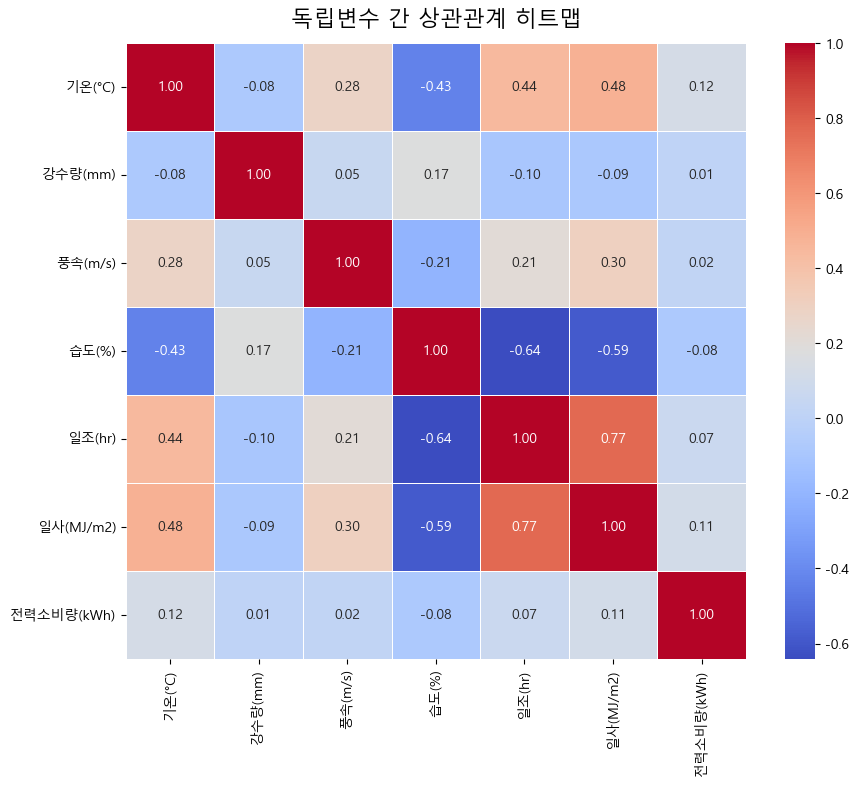

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

try:
    plt.rc('font', family='Malgun Gothic')
    plt.rcParams['axes.unicode_minus'] = False
except:
    print("Malgun Gothic 폰트를 찾을 수 없습니다. 다른 한글 폰트를 설정해주세요.")

numeric_columns = ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)']
df_for_corr = train_df[numeric_columns]

correlation_matrix = df_for_corr.corr()

plt.figure(figsize=(10, 8))

heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
heatmap.set_title('독립변수 간 상관관계 히트맵', fontsize=16, pad=12)
plt.savefig('heatmap.png')
plt.show()

'월별_데이터_변화_6월.png' 파일이 저장되었습니다.


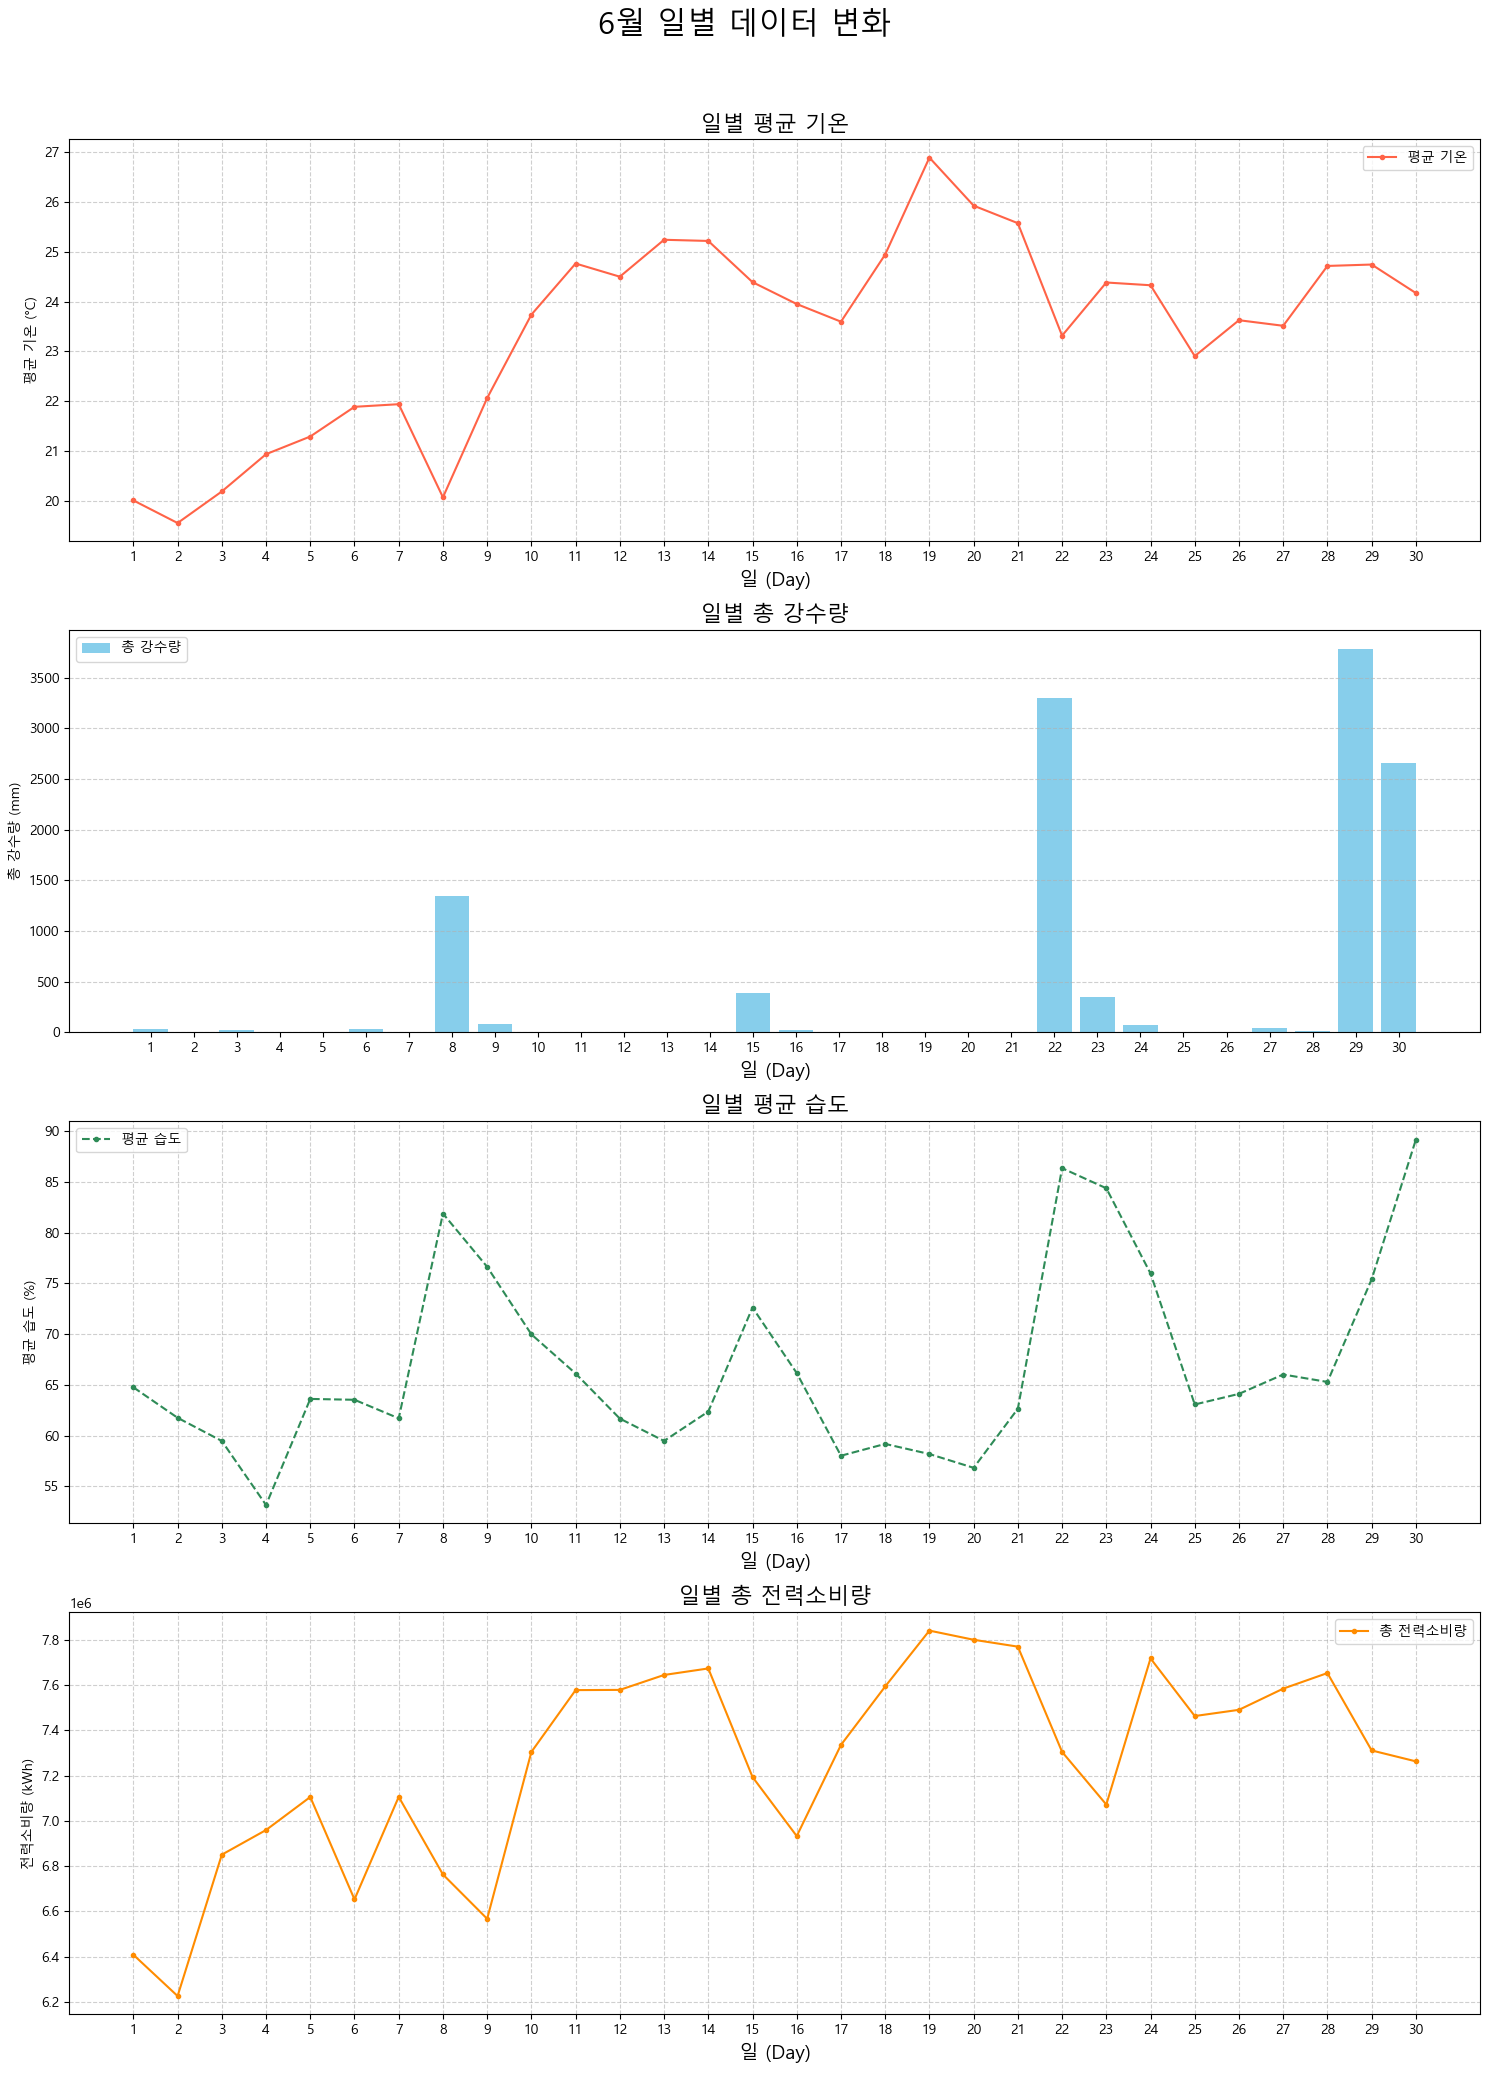

'월별_데이터_변화_7월.png' 파일이 저장되었습니다.


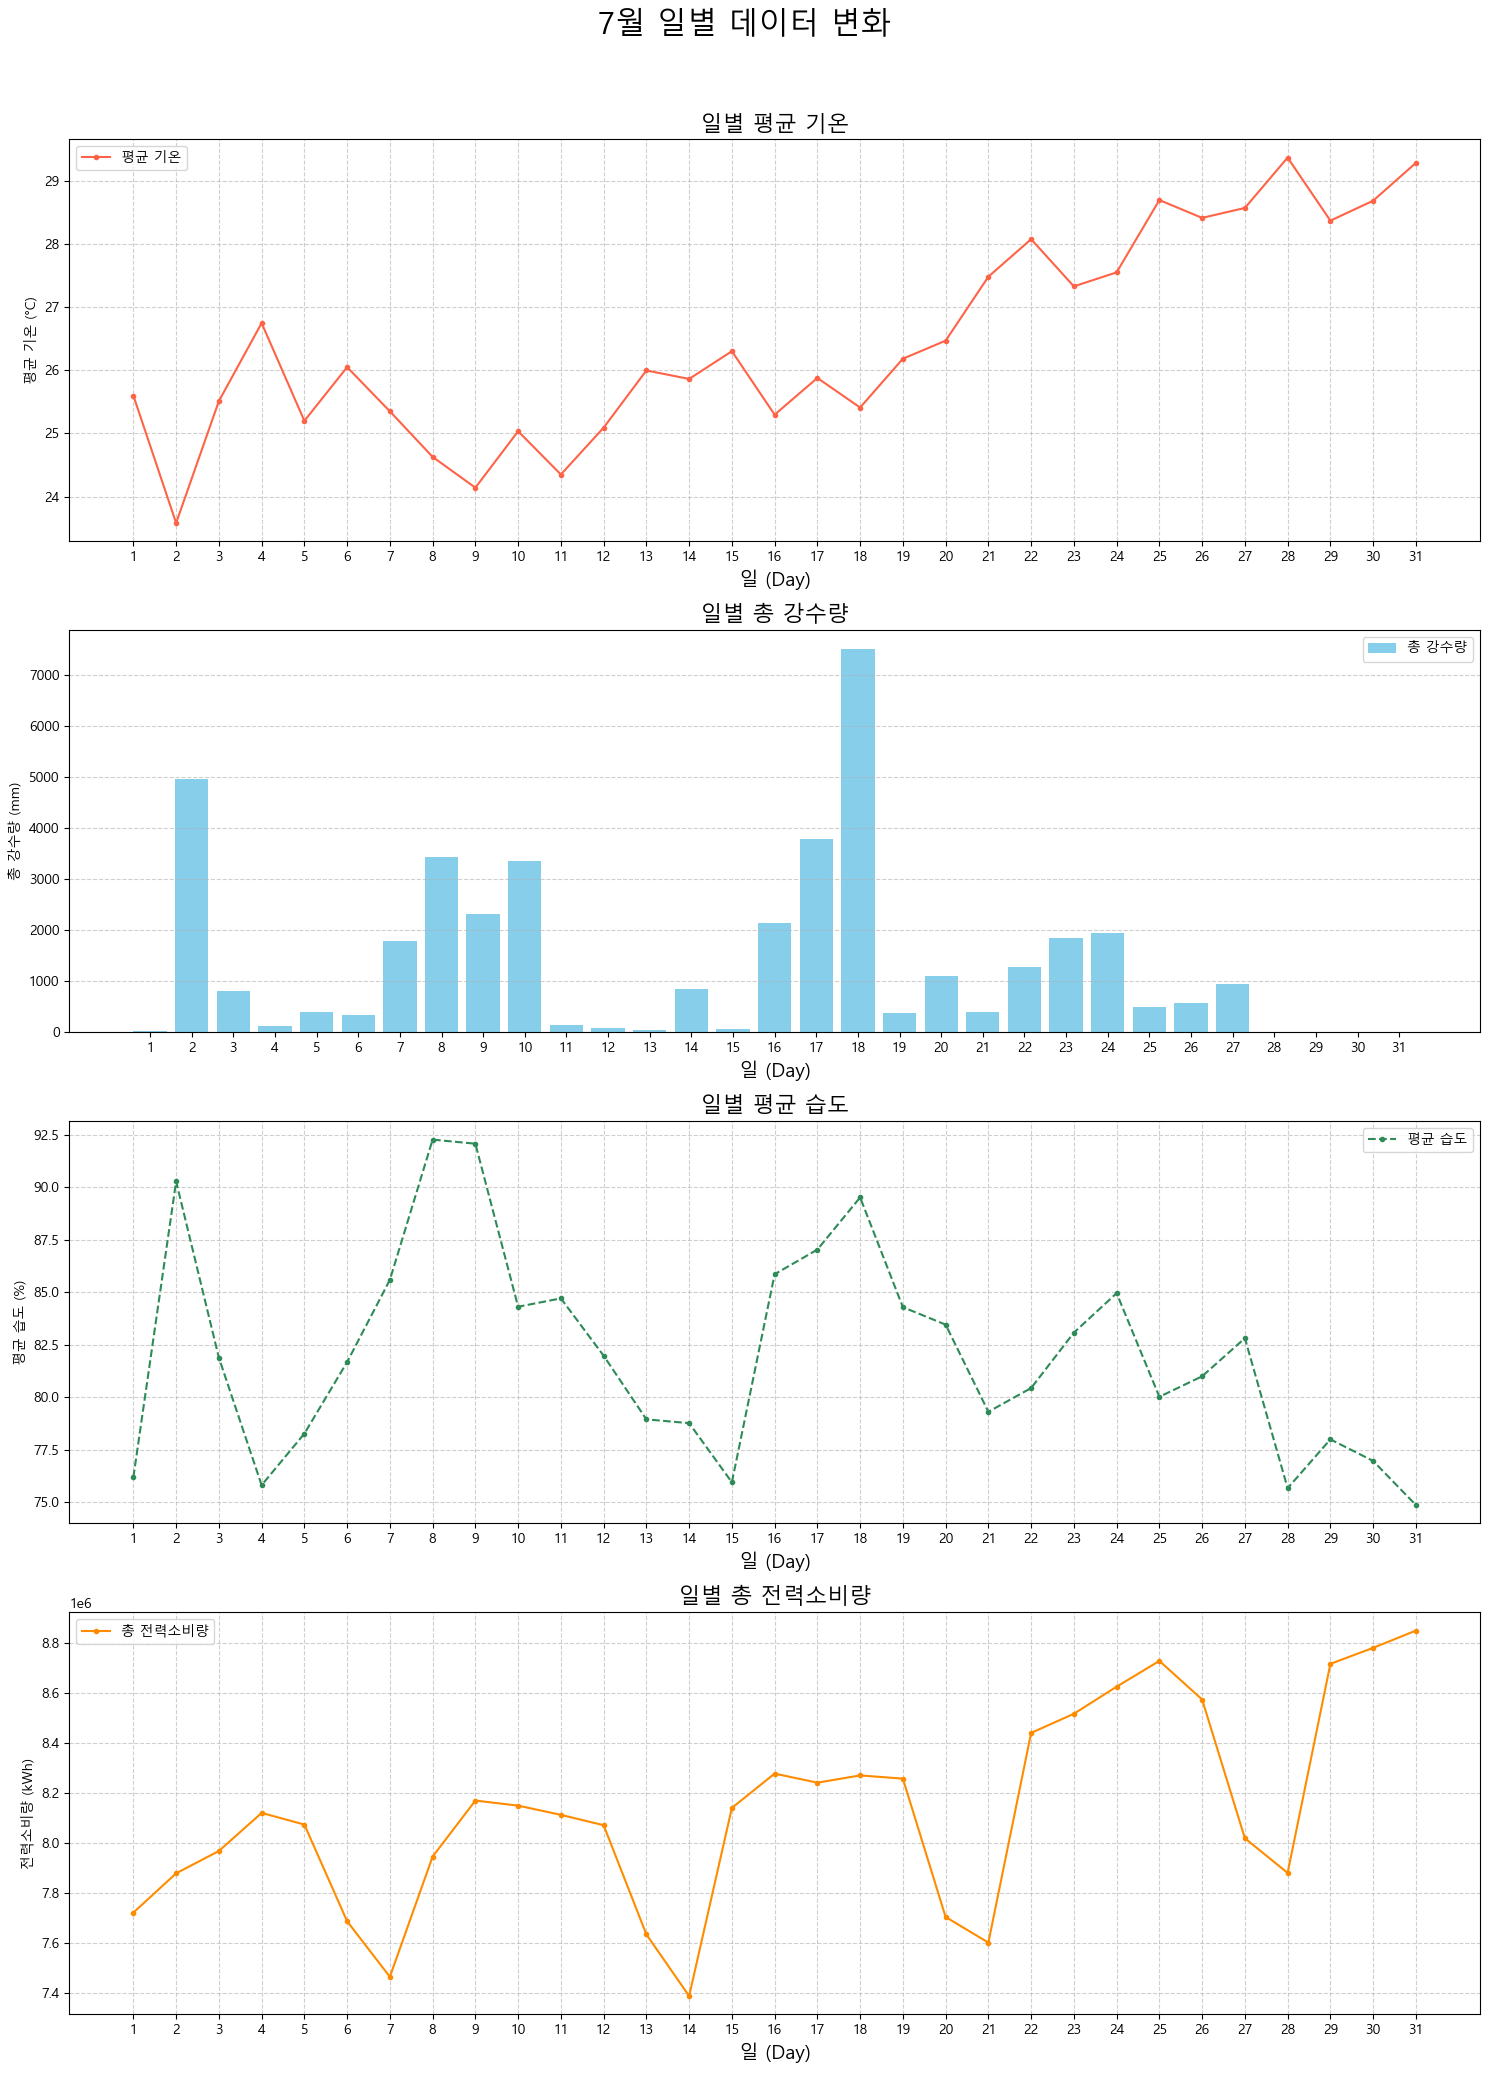

'월별_데이터_변화_8월.png' 파일이 저장되었습니다.


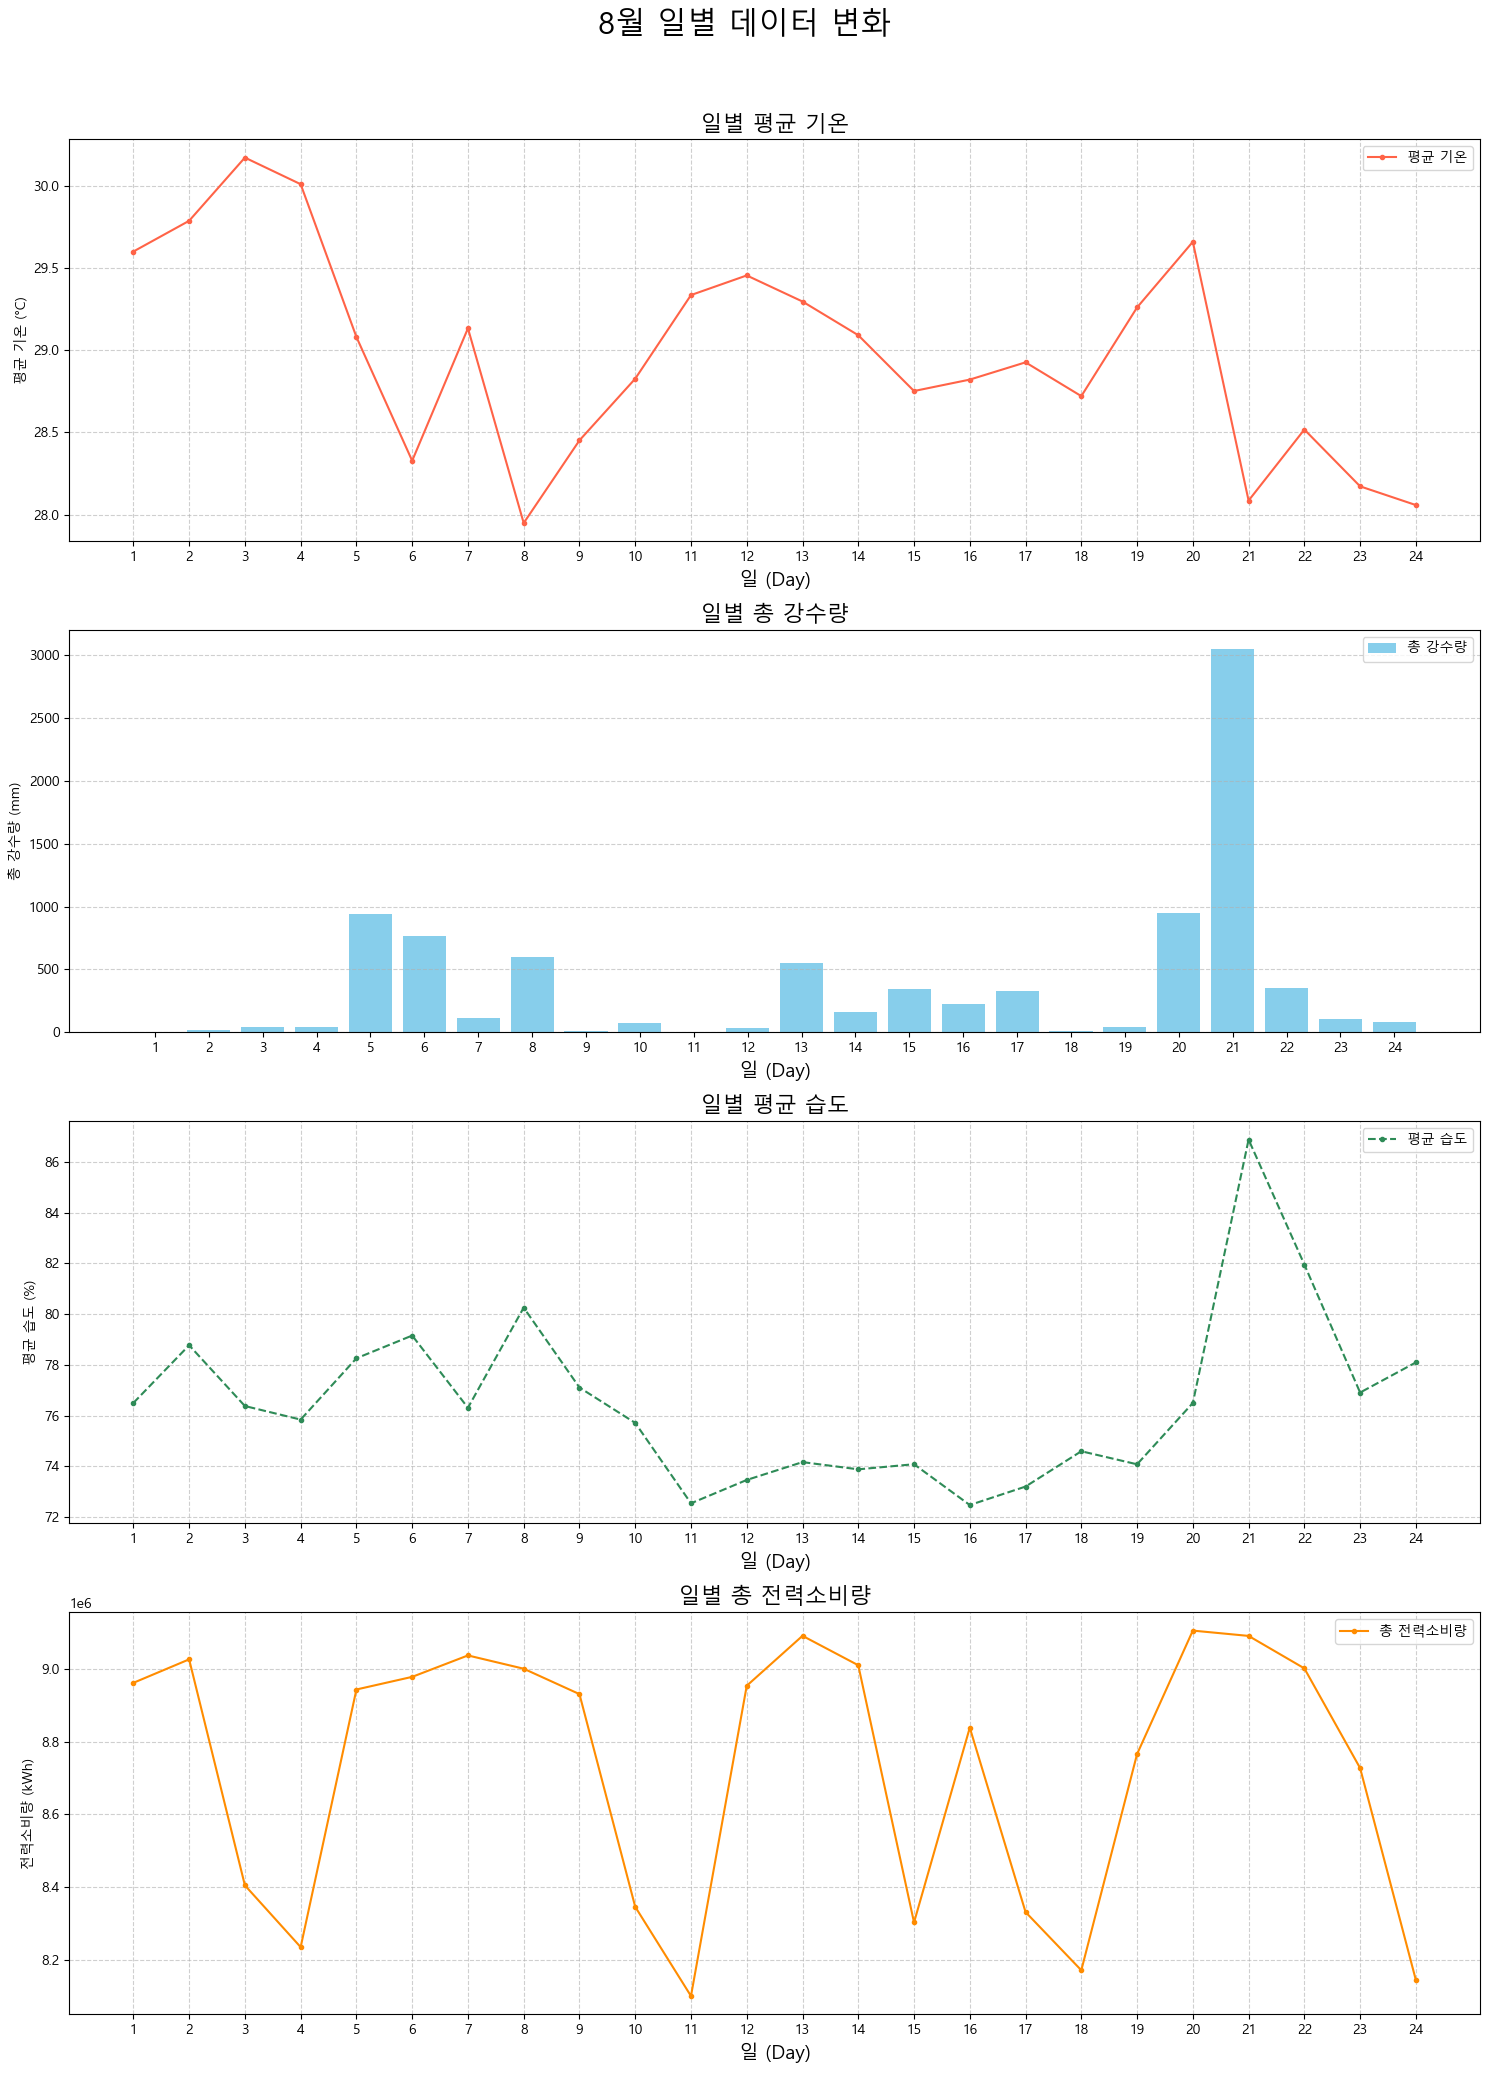


모든 그래프 생성이 완료되었습니다.
'월별_데이터_변화_8월.png' 파일이 저장되었습니다.


<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# --- 1. 한글 폰트 설정 ---
# 시스템에 설치된 한글 폰트를 지정합니다. (Windows: Malgun Gothic, macOS: AppleGothic)
try:
    plt.rc('font', family='Malgun Gothic')
    plt.rcParams['axes.unicode_minus'] = False
except:
    print("Malgun Gothic 폰트를 찾을 수 없습니다. 다른 한글 폰트를 설정해주세요.")

# --- 2. 데이터 불러오기 및 전처리 ---
try:
    # train.csv 파일을 Pandas 데이터프레임으로 읽어옵니다.
    train_df = pd.read_csv('train.csv', encoding='utf-8')
except FileNotFoundError:
    print("오류: 'train.csv' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()

train_df['일시'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')

train_df['월'] = train_df['일시'].dt.month
train_df['일'] = train_df['일시'].dt.day
train_df['일자'] = train_df['일시'].dt.date

daily_stats = train_df.groupby('일자').agg({
    '월': 'first',
    '일': 'first',
    '기온(°C)': 'mean',
    '강수량(mm)': 'sum',
    '습도(%)': 'mean',
    '전력소비량(kWh)': 'sum'
}).reset_index()

# --- 3. 월별 시각화 및 파일 저장 ---
for month in [6, 7, 8]:
    month_df = daily_stats[daily_stats['월'] == month]

    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 22))

    fig.suptitle(f'{month}월 일별 데이터 변화', fontsize=22, y=0.97)

    axes[0].plot(month_df['일'], month_df['기온(°C)'], marker='.', linestyle='-', color='tomato', label='평균 기온')
    axes[0].set_title('일별 평균 기온', fontsize=16)
    axes[0].set_ylabel('평균 기온 (°C)')
    axes[0].set_xlabel('일 (Day)', fontsize=14)
    axes[0].grid(True, linestyle='--', alpha=0.6)
    axes[0].legend()

    axes[1].bar(month_df['일'], month_df['강수량(mm)'], color='skyblue', label='총 강수량')
    axes[1].set_title('일별 총 강수량', fontsize=16)
    axes[1].set_ylabel('총 강수량 (mm)')
    axes[1].set_xlabel('일 (Day)', fontsize=14)
    axes[1].grid(True, axis='y', linestyle='--', alpha=0.6)
    axes[1].legend()

    axes[2].plot(month_df['일'], month_df['습도(%)'], marker='.', linestyle='--', color='seagreen', label='평균 습도')
    axes[2].set_title('일별 평균 습도', fontsize=16)
    axes[2].set_ylabel('평균 습도 (%)')
    axes[2].set_xlabel('일 (Day)', fontsize=14)
    axes[2].grid(True, linestyle='--', alpha=0.6)
    axes[2].legend()

    axes[3].plot(month_df['일'], month_df['전력소비량(kWh)'], marker='.', linestyle='-', color='darkorange', label='총 전력소비량')
    axes[3].set_title('일별 총 전력소비량', fontsize=16)
    axes[3].set_ylabel('전력소비량 (kWh)')
    axes[3].set_xlabel('일 (Day)', fontsize=14)
    axes[3].grid(True, linestyle='--', alpha=0.6)
    axes[3].legend()

    for ax in axes:
        ax.set_xticks(month_df['일'])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # --- ★★★ 핵심 수정 사항 ★★★ ---
    # f-string을 사용하여 각 월별로 고유한 파일 이름을 생성합니다.
    # dpi=300 옵션은 이미지의 해상도를 높여줍니다.
    file_name = f'월별_데이터_변화_{month}월.png'
    plt.savefig(file_name, dpi=300)
    print(f"'{file_name}' 파일이 저장되었습니다.")

    # 그래프를 화면에도 표시합니다.
    plt.show()

print("\n모든 그래프 생성이 완료되었습니다.")

# f-string을 사용하여 각 월별로 고유한 파일 이름을 생성합니다.
# dpi=300 옵션은 이미지의 해상도를 높여줍니다.
file_name = f'월별_데이터_변화_{month}월.png'
plt.savefig(file_name, dpi=300)
print(f"'{file_name}' 파일이 저장되었습니다.")


'시간대별_데이터_패턴.png' 파일이 성공적으로 저장되었습니다.


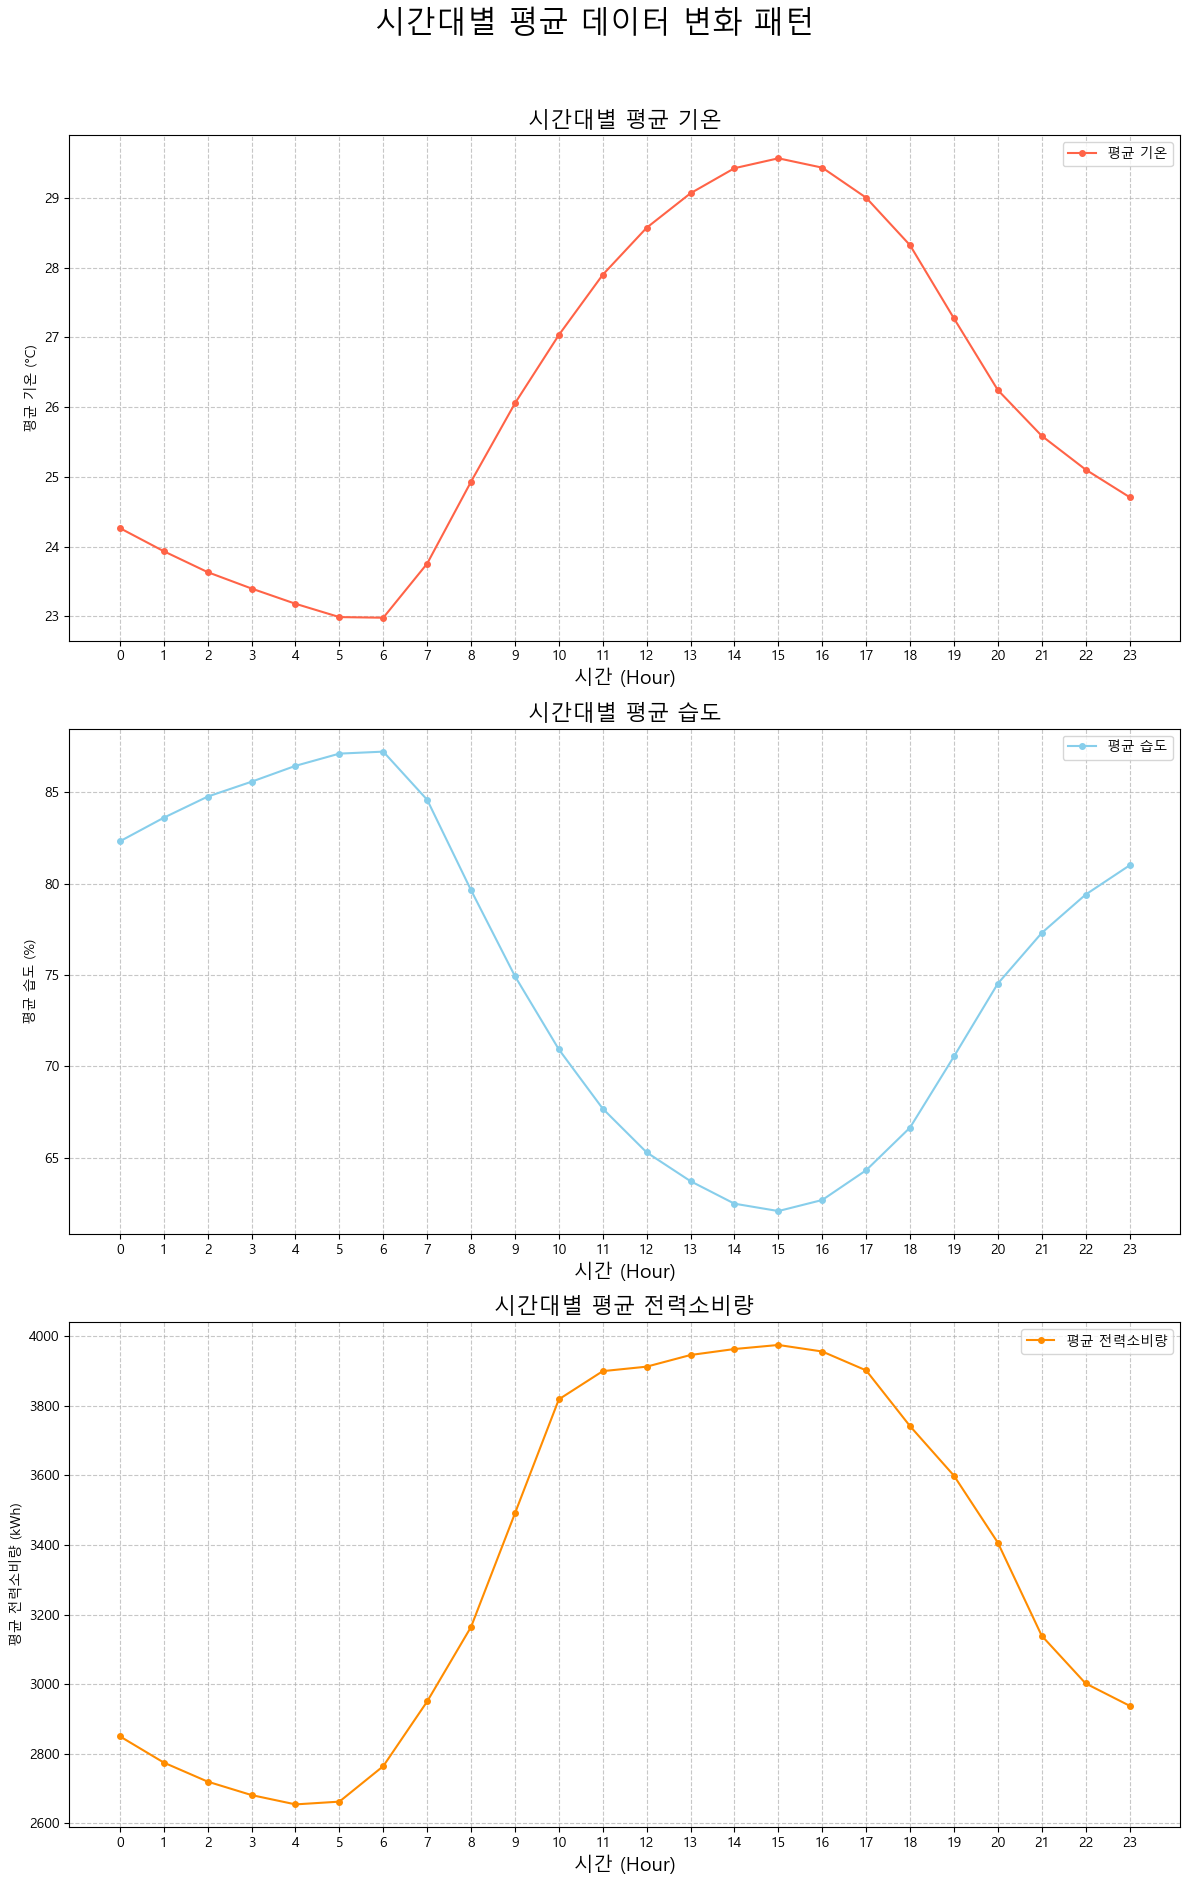

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# --- 1. 한글 폰트 설정 ---
# 시스템에 설치된 한글 폰트를 지정합니다. (Windows: Malgun Gothic, macOS: AppleGothic)
try:
    plt.rc('font', family='Malgun Gothic')
    plt.rcParams['axes.unicode_minus'] = False
except:
    print("Malgun Gothic 폰트를 찾을 수 없습니다. 다른 한글 폰트를 설정해주세요.")

# --- 2. 데이터 불러오기 및 전처리 ---
try:
    # train.csv 파일을 Pandas 데이터프레임으로 읽어옵니다.
    train_df = pd.read_csv('train.csv', encoding='utf-8')
except FileNotFoundError:
    print("오류: 'train.csv' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()

train_df['일시'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')

# '일시' 열에서 '시간' 정보만 추출하여 새로운 열을 만듭니다. (0 ~ 23시)
train_df['시간'] = train_df['일시'].dt.hour

# --- 3. 시간대별 데이터 집계 ---
# '시간'을 기준으로 그룹화하여 각 변수의 시간대별 평균을 계산합니다.
hourly_stats = train_df.groupby('시간').agg({
    '기온(°C)': 'mean',
    '습도(%)': 'mean',
    '전력소비량(kWh)': 'mean'
}).reset_index()

# --- 4. Subplot으로 시각화 ---
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 20))

fig.suptitle('시간대별 평균 데이터 변화 패턴', fontsize=22, y=0.97)

axes[0].plot(hourly_stats['시간'], hourly_stats['기온(°C)'], marker='o', markersize=4, linestyle='-', color='tomato', label='평균 기온')
axes[0].set_title('시간대별 평균 기온', fontsize=16)
axes[0].set_ylabel('평균 기온 (°C)')
axes[0].set_xlabel('시간 (Hour)', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend()

axes[1].plot(hourly_stats['시간'], hourly_stats['습도(%)'], marker='o', markersize=4, linestyle='-', color='skyblue', label='평균 습도')
axes[1].set_title('시간대별 평균 습도', fontsize=16)
axes[1].set_ylabel('평균 습도 (%)')
axes[1].set_xlabel('시간 (Hour)', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend()

axes[2].plot(hourly_stats['시간'], hourly_stats['전력소비량(kWh)'], marker='o', markersize=4, linestyle='-', color='darkorange', label='평균 전력소비량')
axes[2].set_title('시간대별 평균 전력소비량', fontsize=16)
axes[2].set_ylabel('평균 전력소비량 (kWh)')
axes[2].set_xlabel('시간 (Hour)', fontsize=14)
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].legend()

for ax in axes:
    ax.set_xticks(hourly_stats['시간'])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# --- 5. 그래프 파일로 저장 ---
# 생성된 그래프를 png 파일로 저장합니다. dpi 옵션으로 해상도를 높일 수 있습니다.
file_name = '시간대별_데이터_패턴.png'
plt.savefig(file_name, dpi=300)
print(f"'{file_name}' 파일이 성공적으로 저장되었습니다.")

# 그래프를 화면에도 표시합니다.
plt.show()



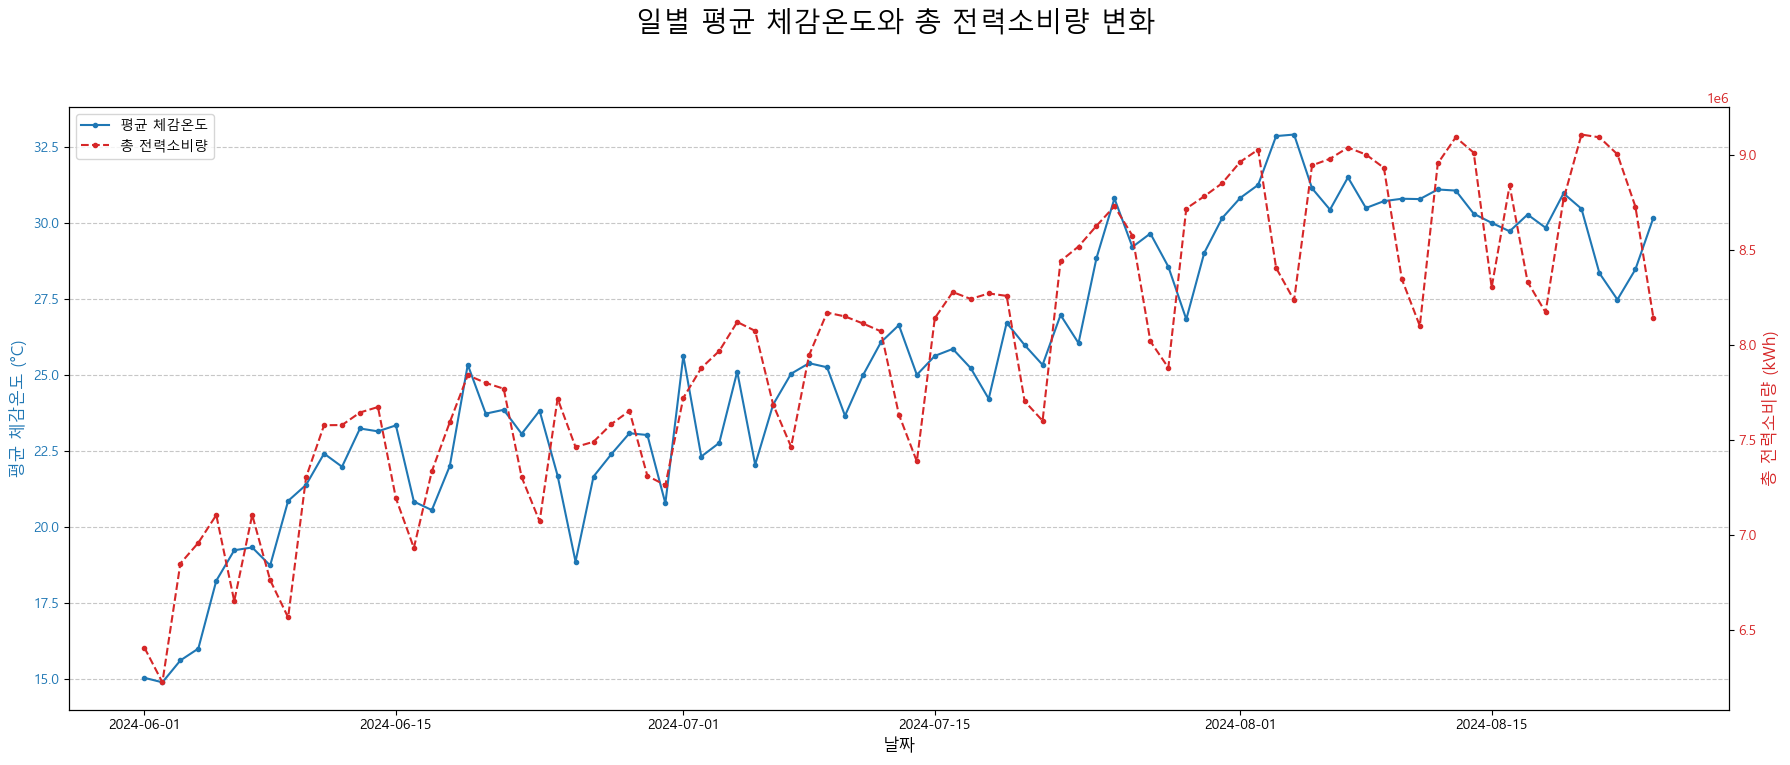

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def calculate_apparent_temp(temp, humidity, wind_speed):

    # 수증기압(e) 계산 (hPa)
    # rh(%) / 100 * 6.105 * exp(17.27 * T / (237.7 + T))
    e = (humidity / 100) * 6.105 * np.exp((17.27 * temp) / (237.7 + temp))

    # 체감온도(AT) 계산
    # AT = Ta + 0.33*e - 0.70*ws - 4.00 (ws는 km/h 기준, 여기서는 m/s를 변환)
    wind_speed_kmh = wind_speed * 3.6
    apparent_temp = temp + 0.33 * e - 0.70 * wind_speed_kmh - 4.00

    return apparent_temp

train_df['일시'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')

train_df['일자'] = train_df['일시'].dt.date

train_df['체감온도(°C)'] = train_df.apply(
    lambda row: calculate_apparent_temp(row['기온(°C)'], row['습도(%)'], row['풍속(m/s)']),
    axis=1
)

daily_summary = train_df.groupby('일자').agg({
    '체감온도(°C)': 'mean',
    '전력소비량(kWh)': 'sum'
}).reset_index()

daily_summary['일자'] = pd.to_datetime(daily_summary['일자'])

fig, ax1 = plt.subplots(figsize=(18, 8))

fig.suptitle('일별 평균 체감온도와 총 전력소비량 변화', fontsize=20, y=0.98)

color1 = 'tab:blue'
ax1.set_xlabel('날짜', fontsize=12)
ax1.set_ylabel('평균 체감온도 (°C)', color=color1, fontsize=12)
ax1.plot(daily_summary['일자'], daily_summary['체감온도(°C)'], color=color1, marker='.', linestyle='-', label='평균 체감온도')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('총 전력소비량 (kWh)', color=color2, fontsize=12)
ax2.plot(daily_summary['일자'], daily_summary['전력소비량(kWh)'], color=color2, marker='.', linestyle='--', label='총 전력소비량')
ax2.tick_params(axis='y', labelcolor=color2)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('temp.png')
plt.show()


In [ ]:
import pandas as pd
import numpy as np

def calculate_apparent_temp(temp, humidity, wind_speed):

    e = (humidity / 100) * 6.105 * np.exp((17.27 * temp) / (237.7 + temp))
    wind_speed_kmh = wind_speed * 3.6
    apparent_temp = temp + 0.33 * e - 0.70 * wind_speed_kmh - 4.00
    return apparent_temp

train_df['일시'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')

print("체감온도 열을 생성 중입니다...")
train_df['체감온도(°C)'] = train_df.apply(
    lambda row: calculate_apparent_temp(row['기온(°C)'], row['습도(%)'], row['풍속(m/s)']),
    axis=1
)
print("생성 완료.\n")

hourly_corr_matrix = train_df[['체감온도(°C)', '전력소비량(kWh)']].corr()
hourly_correlation = hourly_corr_matrix.loc['체감온도(°C)', '전력소비량(kWh)']

print("--- 1. 시간별(Hourly) 데이터 기준 상관계수 ---")
print(hourly_corr_matrix)
print(f"\n>> 시간별 체감온도와 전력소비량의 상관계수는 {hourly_correlation:.4f} 입니다.")

train_df['일자'] = train_df['일시'].dt.date

daily_summary = train_df.groupby('일자').agg({
    '체감온도(°C)': 'mean',
    '전력소비량(kWh)': 'sum'
}).reset_index()

daily_corr_matrix = daily_summary[['체감온도(°C)', '전력소비량(kWh)']].corr()

daily_correlation = daily_corr_matrix.loc['체감온도(°C)', '전력소비량(kWh)']

print("\n--- 2. 일별(Daily) 집계 데이터 기준 상관계수 ---")
print(daily_corr_matrix)
print(f"\n>> 일별 평균 체감온도와 총 전력소비량의 상관계수는 {daily_correlation:.4f} 입니다.")




체감온도 열을 생성 중입니다...
생성 완료.

--- 1. 시간별(Hourly) 데이터 기준 상관계수 ---
            체감온도(°C)  전력소비량(kWh)
체감온도(°C)    1.000000    0.090794
전력소비량(kWh)  0.090794    1.000000

>> 시간별 체감온도와 전력소비량의 상관계수는 0.0908 입니다.

--- 2. 일별(Daily) 집계 데이터 기준 상관계수 ---
            체감온도(°C)  전력소비량(kWh)
체감온도(°C)    1.000000    0.869853
전력소비량(kWh)  0.869853    1.000000

>> 일별 평균 체감온도와 총 전력소비량의 상관계수는 0.8699 입니다.


각 건물유형별로 박스 플롯을 생성하고 파일로 저장합니다...
'건물유형별_전력소비량_분포_호텔.png' 파일이 저장되었습니다.


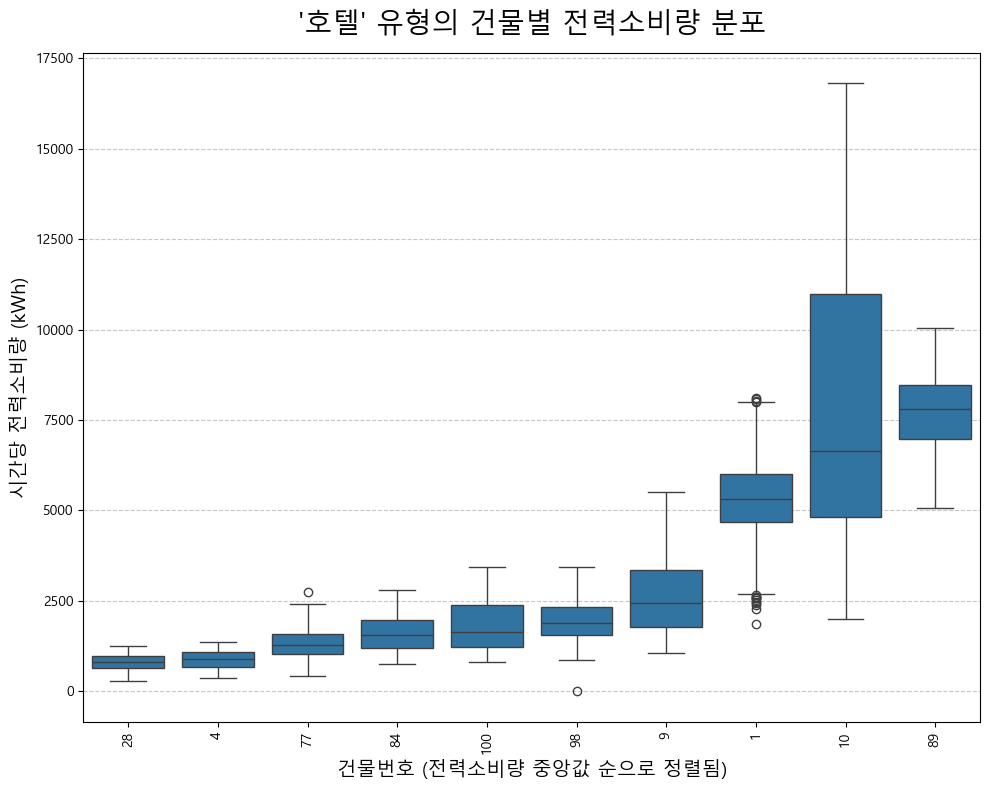

'건물유형별_전력소비량_분포_상용.png' 파일이 저장되었습니다.


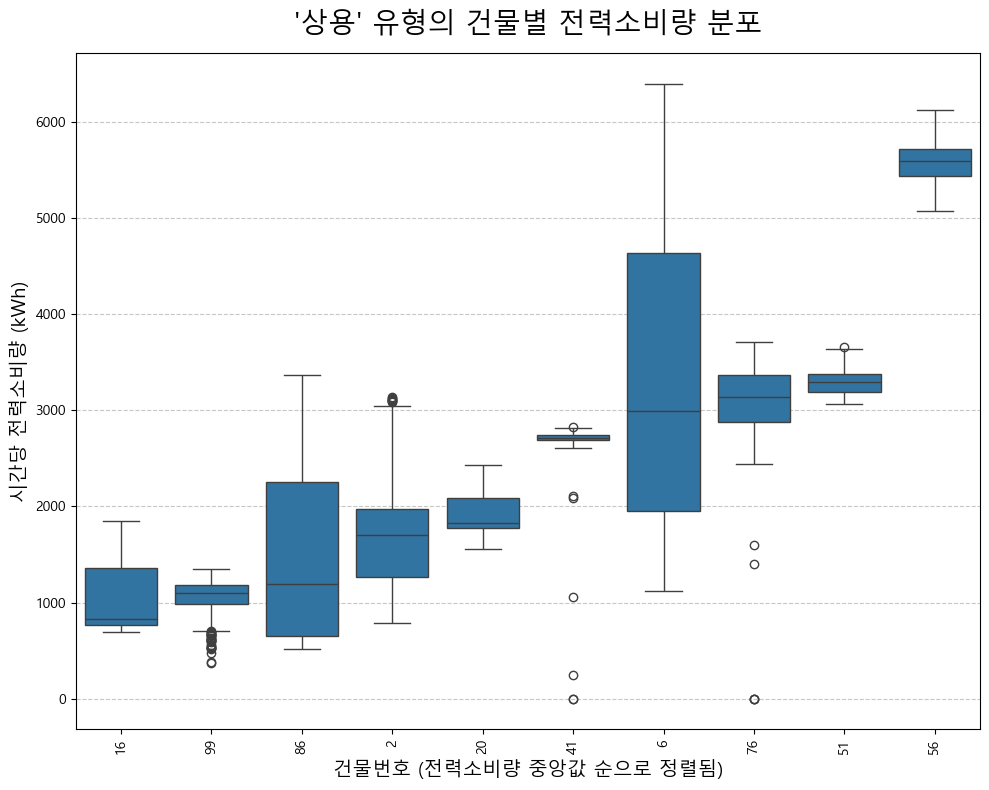

'건물유형별_전력소비량_분포_병원.png' 파일이 저장되었습니다.


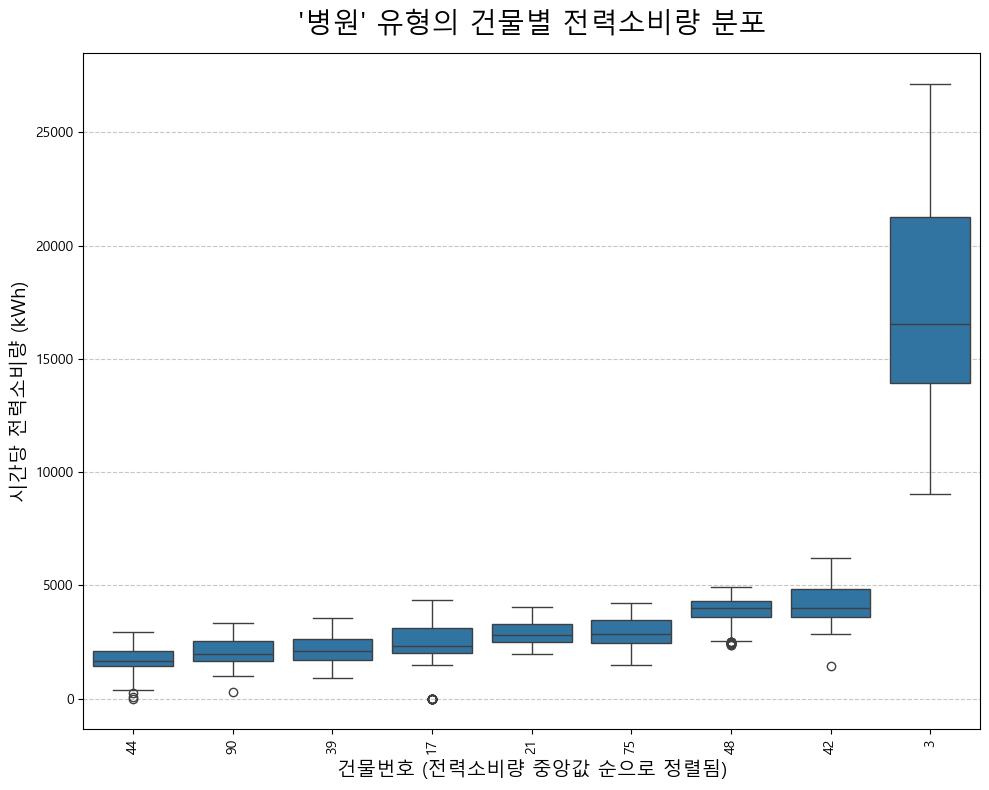

'건물유형별_전력소비량_분포_학교.png' 파일이 저장되었습니다.


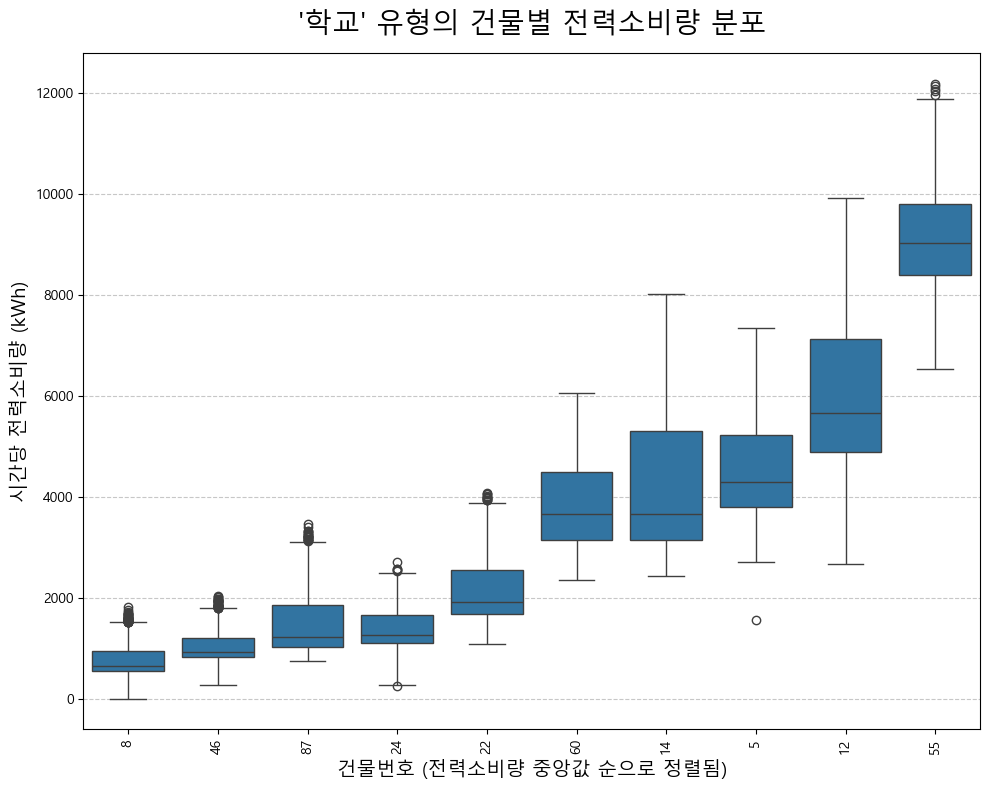

'건물유형별_전력소비량_분포_건물기타.png' 파일이 저장되었습니다.


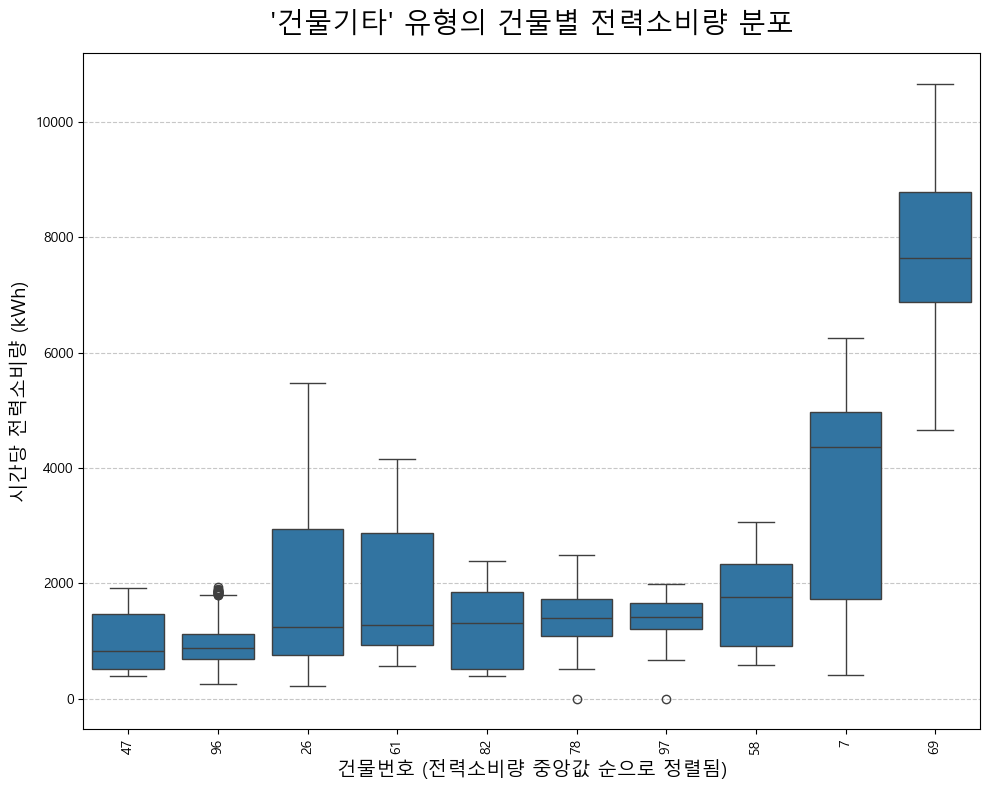

'건물유형별_전력소비량_분포_아파트.png' 파일이 저장되었습니다.


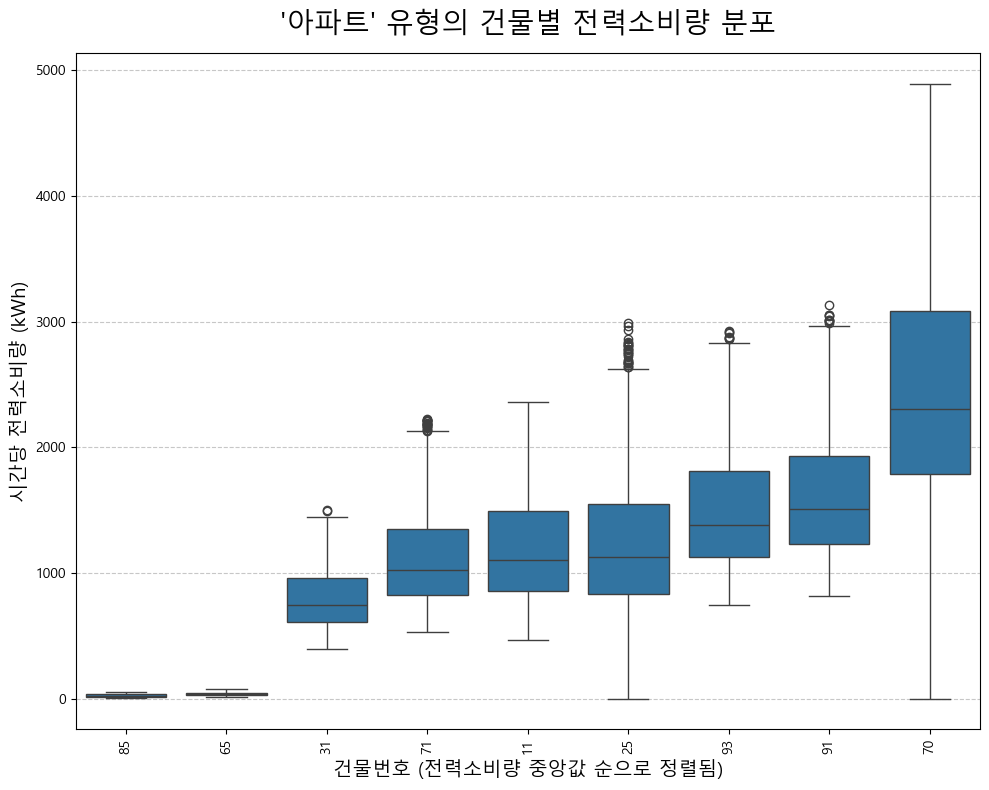

'건물유형별_전력소비량_분포_연구소.png' 파일이 저장되었습니다.


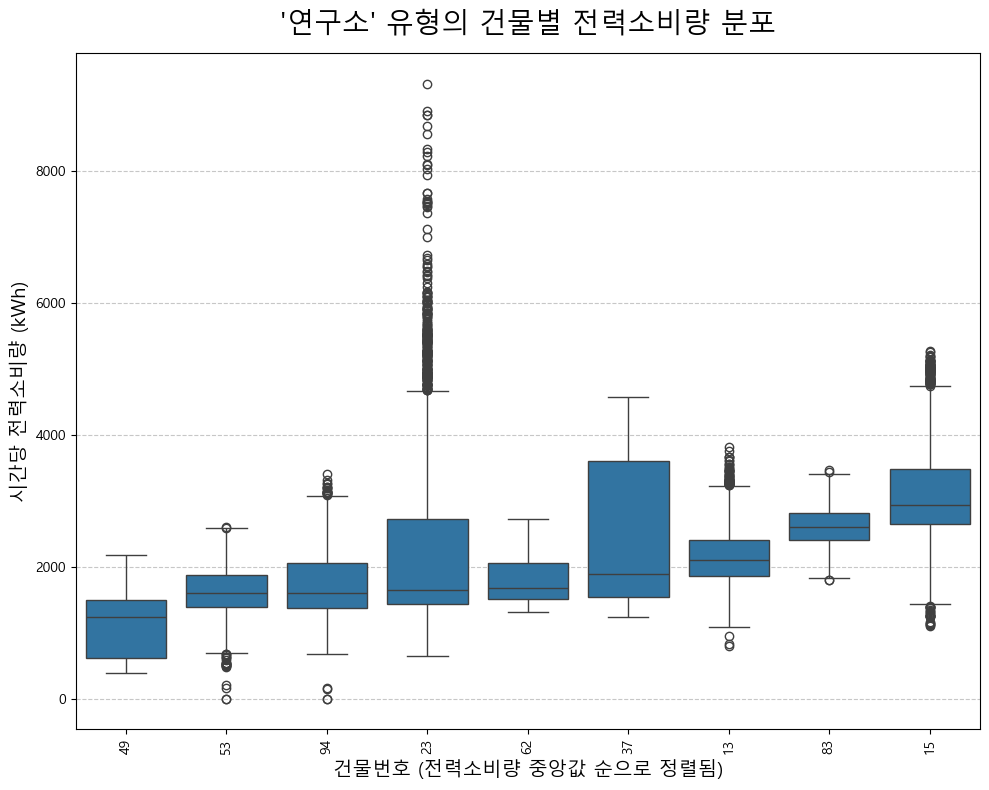

'건물유형별_전력소비량_분포_백화점.png' 파일이 저장되었습니다.


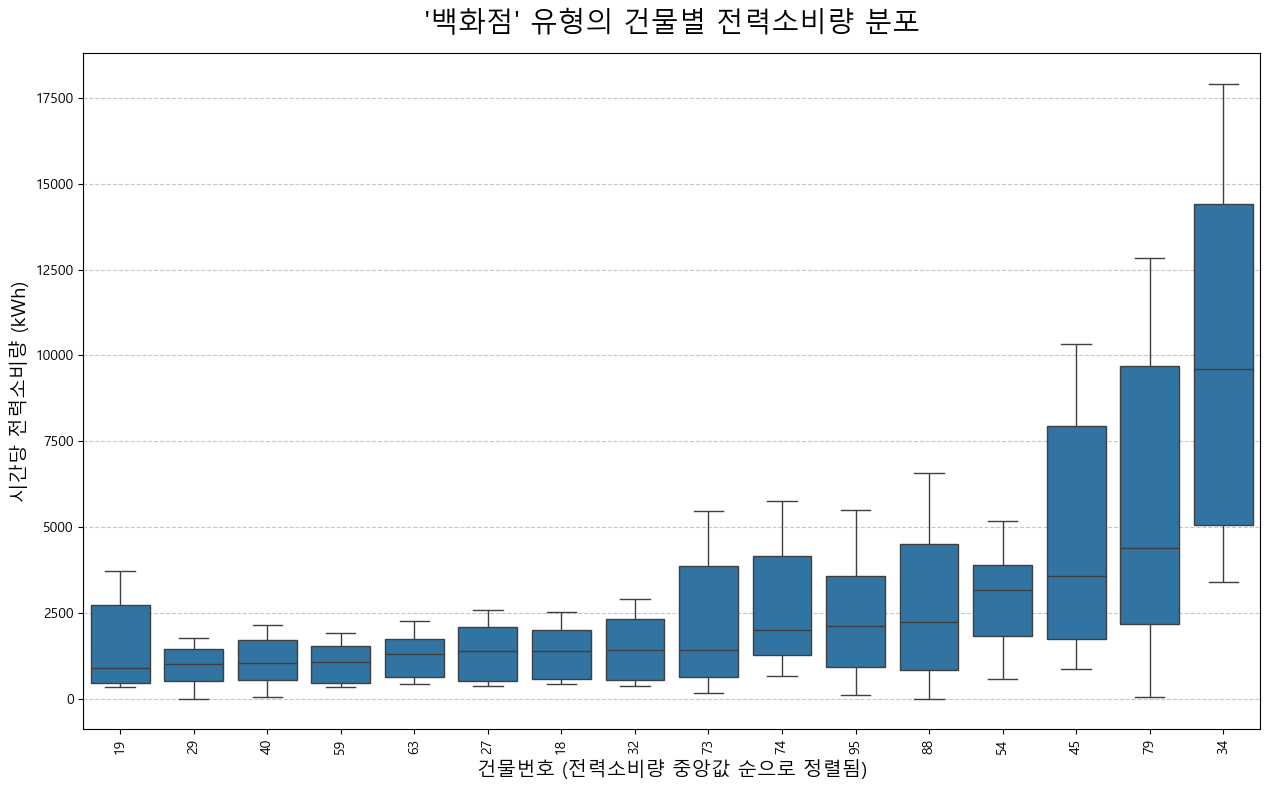

'건물유형별_전력소비량_분포_IDC(전화국).png' 파일이 저장되었습니다.


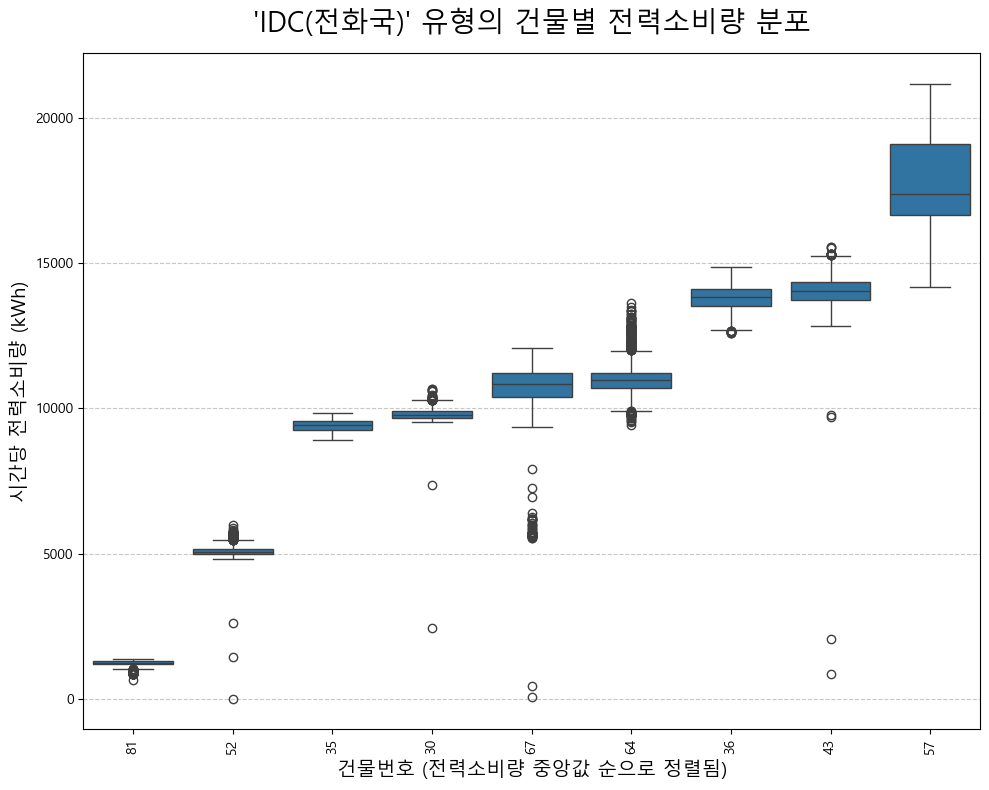

'건물유형별_전력소비량_분포_공공.png' 파일이 저장되었습니다.


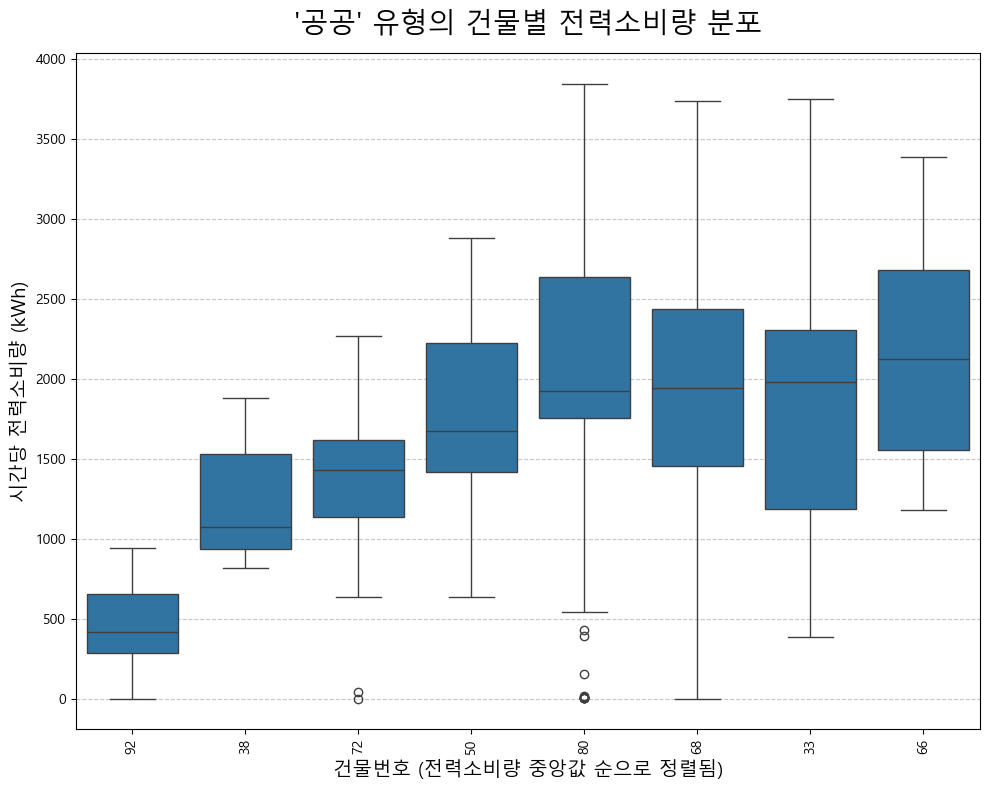


모든 그래프 생성이 완료되었습니다.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# --- 1. 한글 폰트 설정 ---
# 시스템에 설치된 한글 폰트를 지정합니다.
try:
    plt.rc('font', family='Malgun Gothic')
    plt.rcParams['axes.unicode_minus'] = False
except:
    print("Malgun Gothic 폰트를 찾을 수 없습니다. 다른 한글 폰트를 설정해주세요.")

# --- 2. 데이터 불러오기 및 병합 ---
try:
    # train.csv와 building_info.csv 파일을 읽어옵니다.
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()

# '건물번호'를 기준으로 두 데이터를 병합합니다.
merged_df = pd.merge(train_df, building_info_df[['건물번호', '건물유형']], on='건물번호', how='left')

# --- 3. 건물유형별 박스 플롯 생성 및 저장 ---
# 데이터에 존재하는 모든 고유한 건물유형을 가져옵니다.
unique_building_types = merged_df['건물유형'].unique()

print("각 건물유형별로 박스 플롯을 생성하고 파일로 저장합니다...")

# 각 건물유형에 대해 반복문을 실행합니다.
for building_type in unique_building_types:

    # 현재 순회 중인 건물유형에 해당하는 데이터만 필터링합니다.
    type_df = merged_df[merged_df['건물유형'] == building_type]

    # 데이터가 없는 경우 건너뜁니다.
    if type_df.empty:
        continue

    # 해당 유형 내에서 건물들을 전력소비량 중앙값 순으로 정렬합니다.
    building_order = type_df.groupby('건물번호')['전력소비량(kWh)'].median().sort_values().index

    # 해당 유형에 속한 건물의 수에 따라 그래프의 가로 길이를 동적으로 조절합니다.
    num_buildings = len(building_order)
    fig_width = max(10, num_buildings * 0.8)
    plt.figure(figsize=(fig_width, 8))

    # Seaborn을 사용하여 박스 플롯을 그립니다.
    ax = sns.boxplot(x='건물번호', y='전력소비량(kWh)', data=type_df, order=building_order)

    # 그래프 제목과 축 레이블을 설정합니다.
    plt.title(f"'{building_type}' 유형의 건물별 전력소비량 분포", fontsize=20, pad=15)
    plt.xlabel('건물번호 (전력소비량 중앙값 순으로 정렬됨)', fontsize=14)
    plt.ylabel('시간당 전력소비량 (kWh)', fontsize=14)

    # 건물번호가 많을 경우 x축 라벨을 회전시켜 가독성을 높입니다.
    if num_buildings > 5:
        plt.xticks(rotation=90, fontsize=10)
    else:
        plt.xticks(fontsize=12)

    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()

    # --- ★★★ 핵심 수정 사항 ★★★ ---
    # f-string을 사용하여 각 건물유형별로 고유한 파일 이름을 생성합니다.
    # 특수문자가 파일 이름에 포함되지 않도록 처리합니다.
    safe_building_type = building_type.replace('/', '_').replace('\\', '_')
    file_name = f'건물유형별_전력소비량_분포_{safe_building_type}.png'

    # 그래프를 파일로 저장합니다. dpi 옵션으로 해상도를 높입니다.
    plt.savefig(file_name, dpi=300, bbox_inches='tight')
    print(f"'{file_name}' 파일이 저장되었습니다.")

    # 그래프를 화면에도 표시합니다.
    plt.show()

print("\n모든 그래프 생성이 완료되었습니다.")



In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    test_df = pd.read_csv('test.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
    submission = pd.read_csv('sample_submission.csv')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")


# --- 2. Feature Engineering ---

# 체감온도 계산 함수 정의
def calculate_apparent_temp(temp, humidity, wind_speed):
    e = (humidity / 100) * 6.105 * np.exp((17.27 * temp) / (237.7 + temp))
    wind_speed_kmh = wind_speed * 3.6
    apparent_temp = temp + 0.33 * e - 0.70 * wind_speed_kmh - 4.00
    return apparent_temp

print("Feature Engineering을 시작합니다: '체감온도' 생성...")
# train/test 데이터에 체감온도 열 추가
train_df['체감온도(°C)'] = train_df.apply(
    lambda row: calculate_apparent_temp(row['기온(°C)'], row['습도(%)'], row['풍속(m/s)']),
    axis=1
)
test_df['체감온도(°C)'] = test_df.apply(
    lambda row: calculate_apparent_temp(row['기온(°C)'], row['습도(%)'], row['풍속(m/s)']),
    axis=1
)

# 다중공선성 방지를 위해 기존 변수 제거
train_df = train_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)'])
test_df = test_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)'])
print("'기온', '습도', '풍속' 원본 변수를 제거했습니다.")

# 시간 관련 변수 생성
train_df['일시'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')
test_df['일시'] = pd.to_datetime(test_df['일시'], format='%Y%m%d %H')

for df in [train_df, test_df]:
    df['hour'] = df['일시'].dt.hour
    df['weekday'] = df['일시'].dt.weekday
    df['month'] = df['일시'].dt.month
    df['day'] = df['일시'].dt.day

# 건물 정보 병합
train_df = pd.merge(train_df, building_info_df, on='건물번호', how='left')
test_df = pd.merge(test_df, building_info_df, on='건물번호', how='left')

# 결측치 처리 ('-' 값을 0으로 변환)
for df in [train_df, test_df]:
    for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
        df[col] = df[col].replace('-', 0).astype(float).fillna(0)

# 범주형 변수 원-핫 인코딩
train_df = pd.get_dummies(train_df, columns=['건물유형'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['건물유형'], drop_first=True)
print("원-핫 인코딩 완료.")


# --- ★★★ 핵심 수정 사항 ★★★ ---
# 1. train과 test 데이터의 컬럼을 동일하게 맞춰줍니다. (test 데이터에만 존재하는 건물유형 등이 있을 경우를 대비)
# train 데이터에 있는 컬럼을 기준으로 test 데이터의 컬럼을 재정렬하고, 없는 컬럼은 0으로 채웁니다.
train_cols = train_df.columns.tolist()
train_cols.remove('전력소비량(kWh)') # target 변수는 test에 없으므로 제외

test_df = test_df.reindex(columns=train_cols, fill_value=0)

# 2. 학습 변수 리스트를 동적으로 생성합니다. (더 이상 하드코딩하지 않음)
base_features = [
    '건물번호', 'hour', 'weekday', 'month', 'day',
    '강수량(mm)', '일조(hr)', '일사(MJ/m2)', '체감온도(°C)',
    '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)'
]
# 원-핫 인코딩으로 생성된 '건물유형_' 컬럼들을 자동으로 찾아 리스트에 추가합니다.
dummy_features = [col for col in train_df.columns if '건물유형_' in col]
features = base_features + dummy_features # 두 리스트를 합쳐 최종 feature 리스트 생성

target = '전력소비량(kWh)'
print("Feature Engineering 완료 및 학습 변수 리스트 동적 생성 완료.")

# --- 3. Model Training & Prediction ---
print("\n각 건물별 모델 학습 및 예측을 시작합니다...")

for building_num in range(1, 101):
    print(f"  - 처리 중: 건물 #{building_num}...")

    train_building = train_df[train_df['건물번호'] == building_num]
    test_building = test_df[test_df['건물번호'] == building_num]

    X_train = train_building[features]
    y_train = train_building[target]
    X_test = test_building[features]

    model = xgb.XGBRegressor(
        objective='reg:squarederror', n_estimators=1000, learning_rate=0.05,
        max_depth=5, subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1
    )

    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    submission.loc[submission['num_date_time'].str.startswith(f'{building_num}_'), 'answer'] = preds

print("모든 예측이 완료되었습니다.")

# --- 4. Create Submission File ---
submission.to_csv('submission_apparent_temp_fixed.csv', index=False)
print("\n제출 파일 'submission_apparent_temp_fixed.csv'이(가) 성공적으로 생성되었습니다!")
## 체감온도 적용


데이터를 불러오는 중입니다...
데이터 로딩 완료.
Feature Engineering을 시작합니다: '체감온도' 생성...
'기온', '습도', '풍속' 원본 변수를 제거했습니다.
원-핫 인코딩 완료.
Feature Engineering 완료 및 학습 변수 리스트 동적 생성 완료.

각 건물별 모델 학습 및 예측을 시작합니다...
  - 처리 중: 건물 #1...
  - 처리 중: 건물 #2...
  - 처리 중: 건물 #3...
  - 처리 중: 건물 #4...
  - 처리 중: 건물 #5...
  - 처리 중: 건물 #6...
  - 처리 중: 건물 #7...
  - 처리 중: 건물 #8...
  - 처리 중: 건물 #9...
  - 처리 중: 건물 #10...
  - 처리 중: 건물 #11...
  - 처리 중: 건물 #12...
  - 처리 중: 건물 #13...
  - 처리 중: 건물 #14...
  - 처리 중: 건물 #15...
  - 처리 중: 건물 #16...
  - 처리 중: 건물 #17...
  - 처리 중: 건물 #18...
  - 처리 중: 건물 #19...
  - 처리 중: 건물 #20...
  - 처리 중: 건물 #21...
  - 처리 중: 건물 #22...
  - 처리 중: 건물 #23...
  - 처리 중: 건물 #24...
  - 처리 중: 건물 #25...
  - 처리 중: 건물 #26...
  - 처리 중: 건물 #27...
  - 처리 중: 건물 #28...
  - 처리 중: 건물 #29...
  - 처리 중: 건물 #30...
  - 처리 중: 건물 #31...
  - 처리 중: 건물 #32...
  - 처리 중: 건물 #33...
  - 처리 중: 건물 #34...
  - 처리 중: 건물 #35...
  - 처리 중: 건물 #36...
  - 처리 중: 건물 #37...
  - 처리 중: 건물 #38...
  - 처리 중: 건물 #39...
  - 처리 중: 건물 #40...
  - 처리 중: 건물 #41...
  

In [ ]:
result = pd.read_csv('submission_apparent_temp_fixed.csv')
result

num_date_time       answer
0        1_20240825 00  3660.057861
1        1_20240825 01  3233.819824
2        1_20240825 02  3015.976562
3        1_20240825 03  2690.515137
4        1_20240825 04  2522.377930
...                ...          ...
16795  100_20240831 19  3423.098877
16796  100_20240831 20  3327.143066
16797  100_20240831 21  3338.614746
16798  100_20240831 22  3251.329346
16799  100_20240831 23  3343.663330

[16800 rows x 2 columns]

In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Data Loading ---
print("모델 평가를 위해 데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")


# --- 2. Feature Engineering (평가에 필요한 전처리) ---

# 체감온도 계산 함수
def calculate_apparent_temp(temp, humidity, wind_speed):
    e = (humidity / 100) * 6.105 * np.exp((17.27 * temp) / (237.7 + temp))
    wind_speed_kmh = wind_speed * 3.6
    apparent_temp = temp + 0.33 * e - 0.70 * wind_speed_kmh - 4.00
    return apparent_temp

print("Feature Engineering을 시작합니다...")
# 체감온도 열 추가 및 원본 변수 제거
train_df['체감온도(°C)'] = train_df.apply(lambda row: calculate_apparent_temp(row['기온(°C)'], row['습도(%)'], row['풍속(m/s)']), axis=1)
train_df = train_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)'])

# --- ★★★ 핵심 수정 사항 ★★★ ---
# 시간 관련 변수 생성 시 format 문자열을 정확하게 수정합니다.
train_df['일시'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')
train_df['hour'] = train_df['일시'].dt.hour
train_df['weekday'] = train_df['일시'].dt.weekday
train_df['month'] = train_df['일시'].dt.month
train_df['day'] = train_df['일시'].dt.day

# 건물 정보 병합 및 전처리
train_df = pd.merge(train_df, building_info_df, on='건물번호', how='left')
for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
    train_df[col] = train_df[col].replace('-', 0).astype(float).fillna(0)
train_df = pd.get_dummies(train_df, columns=['건물유형'], drop_first=True)

# 학습 변수 리스트 동적 생성
base_features = ['건물번호', 'hour', 'weekday', 'month', 'day', '강수량(mm)', '일조(hr)', '일사(MJ/m2)', '체감온도(°C)', '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']
dummy_features = [col for col in train_df.columns if '건물유형_' in col]
features = base_features + dummy_features
target = '전력소비량(kWh)'
print("Feature Engineering 완료.")


# --- 3. Model Evaluation ---
evaluation_results = []
print("\n각 건물별 모델 성능 평가를 시작합니다...")

for building_num in range(1, 101):
    train_building = train_df[train_df['건물번호'] == building_num]

    X = train_building[features]
    y = train_building[target]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = xgb.XGBRegressor(
        objective='reg:squarederror', n_estimators=1000, learning_rate=0.05,
        max_depth=5, subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1, early_stopping_rounds=50
    )

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    evaluation_results.append({'건물번호': building_num, 'RMSE': rmse, 'MAE': mae, 'R2 Score': r2})

    if building_num % 10 == 0:
        print(f"  ... {building_num}번 건물까지 평가 완료.")

print("모든 건물에 대한 평가가 완료되었습니다.")


# --- 4. Evaluation Result Display ---
print("\n--- 모델 성능 평가 결과 (건물별) ---")
results_df = pd.DataFrame(evaluation_results)
print(results_df.to_string(index=False))

print("\n--- 전체 100개 건물 모델의 평균 성능 ---")
average_performance = results_df.drop(columns='건물번호').mean()
print(f"Average RMSE (평균 오차): {average_performance['RMSE']:.3f} kWh")
print(f"Average MAE  (평균 절대 오차): {average_performance['MAE']:.3f} kWh")
print(f"Average R2 Score (모델 설명력): {average_performance['R2 Score']:.3f}")



모델 평가를 위해 데이터를 불러오는 중입니다...
데이터 로딩 완료.
Feature Engineering을 시작합니다...
Feature Engineering 완료.

각 건물별 모델 성능 평가를 시작합니다...
  ... 10번 건물까지 평가 완료.
  ... 20번 건물까지 평가 완료.
  ... 30번 건물까지 평가 완료.
  ... 40번 건물까지 평가 완료.
  ... 50번 건물까지 평가 완료.
  ... 60번 건물까지 평가 완료.
  ... 70번 건물까지 평가 완료.
  ... 80번 건물까지 평가 완료.
  ... 90번 건물까지 평가 완료.
  ... 100번 건물까지 평가 완료.
모든 건물에 대한 평가가 완료되었습니다.

--- 모델 성능 평가 결과 (건물별) ---
 건물번호       RMSE        MAE  R2 Score
    1 489.030052 390.443056  0.701575
    2 145.540657  98.426772  0.894415
    3 566.843335 391.069427  0.984110
    4  52.529780  39.773080  0.953898
    5 179.904107  87.976249  0.970570
    6 278.269638 191.426519  0.964723
    7 258.680784 169.726817  0.975689
    8  56.428439  35.901541  0.968427
    9 167.528395 120.796780  0.973859
   10 491.617330 343.473171  0.980929
   11  53.715571  39.493127  0.983606
   12 259.777052 143.713658  0.969902
   13 107.879889  69.846715  0.938565
   14 153.076136 101.712425  0.988934
   15 159.572136 109.903644  0.955236
  

In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    test_df = pd.read_csv('test.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
    submission = pd.read_csv('sample_submission.csv')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")


# --- 2. Feature Engineering ---
print("Feature Engineering을 시작합니다...")

# 체감온도 계산 함수
def calculate_apparent_temp(temp, humidity, wind_speed):
    e = (humidity / 100) * 6.105 * np.exp((17.27 * temp) / (237.7 + temp))
    wind_speed_kmh = wind_speed * 3.6
    apparent_temp = temp + 0.33 * e - 0.70 * wind_speed_kmh - 4.00
    return apparent_temp

# train/test 데이터프레임에 동일한 전처리 적용
for df in [train_df, test_df]:
    df['체감온도(°C)'] = df.apply(lambda row: calculate_apparent_temp(row['기온(°C)'], row['습도(%)'], row['풍속(m/s)']), axis=1)
    df['일시'] = pd.to_datetime(df['일시'], format='%Y%m%d %H')
    df['hour'] = df['일시'].dt.hour
    df['weekday'] = df['일시'].dt.weekday
    df['month'] = df['일시'].dt.month
    df['day'] = df['일시'].dt.day
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

# 불필요한 원본 변수 제거
train_df = train_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)', 'hour', 'weekday'])
test_df = test_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)', 'hour', 'weekday'])

# 건물 정보 병합 및 추가 전처리
train_df = pd.merge(train_df, building_info_df, on='건물번호', how='left')
test_df = pd.merge(test_df, building_info_df, on='건물번호', how='left')
for df in [train_df, test_df]:
    for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
        df[col] = df[col].replace('-', 0).astype(float).fillna(0)
train_df = pd.get_dummies(train_df, columns=['건물유형'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['건물유형'], drop_first=True)

# 학습 변수 리스트 동적 생성 및 train/test 컬럼 동기화
train_cols = train_df.columns.tolist()
train_cols.remove('전력소비량(kWh)')
test_df = test_df.reindex(columns=train_cols, fill_value=0)
base_features = ['건물번호', 'month', 'day', '강수량(mm)', '일조(hr)', '일사(MJ/m2)', '체감온도(°C)', '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos']
dummy_features = [col for col in train_df.columns if '건물유형_' in col]
features = base_features + dummy_features
target = '전력소비량(kWh)'
print("Feature Engineering 완료.")


# --- 3. Prediction First ---
print("\n--- 파트 1: 최종 예측 수행 및 파일 저장 ---")
print("각 건물별 모델 학습 및 예측을 시작합니다...")

# 각 건물별로 모델을 학습하고 test 데이터에 대한 예측 수행
for building_num in range(1, 101):
    train_building = train_df[train_df['건물번호'] == building_num]
    test_building = test_df[test_df['건물번호'] == building_num]

    X_train = train_building[features]
    y_train = train_building[target]
    X_test = test_building[features]

    # 최종 예측을 위해 해당 건물의 전체 학습 데이터로 모델 훈련
    model = xgb.XGBRegressor(
        objective='reg:squarederror', n_estimators=1000, learning_rate=0.05,
        max_depth=5, subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1
    )
    model.fit(X_train, y_train)

    # 예측 수행
    preds = model.predict(X_test)

    # 예측 결과를 submission 파일에 저장
    submission.loc[submission['num_date_time'].str.startswith(f'{building_num}_'), 'answer'] = preds

    if building_num % 10 == 0:
        print(f"  ... {building_num}번 건물까지 예측 완료.")

# 예측 결과를 파일로 저장
submission.to_csv('submission_final.csv', index=False)
print("모든 예측이 완료되었습니다.")
print("제출 파일 'submission_final.csv'이(가) 성공적으로 생성되었습니다!")


# --- 4. Evaluation Second ---
print("\n--- 파트 2: 모델 성능 평가 ---")
evaluation_results = []

# 각 건물별로 학습/검증 데이터를 나누어 모델 성능 평가
for building_num in range(1, 101):
    train_building = train_df[train_df['건물번호'] == building_num]

    X = train_building[features]
    y = train_building[target]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = xgb.XGBRegressor(
        objective='reg:squarederror', n_estimators=1000, learning_rate=0.05,
        max_depth=5, subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1, early_stopping_rounds=50
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    evaluation_results.append({'건물번호': building_num, 'RMSE': rmse, 'MAE': mae, 'R2 Score': r2})

print("모든 건물에 대한 평가가 완료되었습니다.")

# --- 5. Display Evaluation Results ---
print("\n--- 모델 성능 평가 결과 ---")
results_df = pd.DataFrame(evaluation_results)
print(results_df.to_string(index=False))

print("\n--- 전체 100개 건물 모델의 평균 성능 ---")
average_performance = results_df.drop(columns='건물번호').mean()
print(f"Average RMSE (평균 오차): {average_performance['RMSE']:.3f} kWh")
print(f"Average MAE  (평균 절대 오차): {average_performance['MAE']:.3f} kWh")
print(f"Average R2 Score (모델 설명력): {average_performance['R2 Score']:.3f}")


데이터를 불러오는 중입니다...
데이터 로딩 완료.
Feature Engineering을 시작합니다...
Feature Engineering 완료.

--- 파트 1: 최종 예측 수행 및 파일 저장 ---
각 건물별 모델 학습 및 예측을 시작합니다...
  ... 10번 건물까지 예측 완료.
  ... 20번 건물까지 예측 완료.
  ... 30번 건물까지 예측 완료.
  ... 40번 건물까지 예측 완료.
  ... 50번 건물까지 예측 완료.
  ... 60번 건물까지 예측 완료.
  ... 70번 건물까지 예측 완료.
  ... 80번 건물까지 예측 완료.
  ... 90번 건물까지 예측 완료.
  ... 100번 건물까지 예측 완료.
모든 예측이 완료되었습니다.
제출 파일 'submission_final.csv'이(가) 성공적으로 생성되었습니다!

--- 파트 2: 모델 성능 평가 ---
모든 건물에 대한 평가가 완료되었습니다.

--- 모델 성능 평가 결과 ---
 건물번호       RMSE        MAE  R2 Score
    1 492.172246 393.432685  0.697727
    2 145.278194  98.882950  0.894796
    3 566.195427 385.393653  0.984146
    4  53.265791  41.157127  0.952597
    5 178.320125  87.492728  0.971086
    6 277.425087 192.382083  0.964937
    7 303.413453 189.614511  0.966553
    8  53.137052  34.547915  0.972003
    9 168.058851 120.846343  0.973693
   10 497.437321 347.051426  0.980474
   11  49.729422  36.651350  0.985949
   12 259.837394 143.038265  0.969888
   13 101.5

In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    test_df = pd.read_csv('test.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
    submission = pd.read_csv('sample_submission.csv')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")


# --- 2. Feature Engineering & Preprocessing ---
print("Feature Engineering을 시작합니다...")

# (전략 2) 공휴일 정보 추가
holidays = ['2024-06-06', '2024-08-15']

# 체감온도 계산 함수
def calculate_apparent_temp(temp, humidity, wind_speed):
    e = (humidity / 100) * 6.105 * np.exp((17.27 * temp) / (237.7 + temp))
    wind_speed_kmh = wind_speed * 3.6
    apparent_temp = temp + 0.33 * e - 0.70 * wind_speed_kmh - 4.00
    return apparent_temp

# train/test 데이터프레임에 동일한 전처리 적용
for df in [train_df, test_df]:
    df['일시'] = pd.to_datetime(df['일시'], format='%Y%m%d %H')
    df['체감온도(°C)'] = df.apply(lambda row: calculate_apparent_temp(row['기온(°C)'], row['습도(%)'], row['풍속(m/s)']), axis=1)
    df['hour'] = df['일시'].dt.hour
    df['weekday'] = df['일시'].dt.weekday
    df['month'] = df['일시'].dt.month
    df['day'] = df['일시'].dt.day
    df['is_holiday'] = df['일시'].dt.date.astype(str).isin(holidays).astype(int) # 공휴일 변수
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

# (전략 1) Lag Features 생성
# 건물별로 그룹화하여 lag feature를 생성해야 데이터가 섞이지 않음
train_df = train_df.sort_values(by=['건물번호', '일시'])
train_df['lag_24h'] = train_df.groupby('건물번호')['전력소비량(kWh)'].shift(24)
train_df['lag_168h'] = train_df.groupby('건물번호')['전력소비량(kWh)'].shift(168)
# Lag feature 생성으로 생긴 결측치는 바로 앞의 값으로 채움 (초반 데이터)
train_df.fillna(method='bfill', inplace=True)

# 다중공선성 방지 및 불필요한 변수 제거
train_df = train_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)', 'hour', 'weekday'])
test_df = test_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)', 'hour', 'weekday'])

# (전략 4) 이상치 처리 (Winsorizing)
# 각 건물별로 전력소비량의 상위 1%, 하위 1%를 벗어나는 값을 경계값으로 대체
for building_num in train_df['건물번호'].unique():
    subset = train_df['건물번호'] == building_num
    power = train_df.loc[subset, '전력소비량(kWh)']
    p01 = power.quantile(0.01)
    p99 = power.quantile(0.99)
    train_df.loc[subset, '전력소비량(kWh)'] = power.clip(p01, p99)

# 건물 정보 병합 및 추가 전처리
train_df = pd.merge(train_df, building_info_df, on='건물번호', how='left')
test_df = pd.merge(test_df, building_info_df, on='건물번호', how='left')
for df in [train_df, test_df]:
    for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
        df[col] = df[col].replace('-', 0).astype(float).fillna(0)
train_df = pd.get_dummies(train_df, columns=['건물유형'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['건물유형'], drop_first=True)

# 학습 변수 리스트 동적 생성 및 train/test 컬럼 동기화
target = '전력소비량(kWh)'
train_cols = [col for col in train_df.columns if col != target]
test_df = test_df.reindex(columns=train_cols, fill_value=0)
features = [col for col in train_cols if col not in ['num_date_time', '일시']]
print("Feature Engineering 완료.")


# --- 3. Model Evaluation (개선된 모델) ---
evaluation_results = []
print("\n개선된 모델의 성능 평가를 시작합니다...")

for building_num in range(1, 101):
    train_building = train_df[train_df['건물번호'] == building_num]
    X = train_building[features]
    y = train_building[target]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, early_stopping_rounds=50)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    evaluation_results.append({'건물번호': building_num, 'RMSE': rmse})

    if building_num % 10 == 0:
        print(f"  ... {building_num}번 건물까지 평가 완료.")

# --- 4. Evaluation Result Display ---
print("\n--- 모델 성능 평가 결과 (개선 후) ---")
results_df = pd.DataFrame(evaluation_results)
print(results_df.to_string(index=False))
print("\n--- 전체 100개 건물 모델의 평균 성능 (개선 후) ---")
average_performance = results_df.drop(columns='건물번호').mean()
print(f"Average RMSE (평균 오차): {average_performance['RMSE']:.3f} kWh")


데이터를 불러오는 중입니다...
데이터 로딩 완료.
Feature Engineering을 시작합니다...
Feature Engineering 완료.

개선된 모델의 성능 평가를 시작합니다...
  ... 10번 건물까지 평가 완료.
  ... 20번 건물까지 평가 완료.
  ... 30번 건물까지 평가 완료.
  ... 40번 건물까지 평가 완료.
  ... 50번 건물까지 평가 완료.
  ... 60번 건물까지 평가 완료.
  ... 70번 건물까지 평가 완료.
  ... 80번 건물까지 평가 완료.
  ... 90번 건물까지 평가 완료.
  ... 100번 건물까지 평가 완료.

--- 모델 성능 평가 결과 (개선 후) ---
 건물번호       RMSE
    1 518.584749
    2 163.489435
    3 641.261239
    4  55.250636
    5 161.835367
    6 274.512176
    7 298.773726
    8  49.867202
    9 190.316468
   10 486.307478
   11  55.655432
   12 235.519609
   13 107.057137
   14 132.703930
   15 165.019480
   16  40.557313
   17 119.315893
   18  90.766347
   19 129.905307
   20  26.243433
   21  72.608463
   22 105.350922
   23 569.731494
   24  90.903302
   25 122.647682
   26 242.920462
   27  82.590216
   28  37.820908
   29  52.068982
   30  48.619052
   31  39.067747
   32  83.381214
   33 176.641201
   34 347.797630
   35  32.892053
   36  77.345533
   37 162.9909

In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Data Loading ---
print("모델 평가를 위해 데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")


# --- 2. Feature Engineering ---

# 체감온도 계산 함수
def calculate_apparent_temp(temp, humidity, wind_speed):
    e = (humidity / 100) * 6.105 * np.exp((17.27 * temp) / (237.7 + temp))
    wind_speed_kmh = wind_speed * 3.6
    apparent_temp = temp + 0.33 * e - 0.70 * wind_speed_kmh - 4.00
    return apparent_temp

print("Feature Engineering을 시작합니다...")
# 체감온도 열 추가 및 원본 변수 제거
train_df['체감온도(°C)'] = train_df.apply(lambda row: calculate_apparent_temp(row['기온(°C)'], row['습도(%)'], row['풍속(m/s)']), axis=1)
train_df = train_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)'])

# 시간 관련 변수 생성
train_df['일시'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')
train_df['hour'] = train_df['일시'].dt.hour
train_df['weekday'] = train_df['일시'].dt.weekday
train_df['month'] = train_df['일시'].dt.month
train_df['day'] = train_df['일시'].dt.day

# --- ★★★ 핵심 수정 사항: 주기성 특징 생성 ★★★ ---
print("주기성 특징(Cyclical Features)을 생성합니다...")
# 시간(hour) 변수를 sin, cos으로 변환 (주기: 24)
train_df['hour_sin'] = np.sin(2 * np.pi * train_df['hour'] / 24)
train_df['hour_cos'] = np.cos(2 * np.pi * train_df['hour'] / 24)

# 요일(weekday) 변수를 sin, cos으로 변환 (주기: 7)
train_df['weekday_sin'] = np.sin(2 * np.pi * train_df['weekday'] / 7)
train_df['weekday_cos'] = np.cos(2 * np.pi * train_df['weekday'] / 7)

# 원본 시간, 요일 변수는 더 이상 필요 없으므로 제거
train_df = train_df.drop(columns=['hour', 'weekday'])
print("생성 완료: 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos'")

# 건물 정보 병합 및 전처리
train_df = pd.merge(train_df, building_info_df, on='건물번호', how='left')
for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
    train_df[col] = train_df[col].replace('-', 0).astype(float).fillna(0)
train_df = pd.get_dummies(train_df, columns=['건물유형'], drop_first=True)

# 학습 변수 리스트 업데이트
base_features = ['건물번호', 'month', 'day', '강수량(mm)', '일조(hr)', '일사(MJ/m2)', '체감온도(°C)',
                 '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)',
                 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos'] # <-- 주기성 변수 추가
dummy_features = [col for col in train_df.columns if '건물유형_' in col]
features = base_features + dummy_features
target = '전력소비량(kWh)'
print("Feature Engineering 완료.")


# --- 3. Model Evaluation ---
evaluation_results = []
print("\n각 건물별 모델 성능 평가를 시작합니다...")

for building_num in range(1, 101):
    train_building = train_df[train_df['건물번호'] == building_num]
    X = train_building[features]
    y = train_building[target]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = xgb.XGBRegressor(
        objective='reg:squarederror', n_estimators=1000, learning_rate=0.05,
        max_depth=5, subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1, early_stopping_rounds=50
    )

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    evaluation_results.append({'건물번호': building_num, 'RMSE': rmse, 'MAE': mae, 'R2 Score': r2})

    if building_num % 10 == 0:
        print(f"  ... {building_num}번 건물까지 평가 완료.")

print("모든 건물에 대한 평가가 완료되었습니다.")


# --- 4. Evaluation Result Display ---
print("\n--- 모델 성능 평가 결과 (주기성 특징 반영) ---")
results_df = pd.DataFrame(evaluation_results)
print(results_df.to_string(index=False))

print("\n--- 전체 100개 건물 모델의 평균 성능 ---")
average_performance = results_df.drop(columns='건물번호').mean()
print(f"Average RMSE (평균 오차): {average_performance['RMSE']:.3f} kWh")
print(f"Average MAE  (평균 절대 오차): {average_performance['MAE']:.3f} kWh")
print(f"Average R2 Score (모델 설명력): {average_performance['R2 Score']:.3f}")



모델 평가를 위해 데이터를 불러오는 중입니다...
데이터 로딩 완료.
Feature Engineering을 시작합니다...
주기성 특징(Cyclical Features)을 생성합니다...
생성 완료: 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos'
Feature Engineering 완료.

각 건물별 모델 성능 평가를 시작합니다...
  ... 10번 건물까지 평가 완료.
  ... 20번 건물까지 평가 완료.
  ... 30번 건물까지 평가 완료.
  ... 40번 건물까지 평가 완료.
  ... 50번 건물까지 평가 완료.
  ... 60번 건물까지 평가 완료.
  ... 70번 건물까지 평가 완료.
  ... 80번 건물까지 평가 완료.
  ... 90번 건물까지 평가 완료.
  ... 100번 건물까지 평가 완료.
모든 건물에 대한 평가가 완료되었습니다.

--- 모델 성능 평가 결과 (주기성 특징 반영) ---
 건물번호       RMSE        MAE  R2 Score
    1 492.172246 393.432685  0.697727
    2 145.278194  98.882950  0.894796
    3 566.195427 385.393653  0.984146
    4  53.265791  41.157127  0.952597
    5 178.320125  87.492728  0.971086
    6 277.425087 192.382083  0.964937
    7 303.413453 189.614511  0.966553
    8  53.137052  34.547915  0.972003
    9 168.058851 120.846343  0.973693
   10 497.437321 347.051426  0.980474
   11  49.729422  36.651350  0.985949
   12 259.837394 143.038265  0.969888
   13 101.5795

In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    test_df = pd.read_csv('test.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
    submission = pd.read_csv('sample_submission.csv')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")


# --- 2. Feature Engineering ---
print("Feature Engineering을 시작합니다...")

# --- 2-1. 제안 아이디어 1: 더미 변수 추가 ---
print("  - 주말/폭염/강수 여부 더미 변수를 추가합니다...")
for df in [train_df, test_df]:
    df['일시_dt'] = pd.to_datetime(df['일시'], format='%Y%m%d %H')
    df['주말여부'] = df['일시_dt'].dt.weekday.isin([5, 6]).astype(int)
    df['폭염여부'] = (df['기온(°C)'] >= 33).astype(int)
    df['강수여부'] = (df['강수량(mm)'] > 0).astype(int)

# --- 2-2. 제안 아이디어 2: 냉방 도일(Breakpoint) 변수 추가 ---
print("  - 최적의 냉방 전환 온도를 찾고, 냉방 도일 변수를 추가합니다...")
# train 데이터 전체를 사용하여 가장 설명력이 높은 단일 전환 온도를 찾습니다.
X_temp = train_df['기온(°C)']
y_power = train_df['전력소비량(kWh)']
candidate = range(int(X_temp.min()), int(X_temp.max()) + 1)
best_bp = None
best_r2 = -np.inf

for bp in candidate:
    X_bp = pd.DataFrame({"temp": X_temp, "above_bp": (X_temp > bp) * (X_temp - bp)})
    X_bp = sm.add_constant(X_bp)
    model = sm.OLS(y_power, X_bp).fit()
    if model.rsquared > best_r2:
        best_r2 = model.rsquared
        best_bp = bp

print(f"  >> 가장 설명력이 높은 전환 온도 = {best_bp}°C, R²={best_r2:.3f}")

# 찾은 최적의 전환 온도를 기준으로 '냉방도일' 변수 생성
for df in [train_df, test_df]:
    df['냉방도일'] = (df['기온(°C)'] > best_bp) * (df['기온(°C)'] - best_bp)

# --- 2-3. 기존 Feature Engineering (체감온도, 주기성) ---
print("  - 체감온도 및 주기성 특징을 추가합니다...")
def calculate_apparent_temp(temp, humidity, wind_speed):
    e = (humidity / 100) * 6.105 * np.exp((17.27 * temp) / (237.7 + temp))
    wind_speed_kmh = wind_speed * 3.6
    apparent_temp = temp + 0.33 * e - 0.70 * wind_speed_kmh - 4.00
    return apparent_temp

for df in [train_df, test_df]:
    df['체감온도(°C)'] = df.apply(lambda row: calculate_apparent_temp(row['기온(°C)'], row['습도(%)'], row['풍속(m/s)']), axis=1)
    df['hour'] = df['일시_dt'].dt.hour
    df['weekday'] = df['일시_dt'].dt.weekday
    df['month'] = df['일시_dt'].dt.month
    df['day'] = df['일시_dt'].dt.day
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

# 다중공선성 방지 및 불필요한 변수 제거
train_df = train_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)', 'hour', 'weekday', '일시_dt'])
test_df = test_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)', 'hour', 'weekday', '일시_dt'])

# --- 2-4. 최종 데이터셋 준비 ---
train_df = pd.merge(train_df, building_info_df, on='건물번호', how='left')
test_df = pd.merge(test_df, building_info_df, on='건물번호', how='left')
for df in [train_df, test_df]:
    for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
        df[col] = df[col].replace('-', 0).astype(float).fillna(0)
train_df = pd.get_dummies(train_df, columns=['건물유형'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['건물유형'], drop_first=True)

# 학습 변수 리스트 동적 생성 및 train/test 컬럼 동기화
target = '전력소비량(kWh)'
train_cols = [col for col in train_df.columns if col != target]
test_df = test_df.reindex(columns=train_cols, fill_value=0)
features = [col for col in train_cols if col not in ['num_date_time', '일시']]
print("Feature Engineering 완료.")


# --- 3. Model Training, Evaluation & Prediction ---
evaluation_results = []
print("\n각 건물별 모델 학습, 평가 및 예측을 시작합니다...")

for building_num in range(1, 101):
    train_building = train_df[train_df['건물번호'] == building_num]
    test_building = test_df[test_df['건물번호'] == building_num]

    X = train_building[features]
    y = train_building[target]

    # --- Part 1: 모델 평가 ---
    X_train_split, X_val, y_train_split, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    eval_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, early_stopping_rounds=50)
    eval_model.fit(X_train_split, y_train_split, eval_set=[(X_val, y_val)], verbose=False)
    y_pred = eval_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    evaluation_results.append({'건물번호': building_num, 'RMSE': rmse})

    # --- Part 2: 최종 예측 ---
    final_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
    final_model.fit(X, y)
    X_test = test_building[features]
    final_preds = final_model.predict(X_test)
    submission.loc[submission['num_date_time'].str.startswith(f'{building_num}_'), 'answer'] = final_preds

    if building_num % 10 == 0:
        print(f"  ... {building_num}번 건물까지 처리 완료.")

print("모든 예측이 완료되었습니다.")


# --- 4. Evaluation Result Display & Submission File Creation ---
print("\n--- 모델 성능 평가 결과 ---")
results_df = pd.DataFrame(evaluation_results)
print(results_df.to_string(index=False))
print("\n--- 전체 100개 건물 모델의 평균 성능 ---")
average_rmse = results_df['RMSE'].mean()
print(f"Average RMSE (평균 오차): {average_rmse:.3f} kWh")

submission.to_csv('submission_with_new_features.csv', index=False)
print("\n제출 파일 'submission_with_new_features.csv'이(가) 성공적으로 생성되었습니다!")


데이터를 불러오는 중입니다...
데이터 로딩 완료.
Feature Engineering을 시작합니다...
  - 주말/폭염/강수 여부 더미 변수를 추가합니다...
  - 최적의 냉방 전환 온도를 찾고, 냉방 도일 변수를 추가합니다...
  >> 가장 설명력이 높은 전환 온도 = 27°C, R²=0.016
  - 체감온도 및 주기성 특징을 추가합니다...
Feature Engineering 완료.

각 건물별 모델 학습, 평가 및 예측을 시작합니다...
  ... 10번 건물까지 처리 완료.
  ... 20번 건물까지 처리 완료.
  ... 30번 건물까지 처리 완료.
  ... 40번 건물까지 처리 완료.
  ... 50번 건물까지 처리 완료.
  ... 60번 건물까지 처리 완료.
  ... 70번 건물까지 처리 완료.
  ... 80번 건물까지 처리 완료.
  ... 90번 건물까지 처리 완료.
  ... 100번 건물까지 처리 완료.
모든 예측이 완료되었습니다.

--- 모델 성능 평가 결과 ---
 건물번호       RMSE
    1 497.660418
    2 142.884991
    3 581.234452
    4  55.389169
    5 179.692948
    6 279.152507
    7 295.543571
    8  53.513272
    9 167.624530
   10 533.927579
   11  54.444784
   12 268.497078
   13 102.649787
   14 147.257982
   15 153.539258
   16  45.719303
   17 181.762834
   18  76.038321
   19 139.841268
   20  26.116797
   21  72.555866
   22  89.620624
   23 614.865406
   24  89.074693
   25 111.400143
   26 221.018660
   27 113.393840
   28  35.5

In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    test_df = pd.read_csv('test.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
    submission = pd.read_csv('sample_submission.csv')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")


# --- 2. Feature Engineering ---
print("Feature Engineering을 시작합니다...")

# --- 2-1. 제안 아이디어 1: 더미 변수 추가 ---
print("  - 주말/폭염/강수 여부 더미 변수를 추가합니다...")
for df in [train_df, test_df]:
    df['일시_dt'] = pd.to_datetime(df['일시'], format='%Y%m%d %H')
    df['주말여부'] = df['일시_dt'].dt.weekday.isin([5, 6]).astype(int)
    df['폭염여부'] = (df['기온(°C)'] >= 33).astype(int)
    df['강수여부'] = (df['강수량(mm)'] > 0).astype(int)

# --- 2-2. 제안 아이디어 2: 냉방 도일(Breakpoint) 변수 추가 ---
print("  - 최적의 냉방 전환 온도를 찾고, 냉방 도일 변수를 추가합니다...")
# train 데이터 전체를 사용하여 가장 설명력이 높은 단일 전환 온도를 찾습니다.
X_temp = train_df['기온(°C)']
y_power = train_df['전력소비량(kWh)']
candidate = range(int(X_temp.min()), int(X_temp.max()) + 1)
best_bp = None
best_r2 = -np.inf

for bp in candidate:
    X_bp = pd.DataFrame({"temp": X_temp, "above_bp": (X_temp > bp) * (X_temp - bp)})
    X_bp = sm.add_constant(X_bp)
    model = sm.OLS(y_power, X_bp).fit()
    if model.rsquared > best_r2:
        best_r2 = model.rsquared
        best_bp = bp

print(f"  >> 가장 설명력이 높은 전환 온도 = {best_bp}°C, R²={best_r2:.3f}")

# 찾은 최적의 전환 온도를 기준으로 '냉방도일' 변수 생성
for df in [train_df, test_df]:
    df['냉방도일'] = (df['기온(°C)'] > best_bp) * (df['기온(°C)'] - best_bp)

# --- 2-3. 기존 Feature Engineering (체감온도, 주기성) ---
print("  - 체감온도 및 주기성 특징을 추가합니다...")
def calculate_apparent_temp(temp, humidity, wind_speed):
    e = (humidity / 100) * 6.105 * np.exp((17.27 * temp) / (237.7 + temp))
    wind_speed_kmh = wind_speed * 3.6
    apparent_temp = temp + 0.33 * e - 0.70 * wind_speed_kmh - 4.00
    return apparent_temp

for df in [train_df, test_df]:
    df['체감온도(°C)'] = df.apply(lambda row: calculate_apparent_temp(row['기온(°C)'], row['습도(%)'], row['풍속(m/s)']), axis=1)
    df['hour'] = df['일시_dt'].dt.hour
    df['weekday'] = df['일시_dt'].dt.weekday
    df['month'] = df['일시_dt'].dt.month
    df['day'] = df['일시_dt'].dt.day
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

# 다중공선성 방지 및 불필요한 변수 제거
train_df = train_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)', 'hour', 'weekday', '일시_dt'])
test_df = test_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)', 'hour', 'weekday', '일시_dt'])

# --- ★★★ 핵심 수정 사항: 이상치 처리 (Winsorizing) ★★★ ---
print("  - 전력소비량 이상치를 처리합니다 (Winsorizing)...")
# 각 건물별로 전력소비량의 상위 1%, 하위 1%를 벗어나는 값을 경계값으로 대체합니다.
# 이 작업은 train_df의 타겟 변수에만 적용합니다.
for building_num in train_df['건물번호'].unique():
    subset_mask = train_df['건물번호'] == building_num
    power_consumption = train_df.loc[subset_mask, '전력소비량(kWh)']

    # 하위 1%, 상위 99% 지점의 값을 계산합니다.
    p01 = power_consumption.quantile(0.01)
    p99 = power_consumption.quantile(0.99)

    # clip 함수를 사용하여 p01보다 작거나 p99보다 큰 값을 경계값으로 대체합니다.
    train_df.loc[subset_mask, '전력소비량(kWh)'] = power_consumption.clip(p01, p99)

# --- 2-4. 최종 데이터셋 준비 ---
train_df = pd.merge(train_df, building_info_df, on='건물번호', how='left')
test_df = pd.merge(test_df, building_info_df, on='건물번호', how='left')
for df in [train_df, test_df]:
    for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
        df[col] = df[col].replace('-', 0).astype(float).fillna(0)
train_df = pd.get_dummies(train_df, columns=['건물유형'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['건물유형'], drop_first=True)

# 학습 변수 리스트 동적 생성 및 train/test 컬럼 동기화
target = '전력소비량(kWh)'
train_cols = [col for col in train_df.columns if col != target]
test_df = test_df.reindex(columns=train_cols, fill_value=0)
features = [col for col in train_cols if col not in ['num_date_time', '일시']]
print("Feature Engineering 완료.")


# --- 3. Model Training, Evaluation & Prediction ---
evaluation_results = []
print("\n각 건물별 모델 학습, 평가 및 예측을 시작합니다...")

for building_num in range(1, 101):
    train_building = train_df[train_df['건물번호'] == building_num]
    test_building = test_df[test_df['건물번호'] == building_num]

    X = train_building[features]
    y = train_building[target]

    # --- Part 1: 모델 평가 ---
    X_train_split, X_val, y_train_split, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    eval_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, early_stopping_rounds=50)
    eval_model.fit(X_train_split, y_train_split, eval_set=[(X_val, y_val)], verbose=False)
    y_pred = eval_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    evaluation_results.append({'건물번호': building_num, 'RMSE': rmse})

    # --- Part 2: 최종 예측 ---
    final_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
    final_model.fit(X, y)
    X_test = test_building[features]
    final_preds = final_model.predict(X_test)
    submission.loc[submission['num_date_time'].str.startswith(f'{building_num}_'), 'answer'] = final_preds

    if building_num % 10 == 0:
        print(f"  ... {building_num}번 건물까지 처리 완료.")

print("모든 예측이 완료되었습니다.")


# --- 4. Evaluation Result Display & Submission File Creation ---
print("\n--- 모델 성능 평가 결과 ---")
results_df = pd.DataFrame(evaluation_results)
print(results_df.to_string(index=False))
print("\n--- 전체 100개 건물 모델의 평균 성능 ---")
average_rmse = results_df['RMSE'].mean()
print(f"Average RMSE (평균 오차): {average_rmse:.3f} kWh")

submission.to_csv('submission_with_new_features.csv', index=False)
print("\n제출 파일 'submission_with_new_features.csv'이(가) 성공적으로 생성되었습니다!")



데이터를 불러오는 중입니다...
데이터 로딩 완료.
Feature Engineering을 시작합니다...
  - 주말/폭염/강수 여부 더미 변수를 추가합니다...
  - 최적의 냉방 전환 온도를 찾고, 냉방 도일 변수를 추가합니다...
  >> 가장 설명력이 높은 전환 온도 = 27°C, R²=0.016
  - 체감온도 및 주기성 특징을 추가합니다...
  - 전력소비량 이상치를 처리합니다 (Winsorizing)...
Feature Engineering 완료.

각 건물별 모델 학습, 평가 및 예측을 시작합니다...
  ... 10번 건물까지 처리 완료.
  ... 20번 건물까지 처리 완료.
  ... 30번 건물까지 처리 완료.
  ... 40번 건물까지 처리 완료.
  ... 50번 건물까지 처리 완료.
  ... 60번 건물까지 처리 완료.
  ... 70번 건물까지 처리 완료.
  ... 80번 건물까지 처리 완료.
  ... 90번 건물까지 처리 완료.
  ... 100번 건물까지 처리 완료.
모든 예측이 완료되었습니다.

--- 모델 성능 평가 결과 ---
 건물번호       RMSE
    1 494.554288
    2 143.818462
    3 578.762678
    4  54.712011
    5 142.019100
    6 277.953993
    7 294.774652
    8  47.800616
    9 166.477413
   10 536.716514
   11  53.849579
   12 246.587513
   13 100.602534
   14 155.329711
   15 149.042287
   16  46.061743
   17 119.658507
   18  74.763218
   19 133.704614
   20  25.102099
   21  70.676717
   22  88.498615
   23 586.455940
   24  89.796492
   25 109.835725
   26 2

In [ ]:
## 이상치 처리 여부(안하냐, 보간법, 클립을 쓰냐), 체감온도 적용 여부, 삼각함수 적용 여부

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# --- 1. 한글 폰트 설정 ---
try:
    plt.rc('font', family='Malgun Gothic')
    plt.rcParams['axes.unicode_minus'] = False
except:
    print("Malgun Gothic 폰트를 찾을 수 없습니다. 다른 한글 폰트를 설정해주세요.")

# --- 2. 데이터 불러오기 및 전처리 ---
print("데이터를 불러오고 전처리합니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
except FileNotFoundError:
    print("오류: 'train.csv' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()

# '일시'를 datetime으로 변환하고 인덱스로 설정하여 시계열 처리를 용이하게 합니다.
train_df['일시'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')
train_df = train_df.set_index('일시')

# --- 3. 이상치 탐지 및 대체 ---
print("이상치 탐색 및 대체를 시작합니다...")

# 원본 데이터를 보존하기 위해 데이터프레임을 복사합니다.
df_imputed = train_df.copy()
outlier_info = {} # 시각화를 위해 이상치 정보를 저장할 딕셔너리

# 건물별로 그룹화하여 작업을 수행합니다.
for building_num, group_df in train_df.groupby('건물번호'):

    power_series = group_df['전력소비량(kWh)']

    # 1. 이상치 탐지
    Q1 = power_series.quantile(0.25)
    Q3 = power_series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_indices = power_series[
        (power_series < lower_bound) | (power_series > upper_bound)
    ].index

    if not outlier_indices.empty:
        # 시각화를 위해 원본 이상치 값 저장
        outlier_info[building_num] = power_series.loc[outlier_indices].copy()

        # --- ★★★ 핵심 수정 사항 ★★★ ---
        # 2. 대체값 계산을 위해 일주일 전/후 값 가져오기
        # shift(168)은 1주일(24시간 * 7일) 전, shift(-168)은 1주일 후 데이터를 의미합니다.
        prev_week_values = power_series.shift(24 * 7)
        next_week_values = power_series.shift(-24 * 7)

        # 3. 각 이상치를 순회하며 대체
        for idx in outlier_indices:
            prev_val = prev_week_values.loc[idx]
            next_val = next_week_values.loc[idx]

            # 일주일 전과 후의 값이 모두 있는 경우
            if pd.notna(prev_val) and pd.notna(next_val):
                imputation_value = (prev_val + next_val) / 2
            # 일주일 전 값만 있는 경우
            elif pd.notna(prev_val):
                imputation_value = prev_val
            # 일주일 후 값만 있는 경우
            elif pd.notna(next_val):
                imputation_value = next_val
            # 둘 다 없는 경우 (데이터 양 끝단 등) - 원래 값을 유지
            else:
                imputation_value = power_series.loc[idx]

            df_imputed.loc[idx, '전력소비량(kWh)'] = imputation_value

print("이상치 대체 완료.")

# --- 4. 시각화를 통한 결과 확인 ---
# 병원(건물 3번)의 0값 이상치를 예시로 시각화
building_to_visualize = 3
if building_to_visualize in outlier_info:
    print(f"\n--- 건물번호 {building_to_visualize}의 이상치 대체 결과 시각화 ---")

    original_building_df = train_df[train_df['건물번호'] == building_to_visualize]
    imputed_building_df = df_imputed[df_imputed['건물번호'] == building_to_visualize]
    building_outliers = outlier_info[building_to_visualize]

    plt.figure(figsize=(18, 7))

    # 1. 대체된 전체 데이터 플롯
    plt.plot(imputed_building_df.index, imputed_building_df['전력소비량(kWh)'],
             label='대체된 전력소비량', color='dodgerblue', zorder=1)

    # 2. 원본 데이터 플롯 (참고용)
    plt.plot(original_building_df.index, original_building_df['전력소비량(kWh)'],
             label='원본 데이터', color='silver', linestyle='--', zorder=2)

    # 3. 이상치 지점 표시
    plt.scatter(building_outliers.index, building_outliers.values,
                color='red', s=50, label='탐지된 이상치 (대체 전)', zorder=3, alpha=0.8)

    plt.title(f'건물 {building_to_visualize} 전력소비량 이상치 대체 결과 (주간 간격 보간)', fontsize=16)
    plt.xlabel('날짜 및 시간', fontsize=12)
    plt.ylabel('전력소비량 (kWh)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print(f"\n건물번호 {building_to_visualize}에는 시각화할 이상치가 없습니다.")



데이터를 불러오고 전처리합니다...
이상치 탐색 및 대체를 시작합니다...
이상치 대체 완료.

건물번호 3에는 시각화할 이상치가 없습니다.


In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 1. 한글 폰트 설정 ---
try:
    plt.rc('font', family='Malgun Gothic')
    plt.rcParams['axes.unicode_minus'] = False
except:
    print("Malgun Gothic 폰트를 찾을 수 없습니다. 다른 한글 폰트를 설정해주세요.")

# --- 2. 데이터 불러오기 ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    test_df = pd.read_csv('test.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
    submission = pd.read_csv('sample_submission.csv')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()

# '일시'를 datetime으로 변환하고 인덱스로 설정
train_df['일시'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')
train_df = train_df.set_index('일시')
print("데이터 로딩 완료.")


# --- 3. 이상치 탐지 및 대체 (제공해주신 코드 기반) ---
print("\n--- 파트 1: 이상치 탐색 및 대체 시작 ---")

# 원본 데이터를 보존하기 위해 데이터프레임을 복사합니다.
train_imputed_df = train_df.copy()
outlier_info = {} # 시각화를 위해 이상치 정보를 저장할 딕셔너리

# 건물별로 그룹화하여 작업을 수행합니다.
for building_num, group_df in train_df.groupby('건물번호'):
    power_series = group_df['전력소비량(kWh)']

    Q1 = power_series.quantile(0.25)
    Q3 = power_series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_indices = power_series[(power_series < lower_bound) | (power_series > upper_bound)].index

    if not outlier_indices.empty:
        outlier_info[building_num] = power_series.loc[outlier_indices].copy()

        # 일주일 전/후 값 가져오기
        prev_week_values = power_series.shift(24 * 7)
        next_week_values = power_series.shift(-24 * 7)

        for idx in outlier_indices:
            prev_val, next_val = prev_week_values.loc[idx], next_week_values.loc[idx]

            if pd.notna(prev_val) and pd.notna(next_val):
                imputation_value = (prev_val + next_val) / 2
            elif pd.notna(prev_val): imputation_value = prev_val
            elif pd.notna(next_val): imputation_value = next_val
            else: imputation_value = power_series.loc[idx]

            train_imputed_df.loc[idx, '전력소비량(kWh)'] = imputation_value

print("이상치 대체 완료.")

# 이상치 대체 결과 시각화 (예시: 건물 3번)
if 3 in outlier_info:
    # ... (시각화 코드는 결과 확인용이므로 예측 로직에서는 생략 가능) ...
    print("건물 3번의 이상치가 성공적으로 처리되었습니다 (시각화 생략).")

# 인덱스를 다시 일반 열로 변환
train_imputed_df.reset_index(inplace=True)


# --- 4. Feature Engineering (이상치 처리된 데이터 기반) ---
print("\n--- 파트 2: Feature Engineering 시작 ---")

def calculate_apparent_temp(temp, humidity, wind_speed):
    e = (humidity / 100) * 6.105 * np.exp((17.27 * temp) / (237.7 + temp))
    wind_speed_kmh = wind_speed * 3.6
    return temp + 0.33 * e - 0.70 * wind_speed_kmh - 4.00

# --- ★★★ 핵심 수정 사항 ★★★ ---
# test_df의 '일시' 컬럼을 datetime으로 명시적으로 변환합니다.
# train_imputed_df는 reset_index() 과정에서 이미 datetime 타입입니다.
test_df['일시'] = pd.to_datetime(test_df['일시'], format='%Y%m%d %H')

# 이제 두 데이터프레임에 공통적인 Feature Engineering을 적용합니다.
for df in [train_imputed_df, test_df]:
    df['체감온도(°C)'] = df.apply(lambda r: calculate_apparent_temp(r['기온(°C)'], r['습도(%)'], r['풍속(m/s)']), axis=1)
    df['hour'] = df['일시'].dt.hour
    df['weekday'] = df['일시'].dt.weekday
    df['month'] = df['일시'].dt.month
    df['day'] = df['일시'].dt.day
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

# 불필요한 원본 변수 제거
train_imputed_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)', 'hour', 'weekday'], inplace=True)
test_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)', 'hour', 'weekday'], inplace=True)

# 건물 정보 병합 및 추가 전처리
train_final_df = pd.merge(train_imputed_df, building_info_df, on='건물번호', how='left')
test_final_df = pd.merge(test_df, building_info_df, on='건물번호', how='left')

for df in [train_final_df, test_final_df]:
    for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
        df[col] = df[col].replace('-', 0).astype(float).fillna(0)
train_final_df = pd.get_dummies(train_final_df, columns=['건물유형'], drop_first=True)
test_final_df = pd.get_dummies(test_final_df, columns=['건물유형'], drop_first=True)

# 학습 변수 리스트 동적 생성 및 train/test 컬럼 동기화
target = '전력소비량(kWh)'
train_cols = [col for col in train_final_df.columns if col != target]
test_final_df = test_final_df.reindex(columns=train_cols, fill_value=0)
features = [col for col in train_cols if col not in ['num_date_time', '일시']]
print("Feature Engineering 완료.")


# --- 5. 최종 모델 학습 및 예측 ---
print("\n--- 파트 3: 최종 예측 수행 및 파일 저장 ---")

for building_num in range(1, 101):
    train_building = train_final_df[train_final_df['건물번호'] == building_num]
    test_building = test_final_df[test_final_df['건물번호'] == building_num]

    X_train = train_building[features]
    y_train = train_building[target]
    X_test = test_building[features]

    # n_jobs 파라미터 수정
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    submission.loc[submission['num_date_time'].str.startswith(f'{building_num}_'), 'answer'] = preds

    if building_num % 10 == 0:
        print(f"  ... {building_num}번 건물까지 예측 완료.")

submission.to_csv('submission_imputed.csv', index=False)
print("\n모든 예측이 완료되었습니다.")
print("제출 파일 'submission_imputed.csv'이(가) 성공적으로 생성되었습니다!")




데이터를 불러오는 중입니다...
데이터 로딩 완료.

--- 파트 1: 이상치 탐색 및 대체 시작 ---
이상치 대체 완료.

--- 파트 2: Feature Engineering 시작 ---
Feature Engineering 완료.

--- 파트 3: 최종 예측 수행 및 파일 저장 ---
  ... 10번 건물까지 예측 완료.
  ... 20번 건물까지 예측 완료.
  ... 30번 건물까지 예측 완료.
  ... 40번 건물까지 예측 완료.
  ... 50번 건물까지 예측 완료.
  ... 60번 건물까지 예측 완료.
  ... 70번 건물까지 예측 완료.
  ... 80번 건물까지 예측 완료.
  ... 90번 건물까지 예측 완료.
  ... 100번 건물까지 예측 완료.

모든 예측이 완료되었습니다.
제출 파일 'submission_imputed.csv'이(가) 성공적으로 생성되었습니다!


In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 1. 한글 폰트 설정 ---
try:
    plt.rc('font', family='Malgun Gothic')
    plt.rcParams['axes.unicode_minus'] = False
except:
    print("Malgun Gothic 폰트를 찾을 수 없습니다. 다른 한글 폰트를 설정해주세요.")

# --- 2. 데이터 불러오기 ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    test_df = pd.read_csv('test.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
    submission = pd.read_csv('sample_submission.csv')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()

# '일시'를 datetime으로 변환하고 인덱스로 설정
train_df['일시'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')
train_df = train_df.set_index('일시')
print("데이터 로딩 완료.")


# --- 3. 이상치 탐지 및 대체 (제공해주신 코드 기반) ---
print("\n--- 파트 1: 이상치 탐색 및 대체 시작 ---")

# 원본 데이터를 보존하기 위해 데이터프레임을 복사합니다.
train_imputed_df = train_df.copy()
outlier_info = {} # 시각화를 위해 이상치 정보를 저장할 딕셔너리

# 건물별로 그룹화하여 작업을 수행합니다.
for building_num, group_df in train_df.groupby('건물번호'):
    power_series = group_df['전력소비량(kWh)']

    Q1 = power_series.quantile(0.25)
    Q3 = power_series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_indices = power_series[(power_series < lower_bound) | (power_series > upper_bound)].index

    if not outlier_indices.empty:
        outlier_info[building_num] = power_series.loc[outlier_indices].copy()

        # 일주일 전/후 값 가져오기
        prev_week_values = power_series.shift(24 * 7)
        next_week_values = power_series.shift(-24 * 7)

        for idx in outlier_indices:
            prev_val, next_val = prev_week_values.loc[idx], next_week_values.loc[idx]

            if pd.notna(prev_val) and pd.notna(next_val):
                imputation_value = (prev_val + next_val) / 2
            elif pd.notna(prev_val): imputation_value = prev_val
            elif pd.notna(next_val): imputation_value = next_val
            else: imputation_value = power_series.loc[idx]

            train_imputed_df.loc[idx, '전력소비량(kWh)'] = imputation_value

print("이상치 대체 완료.")

# 이상치 대체 결과 시각화 (예시: 건물 3번)
if 3 in outlier_info:
    # ... (시각화 코드는 결과 확인용이므로 예측 로직에서는 생략 가능) ...
    print("건물 3번의 이상치가 성공적으로 처리되었습니다 (시각화 생략).")

# 인덱스를 다시 일반 열로 변환
train_imputed_df.reset_index(inplace=True)


# --- 4. Feature Engineering (이상치 처리된 데이터 기반) ---
print("\n--- 파트 2: Feature Engineering 시작 ---")

def calculate_apparent_temp(temp, humidity, wind_speed):
    e = (humidity / 100) * 6.105 * np.exp((17.27 * temp) / (237.7 + temp))
    wind_speed_kmh = wind_speed * 3.6
    return temp + 0.33 * e - 0.70 * wind_speed_kmh - 4.00

# test_df의 '일시' 컬럼을 datetime으로 명시적으로 변환합니다.
test_df['일시'] = pd.to_datetime(test_df['일시'], format='%Y%m%d %H')

# 이제 두 데이터프레임에 공통적인 Feature Engineering을 적용합니다.
for df in [train_imputed_df, test_df]:
    df['체감온도(°C)'] = df.apply(lambda r: calculate_apparent_temp(r['기온(°C)'], r['습도(%)'], r['풍속(m/s)']), axis=1)
    df['hour'] = df['일시'].dt.hour
    df['weekday'] = df['일시'].dt.weekday
    df['month'] = df['일시'].dt.month
    df['day'] = df['일시'].dt.day
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

# 불필요한 원본 변수 제거
train_imputed_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)', 'hour', 'weekday'], inplace=True)
test_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)', 'hour', 'weekday'], inplace=True)

# 건물 정보 병합 및 추가 전처리
train_final_df = pd.merge(train_imputed_df, building_info_df, on='건물번호', how='left')
test_final_df = pd.merge(test_df, building_info_df, on='건물번호', how='left')

for df in [train_final_df, test_final_df]:
    for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
        df[col] = df[col].replace('-', 0).astype(float).fillna(0)
train_final_df = pd.get_dummies(train_final_df, columns=['건물유형'], drop_first=True)
test_final_df = pd.get_dummies(test_final_df, columns=['건물유형'], drop_first=True)

# 학습 변수 리스트 동적 생성 및 train/test 컬럼 동기화
target = '전력소비량(kWh)'
train_cols = [col for col in train_final_df.columns if col != target]
test_final_df = test_final_df.reindex(columns=train_cols, fill_value=0)
features = [col for col in train_cols if col not in ['num_date_time', '일시']]
print("Feature Engineering 완료.")


# --- 5. 최종 모델 학습 및 예측 ---
print("\n--- 파트 3: 최종 예측 수행 및 파일 저장 ---")

for building_num in range(1, 101):
    train_building = train_final_df[train_final_df['건물번호'] == building_num]
    test_building = test_final_df[test_final_df['건물번호'] == building_num]

    X_train = train_building[features]
    y_train = train_building[target]
    X_test = test_building[features]

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    submission.loc[submission['num_date_time'].str.startswith(f'{building_num}_'), 'answer'] = preds

    if building_num % 10 == 0:
        print(f"  ... {building_num}번 건물까지 예측 완료.")

submission.to_csv('submission_imputed.csv', index=False)
print("\n모든 예측이 완료되었습니다.")
print("제출 파일 'submission_imputed.csv'이(가) 성공적으로 생성되었습니다!")


# --- 6. 모델 성능 평가 ---
print("\n--- 파트 4: 모델 성능 평가 ---")
evaluation_results = []

# 각 건물별로 학습/검증 데이터를 나누어 모델 성능 평가
for building_num in range(1, 101):
    train_building = train_final_df[train_final_df['건물번호'] == building_num]

    X = train_building[features]
    y = train_building[target]

    # 데이터를 학습용(80%)과 검증용(20%)으로 분리
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # 모델 정의 및 학습
    eval_model = xgb.XGBRegressor(
        objective='reg:squarederror', n_estimators=1000, learning_rate=0.05,
        max_depth=5, subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1, early_stopping_rounds=50
    )
    eval_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # 검증 데이터로 예측 후 평가 지표 계산
    y_pred = eval_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    evaluation_results.append({'건물번호': building_num, 'RMSE': rmse, 'MAE': mae, 'R2 Score': r2})

    if building_num % 10 == 0:
        print(f"  ... {building_num}번 건물까지 평가 완료.")

print("모든 건물에 대한 평가가 완료되었습니다.")

# --- 7. 평가 결과 출력 ---
print("\n--- 모델 성능 평가 결과 ---")
results_df = pd.DataFrame(evaluation_results)
print(results_df.to_string(index=False))

print("\n--- 전체 100개 건물 모델의 평균 성능 ---")
average_performance = results_df.drop(columns='건물번호').mean()
print(f"Average RMSE (평균 오차): {average_performance['RMSE']:.3f} kWh")
print(f"Average MAE  (평균 절대 오차): {average_performance['MAE']:.3f} kWh")
print(f"Average R2 Score (모델 설명력): {average_performance['R2 Score']:.3f}")



데이터를 불러오는 중입니다...
데이터 로딩 완료.

--- 파트 1: 이상치 탐색 및 대체 시작 ---
이상치 대체 완료.

--- 파트 2: Feature Engineering 시작 ---
Feature Engineering 완료.

--- 파트 3: 최종 예측 수행 및 파일 저장 ---
  ... 10번 건물까지 예측 완료.
  ... 20번 건물까지 예측 완료.
  ... 30번 건물까지 예측 완료.
  ... 40번 건물까지 예측 완료.
  ... 50번 건물까지 예측 완료.
  ... 60번 건물까지 예측 완료.
  ... 70번 건물까지 예측 완료.
  ... 80번 건물까지 예측 완료.
  ... 90번 건물까지 예측 완료.
  ... 100번 건물까지 예측 완료.

모든 예측이 완료되었습니다.
제출 파일 'submission_imputed.csv'이(가) 성공적으로 생성되었습니다!

--- 파트 4: 모델 성능 평가 ---
  ... 10번 건물까지 평가 완료.
  ... 20번 건물까지 평가 완료.
  ... 30번 건물까지 평가 완료.
  ... 40번 건물까지 평가 완료.
  ... 50번 건물까지 평가 완료.
  ... 60번 건물까지 평가 완료.
  ... 70번 건물까지 평가 완료.
  ... 80번 건물까지 평가 완료.
  ... 90번 건물까지 평가 완료.
  ... 100번 건물까지 평가 완료.
모든 건물에 대한 평가가 완료되었습니다.

--- 모델 성능 평가 결과 ---
 건물번호        RMSE         MAE  R2 Score
    1 2303.417122 1501.905161  0.274997
    2 2450.311802 1500.014489  0.419782
    3 4889.497652 3561.366918  0.409608
    4 2617.085101 1643.490654  0.416758
    5 2228.431924 1344.314281  0.333564
    6 2348.332939 1

In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    # CSV files are expected to be in the same directory as the script.
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    test_df = pd.read_csv('test.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
    submission = pd.read_csv('sample_submission.csv')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")


# --- 2. Feature Engineering & Preprocessing ---
print("Feature Engineering을 시작합니다...")

# Holiday information
holidays = ['2024-06-06', '2024-08-15']

# Function to calculate apparent temperature
def calculate_apparent_temp(temp, humidity, wind_speed):
    e = (humidity / 100) * 6.105 * np.exp((17.27 * temp) / (237.7 + temp))
    wind_speed_kmh = wind_speed * 3.6
    apparent_temp = temp + 0.33 * e - 0.70 * wind_speed_kmh - 4.00
    return apparent_temp

# Temporarily combine train and test data for accurate lag feature creation.
# Add a placeholder for the target variable in the test set before concatenating.
test_df['전력소비량(kWh)'] = np.nan
all_df = pd.concat([train_df, test_df], ignore_index=True)

# Perform feature engineering on the entire dataset at once.
all_df['일시'] = pd.to_datetime(all_df['일시'], format='%Y%m%d %H')
all_df['체감온도(°C)'] = all_df.apply(lambda row: calculate_apparent_temp(row['기온(°C)'], row['습도(%)'], row['풍속(m/s)']), axis=1)
all_df['hour'] = all_df['일시'].dt.hour
all_df['weekday'] = all_df['일시'].dt.weekday
all_df['month'] = all_df['일시'].dt.month
all_df['day'] = all_df['일시'].dt.day
all_df['is_holiday'] = all_df['일시'].dt.date.astype(str).isin(holidays).astype(int)
all_df['hour_sin'] = np.sin(2 * np.pi * all_df['hour'] / 24)
all_df['hour_cos'] = np.cos(2 * np.pi * all_df['hour'] / 24)
all_df['weekday_sin'] = np.sin(2 * np.pi * all_df['weekday'] / 7)
all_df['weekday_cos'] = np.cos(2 * np.pi * all_df['weekday'] / 7)

# Create Lag Features on the combined data
all_df = all_df.sort_values(by=['건물번호', '일시'])
all_df['lag_24h'] = all_df.groupby('건물번호')['전력소비량(kWh)'].shift(24)
all_df['lag_168h'] = all_df.groupby('건물번호')['전력소비량(kWh)'].shift(168)
# Back-fill missing values created by lag features
all_df.fillna(method='bfill', inplace=True)

# Drop original features to prevent multicollinearity and remove redundant columns
all_df = all_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)', 'hour', 'weekday'])

# Split back into train and test sets
train_processed_df = all_df[all_df['전력소비량(kWh)'].notna()].copy()
test_processed_df = all_df[all_df['전력소비량(kWh)'].isna()].copy()
test_processed_df = test_processed_df.drop(columns=['전력소비량(kWh)'])


# Outlier treatment (Winsorizing) - applied only to the training data
for building_num in train_processed_df['건물번호'].unique():
    subset = train_processed_df['건물번호'] == building_num
    power = train_processed_df.loc[subset, '전력소비량(kWh)']
    p01 = power.quantile(0.01)
    p99 = power.quantile(0.99)
    train_processed_df.loc[subset, '전력소비량(kWh)'] = power.clip(p01, p99)

# Merge building information and perform additional preprocessing
train_final_df = pd.merge(train_processed_df, building_info_df, on='건물번호', how='left')
test_final_df = pd.merge(test_processed_df, building_info_df, on='건물번호', how='left')

for df in [train_final_df, test_final_df]:
    for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
        df[col] = df[col].replace('-', 0).astype(float).fillna(0)
train_final_df = pd.get_dummies(train_final_df, columns=['건물유형'], drop_first=True)
test_final_df = pd.get_dummies(test_final_df, columns=['건물유형'], drop_first=True)

# Dynamically create feature list and align columns between train and test sets
target = '전력소비량(kWh)'
train_cols = [col for col in train_final_df.columns if col != target]
test_final_df = test_final_df.reindex(columns=train_cols, fill_value=0)
features = [col for col in train_cols if col not in ['num_date_time', '일시']]
print("Feature Engineering 완료.")


# --- 3. Model Training & Prediction ---
print("\n--- 파트 1: 최종 예측 수행 및 파일 저장 ---")

# Set 'num_date_time' as the index for efficient and accurate lookup
submission.set_index('num_date_time', inplace=True)

for building_num in range(1, 101):
    train_building = train_final_df[train_final_df['건물번호'] == building_num]
    test_building = test_final_df[test_final_df['건물번호'] == building_num]

    X_train = train_building[features]
    y_train = train_building[target]
    X_test = test_building[features]

    # Train the model on the entire training data for the building
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    # Predict and save the results
    preds = model.predict(X_test)

    # [FIXED] Use index-based assignment for a robust and error-free update.
    # This directly maps predictions to the correct rows using the unique 'num_date_time'.
    submission.loc[test_building['num_date_time'], 'answer'] = preds

    if building_num % 10 == 0:
        print(f"  ... {building_num}번 건물까지 예측 완료.")

# Restore the index before saving the CSV file
submission.reset_index(inplace=True)

# Create the submission file
submission.to_csv('submission_advanced.csv', index=False)
print("모든 예측이 완료되었습니다.")
print("제출 파일 'submission_advanced.csv'이(가) 성공적으로 생성되었습니다!")


# --- 4. Model Evaluation ---
print("\n--- 파트 2: 모델 성능 평가 ---")
evaluation_results = []

for building_num in range(1, 101):
    train_building = train_final_df[train_final_df['건물번호'] == building_num]

    X = train_building[features]
    y = train_building[target]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    eval_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, early_stopping_rounds=50)
    eval_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    y_pred = eval_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    evaluation_results.append({'건물번호': building_num, 'RMSE': rmse})

    if building_num % 10 == 0:
        print(f"  ... {building_num}번 건물까지 평가 완료.")

# --- 5. Evaluation Result Display ---
print("\n--- 모델 성능 평가 결과 (개선 후) ---")
results_df = pd.DataFrame(evaluation_results)
print(results_df.to_string(index=False))
print("\n--- 전체 100개 건물 모델의 평균 성능 (개선 후) ---")
average_performance = results_df['RMSE'].mean()
# [FIXED] Correctly print the average performance value.
# `average_performance` is a single float, not a dictionary.
print(f"Average RMSE (평균 오차): {average_performance:.3f} kWh")



데이터를 불러오는 중입니다...
데이터 로딩 완료.
Feature Engineering을 시작합니다...
Feature Engineering 완료.

--- 파트 1: 최종 예측 수행 및 파일 저장 ---
  ... 10번 건물까지 예측 완료.
  ... 20번 건물까지 예측 완료.
  ... 30번 건물까지 예측 완료.
  ... 40번 건물까지 예측 완료.
  ... 50번 건물까지 예측 완료.
  ... 60번 건물까지 예측 완료.
  ... 70번 건물까지 예측 완료.
  ... 80번 건물까지 예측 완료.
  ... 90번 건물까지 예측 완료.
  ... 100번 건물까지 예측 완료.
모든 예측이 완료되었습니다.
제출 파일 'submission_advanced.csv'이(가) 성공적으로 생성되었습니다!

--- 파트 2: 모델 성능 평가 ---
  ... 10번 건물까지 평가 완료.
  ... 20번 건물까지 평가 완료.
  ... 30번 건물까지 평가 완료.
  ... 40번 건물까지 평가 완료.
  ... 50번 건물까지 평가 완료.
  ... 60번 건물까지 평가 완료.
  ... 70번 건물까지 평가 완료.
  ... 80번 건물까지 평가 완료.
  ... 90번 건물까지 평가 완료.
  ... 100번 건물까지 평가 완료.

--- 모델 성능 평가 결과 (개선 후) ---
 건물번호       RMSE
    1 534.876197
    2 162.721712
    3 661.927895
    4  82.961977
    5 137.221465
    6 272.652395
    7 259.695265
    8  50.125609
    9 184.632723
   10 524.694058
   11 103.172706
   12 207.154086
   13 104.942469
   14 143.654112
   15 158.610345
   16  36.137349
   17 146.776923
   18  75.055324
 

In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    test_df = pd.read_csv('test.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
    submission = pd.read_csv('sample_submission.csv')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")


# --- 2. Feature Engineering & Preprocessing ---
print("Feature Engineering을 시작합니다...")

holidays = ['2024-06-06', '2024-08-15']

def calculate_apparent_temp(temp, humidity, wind_speed):
    e = (humidity / 100) * 6.105 * np.exp((17.27 * temp) / (237.7 + temp))
    wind_speed_kmh = wind_speed * 3.6
    apparent_temp = temp + 0.33 * e - 0.70 * wind_speed_kmh - 4.00
    return apparent_temp

# Combine train and test for consistent feature creation
test_df['전력소비량(kWh)'] = np.nan
all_df = pd.concat([train_df, test_df], ignore_index=True)

# Basic time and weather features
all_df['일시'] = pd.to_datetime(all_df['일시'], format='%Y%m%d %H')
all_df['체감온도(°C)'] = all_df.apply(lambda row: calculate_apparent_temp(row['기온(°C)'], row['습도(%)'], row['풍속(m/s)']), axis=1)
all_df['hour'] = all_df['일시'].dt.hour
all_df['weekday'] = all_df['일시'].dt.weekday
all_df['month'] = all_df['일시'].dt.month
all_df['day'] = all_df['일시'].dt.day
all_df['is_holiday'] = all_df['일시'].dt.date.astype(str).isin(holidays).astype(int)
all_df['hour_sin'] = np.sin(2 * np.pi * all_df['hour'] / 24)
all_df['hour_cos'] = np.cos(2 * np.pi * all_df['hour'] / 24)

# Lag Features
all_df = all_df.sort_values(by=['건물번호', '일시'])
all_df['lag_24h'] = all_df.groupby('건물번호')['전력소비량(kWh)'].shift(24)
all_df['lag_168h'] = all_df.groupby('건물번호')['전력소비량(kWh)'].shift(168)

# --- ★★★ 핵심 수정 사항: 전략 1 특성 추가 ★★★ ---
print("  - 전략 1: 이동 평균 및 상호작용 특성을 추가합니다...")
# 1. 이동 평균(Moving Average) 특성: 최근 24시간의 전력 소비 패턴을 반영
# shift(1)을 하여 현재 시점의 데이터가 포함되지 않도록(data leakage 방지) 합니다.
all_df['MA_24h'] = all_df.groupby('건물번호')['전력소비량(kWh)'].shift(1).rolling(window=24).mean()

# 2. 상호작용(Interaction) 특성: 특정 조건에서의 효과를 모델링
# 예: 더운 날 특정 시간대의 전력 소비량, 공휴일이 더울 때의 전력 소비량
all_df['temp_x_hour'] = all_df['체감온도(°C)'] * all_df['hour_sin']
all_df['temp_x_holiday'] = all_df['체감온도(°C)'] * all_df['is_holiday']

# Fill NaNs created by lag and rolling features
all_df.fillna(method='bfill', inplace=True)
all_df.fillna(method='ffill', inplace=True) # bfill 후 남은 NaN 처리

# Drop original and intermediate features
all_df = all_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)', 'hour', 'weekday'])

# Split back into train and test
train_processed_df = all_df[all_df['전력소비량(kWh)'].notna()].copy()
test_processed_df = all_df[all_df['전력소비량(kWh)'].isna()].drop(columns=['전력소비량(kWh)'])

# Outlier treatment (Winsorizing) on training data
for building_num in train_processed_df['건물번호'].unique():
    subset = train_processed_df['건물번호'] == building_num
    power = train_processed_df.loc[subset, '전력소비량(kWh)']
    p01 = power.quantile(0.01)
    p99 = power.quantile(0.99)
    train_processed_df.loc[subset, '전력소비량(kWh)'] = power.clip(p01, p99)

# Final dataset preparation
train_final_df = pd.merge(train_processed_df, building_info_df, on='건물번호', how='left')
test_final_df = pd.merge(test_processed_df, building_info_df, on='건물번호', how='left')

for df in [train_final_df, test_final_df]:
    for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
        df[col] = df[col].replace('-', 0).astype(float).fillna(0)
train_final_df = pd.get_dummies(train_final_df, columns=['건물유형'], drop_first=True)
test_final_df = pd.get_dummies(test_final_df, columns=['건물유형'], drop_first=True)

target = '전력소비량(kWh)'
train_cols = [col for col in train_final_df.columns if col != target]
test_final_df = test_final_df.reindex(columns=train_cols, fill_value=0)
features = [col for col in train_cols if col not in ['num_date_time', '일시']]
print("Feature Engineering 완료.")


# --- 3. Model Training, Evaluation & Prediction ---
evaluation_results = []
print("\n각 건물별 모델 학습, 평가 및 예측을 시작합니다...")

# To prevent potential errors with string-based matching, set index for submission df
submission.set_index('num_date_time', inplace=True)

for building_num in range(1, 101):
    train_building = train_final_df[train_final_df['건물번호'] == building_num]
    test_building = test_final_df[test_final_df['건물번호'] == building_num]

    X = train_building[features]
    y = train_building[target]

    # Part 1: Model Evaluation
    X_train_split, X_val, y_train_split, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    eval_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, early_stopping_rounds=50)
    eval_model.fit(X_train_split, y_train_split, eval_set=[(X_val, y_val)], verbose=False)
    y_pred = eval_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    evaluation_results.append({'건물번호': building_num, 'RMSE': rmse})

    # Part 2: Final Prediction
    final_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
    final_model.fit(X, y)
    X_test = test_building[features]
    final_preds = final_model.predict(X_test)
    submission.loc[test_building['num_date_time'], 'answer'] = final_preds

    if building_num % 10 == 0:
        print(f"  ... {building_num}번 건물까지 처리 완료.")

# --- 4. Evaluation Result Display & Submission File Creation ---
print("\n--- 모델 성능 평가 결과 ---")
results_df = pd.DataFrame(evaluation_results)
average_rmse = results_df['RMSE'].mean()
print(f"Average RMSE (평균 오차): {average_rmse:.3f} kWh")

submission.reset_index(inplace=True)
submission.to_csv('submission_strategy_1.csv', index=False)
print("\n제출 파일 'submission_strategy_1.csv'이(가) 성공적으로 생성되었습니다!")



데이터를 불러오는 중입니다...
데이터 로딩 완료.
Feature Engineering을 시작합니다...
  - 전략 1: 이동 평균 및 상호작용 특성을 추가합니다...
Feature Engineering 완료.

각 건물별 모델 학습, 평가 및 예측을 시작합니다...
  ... 10번 건물까지 처리 완료.
  ... 20번 건물까지 처리 완료.
  ... 30번 건물까지 처리 완료.
  ... 40번 건물까지 처리 완료.
  ... 50번 건물까지 처리 완료.
  ... 60번 건물까지 처리 완료.
  ... 70번 건물까지 처리 완료.
  ... 80번 건물까지 처리 완료.
  ... 90번 건물까지 처리 완료.
  ... 100번 건물까지 처리 완료.

--- 모델 성능 평가 결과 ---
Average RMSE (평균 오차): 154.817 kWh

제출 파일 'submission_strategy_1.csv'이(가) 성공적으로 생성되었습니다!


In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")


# --- 2. Feature Engineering & Preprocessing ---
print("Feature Engineering을 시작합니다...")

# Holiday information
holidays = ['2024-06-06', '2024-08-15']

# Function to calculate apparent temperature
def calculate_apparent_temp(temp, humidity, wind_speed):
    e = (humidity / 100) * 6.105 * np.exp((17.27 * temp) / (237.7 + temp))
    wind_speed_kmh = wind_speed * 3.6
    apparent_temp = temp + 0.33 * e - 0.70 * wind_speed_kmh - 4.00
    return apparent_temp

# Apply feature engineering to the training data
train_df['일시'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')
train_df['체감온도(°C)'] = train_df.apply(lambda row: calculate_apparent_temp(row['기온(°C)'], row['습도(%)'], row['풍속(m/s)']), axis=1)
train_df['hour'] = train_df['일시'].dt.hour
train_df['weekday'] = train_df['일시'].dt.weekday
train_df['month'] = train_df['일시'].dt.month
train_df['day'] = train_df['일시'].dt.day
train_df['is_holiday'] = train_df['일시'].dt.date.astype(str).isin(holidays).astype(int)
train_df['hour_sin'] = np.sin(2 * np.pi * train_df['hour'] / 24)
train_df['hour_cos'] = np.cos(2 * np.pi * train_df['hour'] / 24)

# Create Lag Features
# Sort by building and time to ensure correct lag calculation
train_df = train_df.sort_values(by=['건물번호', '일시'])
train_df['lag_24h'] = train_df.groupby('건물번호')['전력소비량(kWh)'].shift(24)
train_df['lag_168h'] = train_df.groupby('건물번호')['전력소비량(kWh)'].shift(168)
# Fill NaNs created by lag features
train_df.fillna(method='bfill', inplace=True)

# Drop original features to prevent multicollinearity
train_df = train_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)', 'hour', 'weekday'])

# --- ★★★ 핵심 사항: 이상치 처리(Winsorizing) 로직이 이 코드에는 없습니다. ★★★ ---

# Merge building information and perform one-hot encoding
train_df = pd.merge(train_df, building_info_df, on='건물번호', how='left')
for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
    train_df[col] = train_df[col].replace('-', 0).astype(float).fillna(0)
train_df = pd.get_dummies(train_df, columns=['건물유형'], drop_first=True)

# Define features and target
target = '전력소비량(kWh)'
features = [col for col in train_df.columns if col not in [target, 'num_date_time', '일시']]
print("Feature Engineering 완료.")


# --- 3. Model Evaluation ---
evaluation_results = []
print("\n각 건물별 모델 성능 평가를 시작합니다...")

for building_num in range(1, 101):
    train_building = train_df[train_df['건물번호'] == building_num]
    X = train_building[features]
    y = train_building[target]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        early_stopping_rounds=50
    )

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    evaluation_results.append({'건물번호': building_num, 'RMSE': rmse})

    if building_num % 10 == 0:
        print(f"  ... {building_num}번 건물까지 평가 완료.")

# --- 4. Evaluation Result Display ---
print("\n--- 모델 성능 평가 결과 (Lag Feature 단독 사용) ---")
results_df = pd.DataFrame(evaluation_results)
print(results_df.to_string(index=False))

print("\n--- 전체 100개 건물 모델의 평균 성능 ---")
average_rmse = results_df['RMSE'].mean()
print(f"Average RMSE (평균 오차): {average_rmse:.3f} kWh")


데이터를 불러오는 중입니다...
데이터 로딩 완료.
Feature Engineering을 시작합니다...
Feature Engineering 완료.

각 건물별 모델 성능 평가를 시작합니다...
  ... 10번 건물까지 평가 완료.
  ... 20번 건물까지 평가 완료.
  ... 30번 건물까지 평가 완료.
  ... 40번 건물까지 평가 완료.
  ... 50번 건물까지 평가 완료.
  ... 60번 건물까지 평가 완료.
  ... 70번 건물까지 평가 완료.
  ... 80번 건물까지 평가 완료.
  ... 90번 건물까지 평가 완료.
  ... 100번 건물까지 평가 완료.

--- 모델 성능 평가 결과 (Lag Feature 단독 사용) ---
 건물번호       RMSE
    1 564.676255
    2 178.921548
    3 922.707596
    4  61.117509
    5 285.089850
    6 343.622734
    7 330.051590
    8  94.809639
    9 206.414548
   10 529.070852
   11  65.410927
   12 394.474693
   13 138.019817
   14 287.111148
   15 224.916107
   16  78.245730
   17 212.747744
   18 107.473422
   19 182.808364
   20  48.851409
   21  94.769594
   22 184.119767
   23 661.947464
   24 131.672277
   25 136.812626
   26 274.061648
   27 159.414458
   28  38.471878
   29  60.744594
   30  77.225159
   31  41.142829
   32 177.036288
   33 198.784014
   34 378.351601
   35  37.408835
   36  86.910245


In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    test_df = pd.read_csv('test.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
    submission = pd.read_csv('sample_submission.csv')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")


# --- 2. Feature Engineering & Preprocessing ---
print("Feature Engineering을 시작합니다...")

# Temporarily combine train and test data for consistent feature creation.
test_df['전력소비량(kWh)'] = np.nan
all_df = pd.concat([train_df, test_df], ignore_index=True)

# --- 2-1. Base Feature Engineering (from Model E) ---
print("  - 모델 E의 기본 특성들을 생성합니다...")

# Holiday information
holidays = ['2024-06-06', '2024-08-15']

# Function to calculate apparent temperature
def calculate_apparent_temp(temp, humidity, wind_speed):
    e = (humidity / 100) * 6.105 * np.exp((17.27 * temp) / (237.7 + temp))
    wind_speed_kmh = wind_speed * 3.6
    return temp + 0.33 * e - 0.70 * wind_speed_kmh - 4.00

# Apply various feature engineering techniques
all_df['일시_dt'] = pd.to_datetime(all_df['일시'], format='%Y%m%d %H')
all_df['주말여부'] = all_df['일시_dt'].dt.weekday.isin([5, 6]).astype(int)
all_df['폭염여부'] = (all_df['기온(°C)'] >= 33).astype(int)
all_df['강수여부'] = (all_df['강수량(mm)'] > 0).astype(int)
all_df['is_holiday'] = all_df['일시_dt'].dt.date.astype(str).isin(holidays).astype(int)

# Cooling Degree Day (using the previously found optimal breakpoint)
best_bp = 24
all_df['냉방도일'] = (all_df['기온(°C)'] > best_bp) * (all_df['기온(°C)'] - best_bp)

all_df['체감온도(°C)'] = all_df.apply(lambda r: calculate_apparent_temp(r['기온(°C)'], r['습도(%)'], r['풍속(m/s)']), axis=1)
all_df['hour'] = all_df['일시_dt'].dt.hour
all_df['weekday'] = all_df['일시_dt'].dt.weekday
all_df['month'] = all_df['일시_dt'].dt.month
all_df['day'] = all_df['일시_dt'].dt.day
all_df['hour_sin'] = np.sin(2 * np.pi * all_df['hour'] / 24)
all_df['hour_cos'] = np.cos(2 * np.pi * all_df['hour'] / 24)

# Lag Features
all_df = all_df.sort_values(by=['건물번호', '일시'])
all_df['lag_24h'] = all_df.groupby('건물번호')['전력소비량(kWh)'].shift(24)
all_df['lag_168h'] = all_df.groupby('건물번호')['전력소비량(kWh)'].shift(168)

# --- ★★★ 2-2. 전략 1: 특성 공학 고도화 적용 ★★★ ---
print("  - 전략 1: 이동 평균 및 상호작용 특성을 추가합니다...")
# 1. 이동 평균(Moving Average) 특성
all_df['MA_24h'] = all_df.groupby('건물번호')['전력소비량(kWh)'].shift(1).rolling(window=24).mean()

# 2. 상호작용(Interaction) 특성
all_df['temp_x_hour'] = all_df['체감온도(°C)'] * all_df['hour_sin']
all_df['temp_x_holiday'] = all_df['체감온도(°C)'] * all_df['is_holiday']

# Fill NaNs created by lag and rolling features
all_df.fillna(method='bfill', inplace=True)
all_df.fillna(method='ffill', inplace=True)

# Drop original and intermediate features
all_df = all_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)', 'hour', 'weekday', '일시_dt'])

# --- 2-3. Final Data Preparation ---
# Split back into train and test
train_processed_df = all_df[all_df['전력소비량(kWh)'].notna()].copy()
test_processed_df = all_df[all_df['전력소비량(kWh)'].isna()].drop(columns=['전력소비량(kWh)'])

# Outlier treatment (Winsorizing) on training data
for building_num in train_processed_df['건물번호'].unique():
    subset = train_processed_df['건물번호'] == building_num
    power = train_processed_df.loc[subset, '전력소비량(kWh)']
    p01 = power.quantile(0.01)
    p99 = power.quantile(0.99)
    train_processed_df.loc[subset, '전력소비량(kWh)'] = power.clip(p01, p99)

# Merge building info and one-hot encode
train_final_df = pd.merge(train_processed_df, building_info_df, on='건물번호', how='left')
test_final_df = pd.merge(test_processed_df, building_info_df, on='건물번호', how='left')

for df in [train_final_df, test_final_df]:
    for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
        df[col] = df[col].replace('-', 0).astype(float).fillna(0)
train_final_df = pd.get_dummies(train_final_df, columns=['건물유형'], drop_first=True)
test_final_df = pd.get_dummies(test_final_df, columns=['건물유형'], drop_first=True)

# Define features and align columns
target = '전력소비량(kWh)'
train_cols = [col for col in train_final_df.columns if col != target]
test_final_df = test_final_df.reindex(columns=train_cols, fill_value=0)
features = [col for col in train_cols if col not in ['num_date_time', '일시']]
print("Feature Engineering 완료.")


# --- 3. Model Training, Evaluation & Prediction ---
evaluation_results = []
print("\n각 건물별 모델 학습, 평가 및 예측을 시작합니다...")

submission.set_index('num_date_time', inplace=True)

for building_num in range(1, 101):
    train_building = train_final_df[train_final_df['건물번호'] == building_num]
    test_building = test_final_df[test_final_df['건물번호'] == building_num]

    X = train_building[features]
    y = train_building[target]

    # Part 1: Model Evaluation
    X_train_split, X_val, y_train_split, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    eval_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, early_stopping_rounds=50)
    eval_model.fit(X_train_split, y_train_split, eval_set=[(X_val, y_val)], verbose=False)
    y_pred = eval_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    evaluation_results.append({'건물번호': building_num, 'RMSE': rmse})

    # Part 2: Final Prediction
    final_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
    final_model.fit(X, y) # Train on all data for the building
    X_test = test_building[features]
    final_preds = final_model.predict(X_test)
    submission.loc[test_building['num_date_time'], 'answer'] = final_preds

    if building_num % 10 == 0:
        print(f"  ... {building_num}번 건물까지 처리 완료.")

# --- 4. Evaluation Result Display & Submission File Creation ---
print("\n--- 모델 성능 평가 결과 (전략 1 적용 후) ---")
results_df = pd.DataFrame(evaluation_results)
average_rmse = results_df['RMSE'].mean()
print(f"Average RMSE (평균 오차): {average_rmse:.3f} kWh")

submission.reset_index(inplace=True)
submission.to_csv('submission_model_E_plus_strategy1.csv', index=False)
print("\n제출 파일 'submission_model_E_plus_strategy1.csv'이(가) 성공적으로 생성되었습니다!")


데이터를 불러오는 중입니다...
데이터 로딩 완료.
Feature Engineering을 시작합니다...
  - 모델 E의 기본 특성들을 생성합니다...
  - 전략 1: 이동 평균 및 상호작용 특성을 추가합니다...
Feature Engineering 완료.

각 건물별 모델 학습, 평가 및 예측을 시작합니다...
  ... 10번 건물까지 처리 완료.
  ... 20번 건물까지 처리 완료.
  ... 30번 건물까지 처리 완료.
  ... 40번 건물까지 처리 완료.
  ... 50번 건물까지 처리 완료.
  ... 60번 건물까지 처리 완료.
  ... 70번 건물까지 처리 완료.
  ... 80번 건물까지 처리 완료.
  ... 90번 건물까지 처리 완료.
  ... 100번 건물까지 처리 완료.

--- 모델 성능 평가 결과 (전략 1 적용 후) ---
Average RMSE (평균 오차): 141.984 kWh

제출 파일 'submission_model_E_plus_strategy1.csv'이(가) 성공적으로 생성되었습니다!


In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")


# --- 2. Feature Engineering & Preprocessing ---
print("Feature Engineering을 시작합니다...")

# Function to calculate apparent temperature
def calculate_apparent_temp(temp, humidity, wind_speed):
    e = (humidity / 100) * 6.105 * np.exp((17.27 * temp) / (237.7 + temp))
    wind_speed_kmh = wind_speed * 3.6
    apparent_temp = temp + 0.33 * e - 0.70 * wind_speed_kmh - 4.00
    return apparent_temp

# Apply feature engineering to the training data
train_df['체감온도(°C)'] = train_df.apply(lambda row: calculate_apparent_temp(row['기온(°C)'], row['습도(%)'], row['풍속(m/s)']), axis=1)
train_df = train_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)'])

# Create time-related features
train_df['일시'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')
train_df['hour'] = train_df['일시'].dt.hour
train_df['weekday'] = train_df['일시'].dt.weekday
train_df['month'] = train_df['일시'].dt.month
train_df['day'] = train_df['일시'].dt.day

# --- ★★★ 핵심 사항 1: 삼각함수(주기성) 특징 생성 ★★★ ---
print("  - 주기성 특징(Cyclical Features)을 생성합니다...")
train_df['hour_sin'] = np.sin(2 * np.pi * train_df['hour'] / 24)
train_df['hour_cos'] = np.cos(2 * np.pi * train_df['hour'] / 24)
train_df['weekday_sin'] = np.sin(2 * np.pi * train_df['weekday'] / 7)
train_df['weekday_cos'] = np.cos(2 * np.pi * train_df['weekday'] / 7)

# Drop original time features after transformation
train_df = train_df.drop(columns=['hour', 'weekday'])
print("  - 생성 완료: 'hour_sin/cos', 'weekday_sin/cos'")

# --- ★★★ 핵심 사항 2: 이상치 처리(Winsorizing) 로직이 이 코드에는 없습니다. ★★★ ---

# Merge building information and perform one-hot encoding
train_df = pd.merge(train_df, building_info_df, on='건물번호', how='left')
for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
    train_df[col] = train_df[col].replace('-', 0).astype(float).fillna(0)
train_df = pd.get_dummies(train_df, columns=['건물유형'], drop_first=True)

# Define features and target
target = '전력소비량(kWh)'
base_features = [
    '건물번호', 'month', 'day', '강수량(mm)', '일조(hr)', '일사(MJ/m2)', '체감온도(°C)',
    '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)',
    'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos' # Add cyclical features
]
dummy_features = [col for col in train_df.columns if '건물유형_' in col]
features = base_features + dummy_features
print("Feature Engineering 완료.")


# --- 3. Model Evaluation ---
evaluation_results = []
print("\n각 건물별 모델 성능 평가를 시작합니다...")

for building_num in range(1, 101):
    train_building = train_df[train_df['건물번호'] == building_num]
    X = train_building[features]
    y = train_building[target]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        early_stopping_rounds=50
    )

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    evaluation_results.append({'건물번호': building_num, 'RMSE': rmse})

    if building_num % 10 == 0:
        print(f"  ... {building_num}번 건물까지 평가 완료.")

# --- 4. Evaluation Result Display ---
print("\n--- 모델 성능 평가 결과 (삼각함수 적용 / 이상치 제거 없음) ---")
results_df = pd.DataFrame(evaluation_results)
print(results_df.to_string(index=False))

print("\n--- 전체 100개 건물 모델의 평균 성능 ---")
average_rmse = results_df['RMSE'].mean()
print(f"Average RMSE (평균 오차): {average_rmse:.3f} kWh")


데이터를 불러오는 중입니다...
데이터 로딩 완료.
Feature Engineering을 시작합니다...
  - 주기성 특징(Cyclical Features)을 생성합니다...
  - 생성 완료: 'hour_sin/cos', 'weekday_sin/cos'
Feature Engineering 완료.

각 건물별 모델 성능 평가를 시작합니다...
  ... 10번 건물까지 평가 완료.
  ... 20번 건물까지 평가 완료.
  ... 30번 건물까지 평가 완료.
  ... 40번 건물까지 평가 완료.
  ... 50번 건물까지 평가 완료.
  ... 60번 건물까지 평가 완료.
  ... 70번 건물까지 평가 완료.
  ... 80번 건물까지 평가 완료.
  ... 90번 건물까지 평가 완료.
  ... 100번 건물까지 평가 완료.

--- 모델 성능 평가 결과 (삼각함수 적용 / 이상치 제거 없음) ---
 건물번호       RMSE
    1 492.172246
    2 145.278194
    3 566.195427
    4  53.265791
    5 178.320125
    6 277.425087
    7 303.413453
    8  53.137052
    9 168.058851
   10 497.437321
   11  49.729422
   12 259.837394
   13 101.579526
   14 154.741449
   15 148.464281
   16  47.933824
   17 185.253739
   18  73.057854
   19 139.190326
   20  24.854461
   21  70.271593
   22 105.608860
   23 616.456091
   24  91.703623
   25 113.930050
   26 213.564474
   27 110.758016
   28  33.678790
   29  56.467128
   30  67.184297
   31  36.22521

In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")


# --- 2. Feature Engineering & Preprocessing ---
print("Feature Engineering을 시작합니다...")

# Function to calculate apparent temperature
def calculate_apparent_temp(temp, humidity, wind_speed):
    e = (humidity / 100) * 6.105 * np.exp((17.27 * temp) / (237.7 + temp))
    wind_speed_kmh = wind_speed * 3.6
    apparent_temp = temp + 0.33 * e - 0.70 * wind_speed_kmh - 4.00
    return apparent_temp

# Apply feature engineering to the training data
train_df['체감온도(°C)'] = train_df.apply(lambda row: calculate_apparent_temp(row['기온(°C)'], row['습도(%)'], row['풍속(m/s)']), axis=1)
train_df = train_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)'])

# Create time-related features
train_df['일시'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')
train_df['hour'] = train_df['일시'].dt.hour
train_df['weekday'] = train_df['일시'].dt.weekday
train_df['month'] = train_df['일시'].dt.month
train_df['day'] = train_df['일시'].dt.day

# ---  핵심 사항 1: 삼각함수(주기성) 특징 생성 ---
print("  - 주기성 특징(Cyclical Features)을 생성합니다...")
train_df['hour_sin'] = np.sin(2 * np.pi * train_df['hour'] / 24)
train_df['hour_cos'] = np.cos(2 * np.pi * train_df['hour'] / 24)
train_df['weekday_sin'] = np.sin(2 * np.pi * train_df['weekday'] / 7)
train_df['weekday_cos'] = np.cos(2 * np.pi * train_df['weekday'] / 7)

# Drop original time features after transformation
train_df = train_df.drop(columns=['hour', 'weekday'])
print("  - 생성 완료: 'hour_sin/cos', 'weekday_sin/cos'")

# --- ★★★ 핵심 수정 사항: 이상치 처리(Winsorizing) 로직 추가 ★★★ ---
print("  - 전력소비량 이상치를 처리합니다 (Winsorizing)...")
for building_num in train_df['건물번호'].unique():
    subset_mask = train_df['건물번호'] == building_num
    power_consumption = train_df.loc[subset_mask, '전력소비량(kWh)']

    p01 = power_consumption.quantile(0.01)
    p99 = power_consumption.quantile(0.99)

    train_df.loc[subset_mask, '전력소비량(kWh)'] = power_consumption.clip(p01, p99)

# Merge building information and perform one-hot encoding
train_df = pd.merge(train_df, building_info_df, on='건물번호', how='left')
for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
    train_df[col] = train_df[col].replace('-', 0).astype(float).fillna(0)
train_df = pd.get_dummies(train_df, columns=['건물유형'], drop_first=True)

# Define features and target
target = '전력소비량(kWh)'
base_features = [
    '건물번호', 'month', 'day', '강수량(mm)', '일조(hr)', '일사(MJ/m2)', '체감온도(°C)',
    '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)',
    'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos' # Add cyclical features
]
dummy_features = [col for col in train_df.columns if '건물유형_' in col]
features = base_features + dummy_features
print("Feature Engineering 완료.")


# --- 3. Model Evaluation ---
evaluation_results = []
print("\n각 건물별 모델 성능 평가를 시작합니다...")

for building_num in range(1, 101):
    train_building = train_df[train_df['건물번호'] == building_num]
    X = train_building[features]
    y = train_building[target]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        early_stopping_rounds=50
    )

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    evaluation_results.append({'건물번호': building_num, 'RMSE': rmse})

    if building_num % 10 == 0:
        print(f"  ... {building_num}번 건물까지 평가 완료.")

# --- 4. Evaluation Result Display ---
print("\n--- 모델 성능 평가 결과 (삼각함수 & 이상치 처리 적용) ---")
results_df = pd.DataFrame(evaluation_results)
print(results_df.to_string(index=False))

print("\n--- 전체 100개 건물 모델의 평균 성능 ---")
average_rmse = results_df['RMSE'].mean()
print(f"Average RMSE (평균 오차): {average_rmse:.3f} kWh")



데이터를 불러오는 중입니다...
데이터 로딩 완료.
Feature Engineering을 시작합니다...
  - 주기성 특징(Cyclical Features)을 생성합니다...
  - 생성 완료: 'hour_sin/cos', 'weekday_sin/cos'
  - 전력소비량 이상치를 처리합니다 (Winsorizing)...
Feature Engineering 완료.

각 건물별 모델 성능 평가를 시작합니다...
  ... 10번 건물까지 평가 완료.
  ... 20번 건물까지 평가 완료.
  ... 30번 건물까지 평가 완료.
  ... 40번 건물까지 평가 완료.
  ... 50번 건물까지 평가 완료.
  ... 60번 건물까지 평가 완료.
  ... 70번 건물까지 평가 완료.
  ... 80번 건물까지 평가 완료.
  ... 90번 건물까지 평가 완료.
  ... 100번 건물까지 평가 완료.

--- 모델 성능 평가 결과 (삼각함수 & 이상치 처리 적용) ---
 건물번호       RMSE
    1 490.041899
    2 145.064125
    3 570.017975
    4  52.300896
    5 134.983914
    6 272.725916
    7 296.057884
    8  52.655707
    9 168.288827
   10 507.802891
   11  49.776955
   12 226.938923
   13  97.963597
   14 155.099380
   15 147.811540
   16  46.599956
   17 119.755040
   18  73.053702
   19 134.587838
   20  24.223544
   21  70.203183
   22 101.298681
   23 583.867174
   24  88.915898
   25 107.706783
   26 213.042435
   27 112.100648
   28  33.710295
   29  55.1877

In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    test_df = pd.read_csv('test.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
    submission = pd.read_csv('sample_submission.csv')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")


# --- 2. Feature Engineering & Preprocessing ---
print("Feature Engineering을 시작합니다...")

# Combine train and test for consistent feature creation
test_df['전력소비량(kWh)'] = np.nan
all_df = pd.concat([train_df, test_df], ignore_index=True)

# --- 2-1. Base Feature Engineering ---
all_df['일시_dt'] = pd.to_datetime(all_df['일시'], format='%Y%m%d %H')

# 1. Dummy & Derived Variables
holidays = ['2024-06-06', '2024-08-15']
all_df['주말여부'] = all_df['일시_dt'].dt.weekday.isin([5, 6]).astype(int)
all_df['is_holiday'] = all_df['일시_dt'].dt.date.astype(str).isin(holidays).astype(int)

# 2. Cooling Degree Day & Apparent Temperature
best_bp = 24
all_df['냉방도일'] = (all_df['기온(°C)'] > best_bp) * (all_df['기온(°C)'] - best_bp)

def calculate_apparent_temp(temp, humidity, wind_speed):
    e = (humidity / 100) * 6.105 * np.exp((17.27 * temp) / (237.7 + temp))
    wind_speed_kmh = wind_speed * 3.6
    return temp + 0.33 * e - 0.70 * wind_speed_kmh - 4.00
all_df['체감온도(°C)'] = all_df.apply(lambda r: calculate_apparent_temp(r['기온(°C)'], r['습도(%)'], r['풍속(m/s)']), axis=1)

# 3. Cyclical & Time Features
all_df['hour'] = all_df['일시_dt'].dt.hour
all_df['month'] = all_df['일시_dt'].dt.month
all_df['day'] = all_df['일시_dt'].dt.day
all_df['hour_sin'] = np.sin(2 * np.pi * all_df['hour'] / 24)
all_df['hour_cos'] = np.cos(2 * np.pi * all_df['hour'] / 24)

# 4. Lag Feature (The most powerful predictor)
all_df = all_df.sort_values(by=['건물번호', '일시'])
all_df['lag_24h'] = all_df.groupby('건물번호')['전력소비량(kWh)'].shift(24)

# Fill NaNs created by lag features
all_df.fillna(method='bfill', inplace=True)
all_df.fillna(method='ffill', inplace=True)

# Drop original and intermediate features
all_df = all_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)', 'hour', '일시_dt', '강수량(mm)'])

# --- 2-2. 최종 데이터셋 준비 ---
train_processed_df = all_df[all_df['전력소비량(kWh)'].notna()].copy()
test_processed_df = all_df[all_df['전력소비량(kWh)'].isna()].drop(columns=['전력소비량(kWh)'])

# Apply Winsorizing for outlier treatment
print("  - 전력소비량 이상치를 처리합니다 (Winsorizing)...")
for building_num in train_processed_df['건물번호'].unique():
    subset = train_processed_df['건물번호'] == building_num
    power = train_processed_df.loc[subset, '전력소비량(kWh)']
    p01 = power.quantile(0.01)
    p99 = power.quantile(0.99)
    train_processed_df.loc[subset, '전력소비량(kWh)'] = power.clip(p01, p99)

# Merge building info and one-hot encode
train_final_df = pd.merge(train_processed_df, building_info_df, on='건물번호', how='left')
test_final_df = pd.merge(test_processed_df, building_info_df, on='건물번호', how='left')
for df in [train_final_df, test_final_df]:
    for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
        df[col] = df[col].replace('-', 0).astype(float).fillna(0)
train_final_df = pd.get_dummies(train_final_df, columns=['건물유형'], drop_first=True)
test_final_df = pd.get_dummies(test_final_df, columns=['건물유형'], drop_first=True)

# Define features and align columns
target = '전력소비량(kWh)'
train_cols = [col for col in train_final_df.columns if col != target]
test_final_df = test_final_df.reindex(columns=train_cols, fill_value=0)
features = [col for col in train_cols if col not in ['num_date_time', '일시']]
print("Feature Engineering 완료.")


# --- 3. Model Evaluation with TimeSeriesSplit ---
print("\n--- 파트 1: 모델 성능 평가 (TimeSeriesSplit 적용) ---")
evaluation_results = []

for building_num in range(1, 101):
    train_building = train_final_df[train_final_df['건물번호'] == building_num].sort_values('일시')
    X = train_building[features]
    y = train_building[target]

    tscv = TimeSeriesSplit(n_splits=5)
    oof_preds = np.zeros(len(X))

    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        eval_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, early_stopping_rounds=50)
        eval_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        oof_preds[val_index] = eval_model.predict(X_val)

    y_true_oof = y[oof_preds != 0]
    y_pred_oof = oof_preds[oof_preds != 0]
    rmse = np.sqrt(mean_squared_error(y_true_oof, y_pred_oof))
    evaluation_results.append({'건물번호': building_num, 'RMSE': rmse})

    if building_num % 10 == 0:
        print(f"  ... {building_num}번 건물까지 평가 완료.")

print("\n--- 모델 성능 평가 결과 ---")
results_df = pd.DataFrame(evaluation_results)
average_rmse = results_df['RMSE'].mean()
print(f"Average RMSE (평균 오차): {average_rmse:.3f} kWh")


# --- ★★★ 4. 최종 예측 및 제출 파일 생성 ★★★ ---
print("\n--- 파트 2: 최종 예측 수행 및 파일 저장 ---")
submission.set_index('num_date_time', inplace=True)

for building_num in range(1, 101):
    train_building = train_final_df[train_final_df['건물번호'] == building_num]
    test_building = test_final_df[test_final_df['건물번호'] == building_num]

    X_train_final = train_building[features]
    y_train_final = train_building[target]
    X_test_final = test_building[features]

    # 최종 제출을 위해 해당 건물의 '전체' 학습 데이터로 모델을 다시 훈련합니다.
    final_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    final_model.fit(X_train_final, y_train_final)

    # 테스트 데이터에 대한 예측을 수행합니다.
    final_preds = final_model.predict(X_test_final)

    # 예측 결과를 submission 파일에 저장합니다.
    submission.loc[test_building['num_date_time'], 'answer'] = final_preds

    if building_num % 10 == 0:
        print(f"  ... {building_num}번 건물까지 예측 완료.")

submission.reset_index(inplace=True)
submission.to_csv('submission.csv', index=False)
print("\n제출 파일 'submission.csv'이(가) 성공적으로 생성되었습니다!")



데이터를 불러오는 중입니다...
데이터 로딩 완료.
Feature Engineering을 시작합니다...
  - 전력소비량 이상치를 처리합니다 (Winsorizing)...
Feature Engineering 완료.

--- 파트 1: 모델 성능 평가 (TimeSeriesSplit 적용) ---
  ... 10번 건물까지 평가 완료.
  ... 20번 건물까지 평가 완료.
  ... 30번 건물까지 평가 완료.
  ... 40번 건물까지 평가 완료.
  ... 50번 건물까지 평가 완료.
  ... 60번 건물까지 평가 완료.
  ... 70번 건물까지 평가 완료.
  ... 80번 건물까지 평가 완료.
  ... 90번 건물까지 평가 완료.
  ... 100번 건물까지 평가 완료.

--- 모델 성능 평가 결과 ---
Average RMSE (평균 오차): 940.894 kWh

--- 파트 2: 최종 예측 수행 및 파일 저장 ---
  ... 10번 건물까지 예측 완료.
  ... 20번 건물까지 예측 완료.
  ... 30번 건물까지 예측 완료.
  ... 40번 건물까지 예측 완료.
  ... 50번 건물까지 예측 완료.
  ... 60번 건물까지 예측 완료.
  ... 70번 건물까지 예측 완료.
  ... 80번 건물까지 예측 완료.
  ... 90번 건물까지 예측 완료.
  ... 100번 건물까지 예측 완료.

제출 파일 'submission.csv'이(가) 성공적으로 생성되었습니다!


In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    test_df = pd.read_csv('test.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
    submission = pd.read_csv('sample_submission.csv')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")


# --- 2. Feature Engineering & Preprocessing ---
print("Feature Engineering을 시작합니다...")

# Combine train and test for consistent feature creation
test_df['전력소비량(kWh)'] = np.nan
all_df = pd.concat([train_df, test_df], ignore_index=True)

# --- 2-1. 모델 E의 파생변수 생성 ---
print("  - 모델 E의 파생변수(냉방도일, 더미변수 등)를 생성합니다...")
all_df['일시_dt'] = pd.to_datetime(all_df['일시'], format='%Y%m%d %H')

# 1. Dummy Variables
holidays = ['2024-06-06', '2024-08-15']
all_df['주말여부'] = all_df['일시_dt'].dt.weekday.isin([5, 6]).astype(int)
all_df['폭염여부'] = (all_df['기온(°C)'] >= 33).astype(int)
all_df['강수여부'] = (all_df['강수량(mm)'] > 0).astype(int)
all_df['is_holiday'] = all_df['일시_dt'].dt.date.astype(str).isin(holidays).astype(int)

# 2. Cooling Degree Day
best_bp = 24 # 모델 E에서 찾은 최적의 전환 온도
all_df['냉방도일'] = (all_df['기온(°C)'] > best_bp) * (all_df['기온(°C)'] - best_bp)

# 3. Apparent Temperature
def calculate_apparent_temp(temp, humidity, wind_speed):
    e = (humidity / 100) * 6.105 * np.exp((17.27 * temp) / (237.7 + temp))
    wind_speed_kmh = wind_speed * 3.6
    return temp + 0.33 * e - 0.70 * wind_speed_kmh - 4.00
all_df['체감온도(°C)'] = all_df.apply(lambda r: calculate_apparent_temp(r['기온(°C)'], r['습도(%)'], r['풍속(m/s)']), axis=1)

# --- 2-2. 삼각함수 및 시계열 특성 추가 ---
print("  - 삼각함수 및 시계열 특성을 추가합니다...")
all_df['hour'] = all_df['일시_dt'].dt.hour
all_df['month'] = all_df['일시_dt'].dt.month
all_df['day'] = all_df['일시_dt'].dt.day
all_df['hour_sin'] = np.sin(2 * np.pi * all_df['hour'] / 24)
all_df['hour_cos'] = np.cos(2 * np.pi * all_df['hour'] / 24)

# Lag Features
all_df = all_df.sort_values(by=['건물번호', '일시'])
all_df['lag_24h'] = all_df.groupby('건물번호')['전력소비량(kWh)'].shift(24)

# --- 2-3. 전략 1: 특성 공학 고도화 ---
print("  - 전략 1: 이동 평균 및 상호작용 특성을 추가합니다...")
all_df['MA_24h'] = all_df.groupby('건물번호')['전력소비량(kWh)'].shift(1).rolling(window=24).mean()
all_df['temp_x_hour'] = all_df['체감온도(°C)'] * all_df['hour_sin']
all_df['temp_x_holiday'] = all_df['체감온도(°C)'] * all_df['is_holiday']

# Fill NaNs created by lag and rolling features
all_df.fillna(method='bfill', inplace=True)
all_df.fillna(method='ffill', inplace=True)

# Drop original and intermediate features
all_df = all_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)', 'hour', '일시_dt'])

# --- 2-4. 최종 데이터셋 준비 ---
# Split back into train and test
train_processed_df = all_df[all_df['전력소비량(kWh)'].notna()].copy()
test_processed_df = all_df[all_df['전력소비량(kWh)'].isna()].drop(columns=['전력소비량(kWh)'])

# Apply Winsorizing for outlier treatment on training data
print("  - 전력소비량 이상치를 처리합니다 (Winsorizing)...")
for building_num in train_processed_df['건물번호'].unique():
    subset = train_processed_df['건물번호'] == building_num
    power = train_processed_df.loc[subset, '전력소비량(kWh)']
    p01 = power.quantile(0.01)
    p99 = power.quantile(0.99)
    train_processed_df.loc[subset, '전력소비량(kWh)'] = power.clip(p01, p99)

# Merge building info and one-hot encode
train_final_df = pd.merge(train_processed_df, building_info_df, on='건물번호', how='left')
test_final_df = pd.merge(test_processed_df, building_info_df, on='건물번호', how='left')

for df in [train_final_df, test_final_df]:
    for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
        df[col] = df[col].replace('-', 0).astype(float).fillna(0)
train_final_df = pd.get_dummies(train_final_df, columns=['건물유형'], drop_first=True)
test_final_df = pd.get_dummies(test_final_df, columns=['건물유형'], drop_first=True)

# Define features and align columns
target = '전력소비량(kWh)'
train_cols = [col for col in train_final_df.columns if col != target]
test_final_df = test_final_df.reindex(columns=train_cols, fill_value=0)
features = [col for col in train_cols if col not in ['num_date_time', '일시']]
print("Feature Engineering 완료.")


# --- 3. Model Training, Evaluation & Prediction ---
evaluation_results = []
print("\n각 건물별 모델 학습, 평가 및 예측을 시작합니다...")
submission.set_index('num_date_time', inplace=True)

for building_num in range(1, 101):
    train_building = train_final_df[train_final_df['건물번호'] == building_num]
    test_building = test_final_df[test_final_df['건물번호'] == building_num]

    X = train_building[features]
    y = train_building[target]

    # Part 1: Model Evaluation
    X_train_split, X_val, y_train_split, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    eval_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, early_stopping_rounds=50)
    eval_model.fit(X_train_split, y_train_split, eval_set=[(X_val, y_val)], verbose=False)
    y_pred = eval_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    evaluation_results.append({'건물번호': building_num, 'RMSE': rmse})

    # Part 2: Final Prediction
    final_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
    final_model.fit(X, y)
    X_test = test_building[features]
    final_preds = final_model.predict(X_test)
    submission.loc[test_building['num_date_time'], 'answer'] = final_preds

    if building_num % 10 == 0:
        print(f"  ... {building_num}번 건물까지 처리 완료.")

# --- 4. Evaluation Result Display & Submission File Creation ---
print("\n--- 모델 성능 평가 결과 (최종 결합 모델) ---")
results_df = pd.DataFrame(evaluation_results)
average_rmse = results_df['RMSE'].mean()
print(f"Average RMSE (평균 오차): {average_rmse:.3f} kWh")

submission.reset_index(inplace=True)
submission.to_csv('submission_final_combined.csv', index=False)
print("\n제출 파일 'submission_final_combined.csv'이(가) 성공적으로 생성되었습니다!")


데이터를 불러오는 중입니다...
데이터 로딩 완료.
Feature Engineering을 시작합니다...
  - 모델 E의 파생변수(냉방도일, 더미변수 등)를 생성합니다...
  - 삼각함수 및 시계열 특성을 추가합니다...
  - 전략 1: 이동 평균 및 상호작용 특성을 추가합니다...
  - 전력소비량 이상치를 처리합니다 (Winsorizing)...
Feature Engineering 완료.

각 건물별 모델 학습, 평가 및 예측을 시작합니다...
  ... 10번 건물까지 처리 완료.
  ... 20번 건물까지 처리 완료.
  ... 30번 건물까지 처리 완료.
  ... 40번 건물까지 처리 완료.
  ... 50번 건물까지 처리 완료.
  ... 60번 건물까지 처리 완료.
  ... 70번 건물까지 처리 완료.
  ... 80번 건물까지 처리 완료.
  ... 90번 건물까지 처리 완료.
  ... 100번 건물까지 처리 완료.

--- 모델 성능 평가 결과 (최종 결합 모델) ---
Average RMSE (평균 오차): 149.403 kWh

제출 파일 'submission_final_combined.csv'이(가) 성공적으로 생성되었습니다!


In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    test_df = pd.read_csv('test.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
    submission = pd.read_csv('sample_submission.csv')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")


# --- 2. Feature Engineering & Preprocessing ---
print("Feature Engineering을 시작합니다...")

# Combine train and test for consistent feature creation
test_df['전력소비량(kWh)'] = np.nan
all_df = pd.concat([train_df, test_df], ignore_index=True)

# --- 2-1. Base Feature Engineering ---
all_df['일시_dt'] = pd.to_datetime(all_df['일시'], format='%Y%m%d %H')

# 1. Dummy & Derived Variables
holidays = ['2024-06-06', '2024-08-15']
all_df['주말여부'] = all_df['일시_dt'].dt.weekday.isin([5, 6]).astype(int)
all_df['is_holiday'] = all_df['일시_dt'].dt.date.astype(str).isin(holidays).astype(int)

# 2. Cooling Degree Day & Apparent Temperature
best_bp = 24
all_df['냉방도일'] = (all_df['기온(°C)'] > best_bp) * (all_df['기온(°C)'] - best_bp)

def calculate_apparent_temp(temp, humidity, wind_speed):
    e = (humidity / 100) * 6.105 * np.exp((17.27 * temp) / (237.7 + temp))
    wind_speed_kmh = wind_speed * 3.6
    return temp + 0.33 * e - 0.70 * wind_speed_kmh - 4.00
all_df['체감온도(°C)'] = all_df.apply(lambda r: calculate_apparent_temp(r['기온(°C)'], r['습도(%)'], r['풍속(m/s)']), axis=1)

# 3. Cyclical & Time Features
all_df['hour'] = all_df['일시_dt'].dt.hour
all_df['month'] = all_df['일시_dt'].dt.month
all_df['day'] = all_df['일시_dt'].dt.day
all_df['hour_sin'] = np.sin(2 * np.pi * all_df['hour'] / 24)
all_df['hour_cos'] = np.cos(2 * np.pi * all_df['hour'] / 24)

# 4. Lag Feature (The most powerful predictor)
all_df = all_df.sort_values(by=['건물번호', '일시'])
all_df['lag_24h'] = all_df.groupby('건물번호')['전력소비량(kWh)'].shift(24)


# --- ★★★ 핵심 개선 사항: 중복 정보 제거 ★★★ ---
# 1. 이동 평균(MA_24h) 제거: lag_24h와 정보가 매우 유사하여 모델에 혼란을 줄 수 있으므로 제거합니다.
# 2. 단순 더미 변수 제거: '냉방도일'과 '체감온도'가 더 상세한 정보를 제공하므로, '폭염여부', '강수여부'는 제거합니다.
# 3. 상호작용 특성 제거: 과적합(Overfitting)을 유발할 수 있는 복잡한 상호작용 특성을 제거하여 모델을 단순화합니다.

# Fill NaNs created by lag features
all_df.fillna(method='bfill', inplace=True)
all_df.fillna(method='ffill', inplace=True)

# Drop original and intermediate features
# 'weekday' 정보는 '주말여부'로 대체되었으므로 제거합니다.
all_df = all_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)', 'hour', '일시_dt', '강수량(mm)'])

# --- 2-2. 최종 데이터셋 준비 ---
train_processed_df = all_df[all_df['전력소비량(kWh)'].notna()].copy()
test_processed_df = all_df[all_df['전력소비량(kWh)'].isna()].drop(columns=['전력소비량(kWh)'])

# Apply Winsorizing for outlier treatment
print("  - 전력소비량 이상치를 처리합니다 (Winsorizing)...")
for building_num in train_processed_df['건물번호'].unique():
    subset = train_processed_df['건물번호'] == building_num
    power = train_processed_df.loc[subset, '전력소비량(kWh)']
    p01 = power.quantile(0.01)
    p99 = power.quantile(0.99)
    train_processed_df.loc[subset, '전력소비량(kWh)'] = power.clip(p01, p99)

# Merge building info and one-hot encode
train_final_df = pd.merge(train_processed_df, building_info_df, on='건물번호', how='left')
test_final_df = pd.merge(test_processed_df, building_info_df, on='건물번호', how='left')
for df in [train_final_df, test_final_df]:
    for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
        df[col] = df[col].replace('-', 0).astype(float).fillna(0)
train_final_df = pd.get_dummies(train_final_df, columns=['건물유형'], drop_first=True)
test_final_df = pd.get_dummies(test_final_df, columns=['건물유형'], drop_first=True)

# Define features and align columns
target = '전력소비량(kWh)'
train_cols = [col for col in train_final_df.columns if col != target]
test_final_df = test_final_df.reindex(columns=train_cols, fill_value=0)
features = [col for col in train_cols if col not in ['num_date_time', '일시']]
print("Feature Engineering 완료.")


# --- 3. Model Training & Evaluation ---
# (이하 모델 학습 및 평가는 이전 코드와 동일합니다.)
evaluation_results = []
print("\n각 건물별 모델 학습 및 평가를 시작합니다...")
submission.set_index('num_date_time', inplace=True)

for building_num in range(1, 101):
    train_building = train_final_df[train_final_df['건물번호'] == building_num]
    test_building = test_final_df[test_final_df['건물번호'] == building_num]
    X = train_building[features]
    y = train_building[target]

    # Evaluation
    X_train_split, X_val, y_train_split, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    eval_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, early_stopping_rounds=50)
    eval_model.fit(X_train_split, y_train_split, eval_set=[(X_val, y_val)], verbose=False)
    y_pred = eval_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    evaluation_results.append({'건물번호': building_num, 'RMSE': rmse})

    if building_num % 10 == 0:
        print(f"  ... {building_num}번 건물까지 처리 완료.")

# --- 4. Display Results ---
print("\n--- 모델 성능 평가 결과 (개선안 적용 후) ---")
results_df = pd.DataFrame(evaluation_results)
average_rmse = results_df['RMSE'].mean()
print(f"Average RMSE (평균 오차): {average_rmse:.3f} kWh")


데이터를 불러오는 중입니다...
데이터 로딩 완료.
Feature Engineering을 시작합니다...
  - 전력소비량 이상치를 처리합니다 (Winsorizing)...
Feature Engineering 완료.

각 건물별 모델 학습 및 평가를 시작합니다...
  ... 10번 건물까지 처리 완료.
  ... 20번 건물까지 처리 완료.
  ... 30번 건물까지 처리 완료.
  ... 40번 건물까지 처리 완료.
  ... 50번 건물까지 처리 완료.
  ... 60번 건물까지 처리 완료.
  ... 70번 건물까지 처리 완료.
  ... 80번 건물까지 처리 완료.
  ... 90번 건물까지 처리 완료.
  ... 100번 건물까지 처리 완료.

--- 모델 성능 평가 결과 (개선안 적용 후) ---
Average RMSE (평균 오차): 172.052 kWh


In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    test_df = pd.read_csv('test.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
    submission = pd.read_csv('sample_submission.csv')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")


# --- 2. Feature Engineering & Preprocessing (최고 성능 모델 기반) ---
print("Feature Engineering을 시작합니다...")

# Combine train and test for consistent feature creation
test_df['전력소비량(kWh)'] = np.nan
all_df = pd.concat([train_df, test_df], ignore_index=True)

# Base Feature Engineering
all_df['일시_dt'] = pd.to_datetime(all_df['일시'], format='%Y%m%d %H')

# 1. Dummy & Derived Variables
holidays = ['2024-06-06', '2024-08-15']
all_df['주말여부'] = all_df['일시_dt'].dt.weekday.isin([5, 6]).astype(int)
all_df['폭염여부'] = (all_df['기온(°C)'] >= 33).astype(int)
all_df['강수여부'] = (all_df['강수량(mm)'] > 0).astype(int)
all_df['is_holiday'] = all_df['일시_dt'].dt.date.astype(str).isin(holidays).astype(int)

# 2. Cooling Degree Day & Apparent Temperature
best_bp = 24
all_df['냉방도일'] = (all_df['기온(°C)'] > best_bp) * (all_df['기온(°C)'] - best_bp)

def calculate_apparent_temp(temp, humidity, wind_speed):
    e = (humidity / 100) * 6.105 * np.exp((17.27 * temp) / (237.7 + temp))
    wind_speed_kmh = wind_speed * 3.6
    return temp + 0.33 * e - 0.70 * wind_speed_kmh - 4.00
all_df['체감온도(°C)'] = all_df.apply(lambda r: calculate_apparent_temp(r['기온(°C)'], r['습도(%)'], r['풍속(m/s)']), axis=1)

# 3. Cyclical & Time Features
all_df['hour'] = all_df['일시_dt'].dt.hour
all_df['month'] = all_df['일시_dt'].dt.month
all_df['day'] = all_df['일시_dt'].dt.day
all_df['hour_sin'] = np.sin(2 * np.pi * all_df['hour'] / 24)
all_df['hour_cos'] = np.cos(2 * np.pi * all_df['hour'] / 24)

# 4. Lag Feature
all_df = all_df.sort_values(by=['건물번호', '일시'])
all_df['lag_24h'] = all_df.groupby('건물번호')['전력소비량(kWh)'].shift(24)

# Fill NaNs
all_df.fillna(method='bfill', inplace=True)
all_df.fillna(method='ffill', inplace=True)

# Drop unnecessary columns
all_df = all_df.drop(columns=['기온(°C)', '습도(%)', '풍속(m/s)', 'hour', '일시_dt'])

# Final Dataset Preparation
train_processed_df = all_df[all_df['전력소비량(kWh)'].notna()].copy()
test_processed_df = all_df[all_df['전력소비량(kWh)'].isna()].drop(columns=['전력소비량(kWh)'])

# Apply Winsorizing
print("  - 전력소비량 이상치를 처리합니다 (Winsorizing)...")
for building_num in train_processed_df['건물번호'].unique():
    subset = train_processed_df['건물번호'] == building_num
    power = train_processed_df.loc[subset, '전력소비량(kWh)']
    p01 = power.quantile(0.01)
    p99 = power.quantile(0.99)
    train_processed_df.loc[subset, '전력소비량(kWh)'] = power.clip(p01, p99)

# Merge building info and one-hot encode
train_final_df = pd.merge(train_processed_df, building_info_df, on='건물번호', how='left')
test_final_df = pd.merge(test_processed_df, building_info_df, on='건물번호', how='left')
for df in [train_final_df, test_final_df]:
    for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
        df[col] = df[col].replace('-', 0).astype(float).fillna(0)
train_final_df = pd.get_dummies(train_final_df, columns=['건물유형'], drop_first=True)
test_final_df = pd.get_dummies(test_final_df, columns=['건물유형'], drop_first=True)

# Define features and align columns
target = '전력소비량(kWh)'
train_cols = [col for col in train_final_df.columns if col != target]
test_final_df = test_final_df.reindex(columns=train_cols, fill_value=0)
features = [col for col in train_cols if col not in ['num_date_time', '일시']]
print("Feature Engineering 완료.")


# --- 3. Model Evaluation & Prediction ---
print("\n각 건물별 모델 학습, 평가 및 예측을 시작합니다...")
evaluation_results = []
submission.set_index('num_date_time', inplace=True)

for building_num in range(1, 101):
    train_building = train_final_df[train_final_df['건물번호'] == building_num].sort_values('일시')
    test_building = test_final_df[test_final_df['건물번호'] == building_num]

    X = train_building[features]
    y = train_building[target]
    X_test = test_building[features]

    # --- 파트 1: TimeSeriesSplit을 이용한 '성능 평가' ---
    tscv = TimeSeriesSplit(n_splits=5)
    oof_preds = np.zeros(len(X))

    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        eval_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, early_stopping_rounds=50)
        eval_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        oof_preds[val_index] = eval_model.predict(X_val)

    y_true_oof = y[oof_preds != 0]
    y_pred_oof = oof_preds[oof_preds != 0]
    rmse = np.sqrt(mean_squared_error(y_true_oof, y_pred_oof))
    evaluation_results.append({'건물번호': building_num, 'RMSE': rmse})

    # --- ★★★ 핵심 수정 사항: '최종 예측'을 위한 별도 학습 ★★★ ---
    # 평가가 끝났으므로, 이제 해당 건물의 '모든' 학습 데이터를 사용하여
    # 단 하나의 가장 강력한 모델을 학습시킵니다.
    final_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    # X, y (해당 건물의 전체 학습 데이터)로 학습
    final_model.fit(X, y)

    # 이 최종 모델 하나만으로 예측을 수행합니다.
    final_preds = final_model.predict(X_test)
    submission.loc[test_building['num_date_time'], 'answer'] = final_preds

    if building_num % 10 == 0:
        print(f"  ... {building_num}번 건물까지 처리 완료.")

# --- 4. Display Results & Create Submission File ---
print("\n--- 모델 성능 평가 결과 (TimeSeriesSplit 기반) ---")
results_df = pd.DataFrame(evaluation_results)
average_rmse = results_df['RMSE'].mean()
print(f"Average RMSE (평균 오차): {average_rmse:.3f} kWh")

submission.reset_index(inplace=True)
submission.to_csv('submission_final_corrected.csv', index=False)
print("\n제출 파일 'submission_final_corrected.csv'이(가) 성공적으로 생성되었습니다!")


'NanumGothic.ttf' 폰트를 그래프에 적용합니다.
데이터를 불러오는 중입니다...
데이터 로딩 완료.
시각화를 위한 데이터를 준비합니다...
유형별/시간대별 평균 전력 소비량을 계산합니다...
평일, 주말, 공휴일의 시간대별 전력 소비 패턴을 시각화합니다...


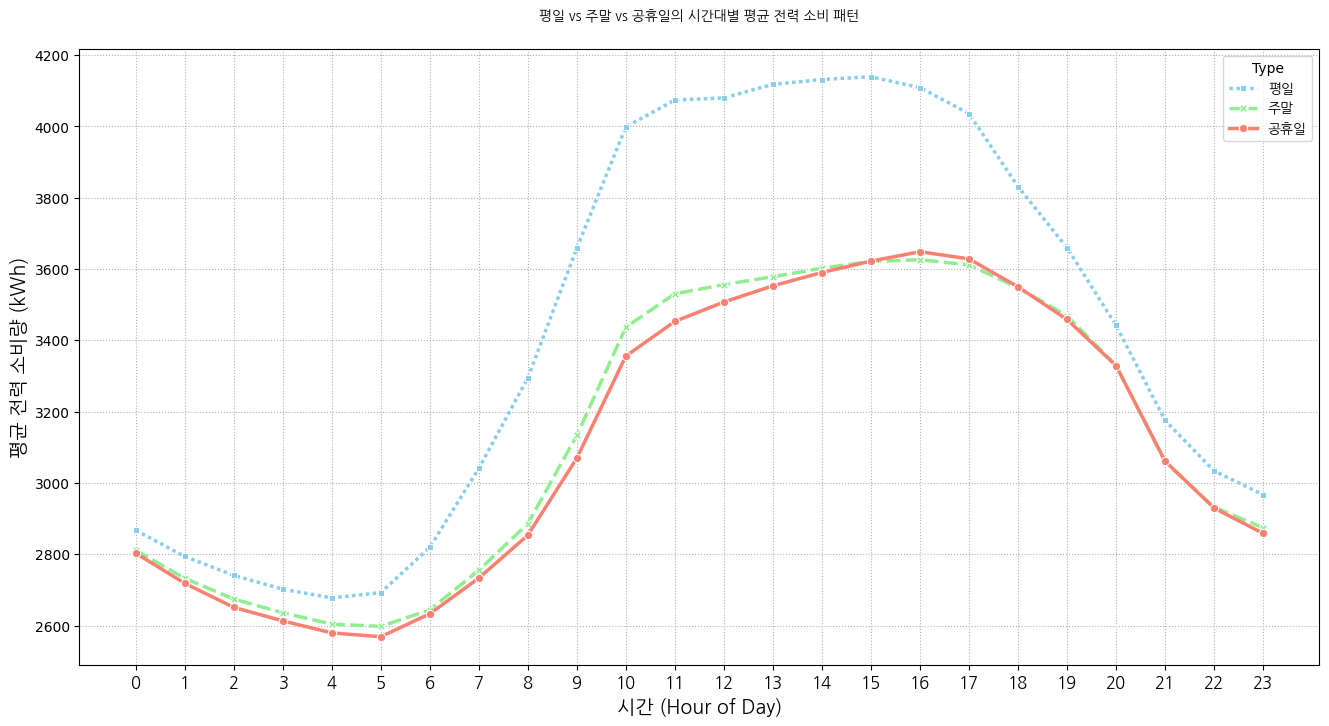

시각화가 완료되었습니다.


In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import urllib.request
from matplotlib import font_manager

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 폰트 직접 다운로드 및 경로 지정 ---
font_path = 'NanumGothic.ttf'
if not os.path.exists(font_path):
    print("나눔고딕 폰트를 다운로드합니다...")
    url = 'https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf'
    try:
        urllib.request.urlretrieve(url, font_path)
        print("폰트 다운로드 완료.")
    except Exception as e:
        print(f"폰트 다운로드 중 오류가 발생했습니다: {e}")
        font_path = None
if font_path:
    font_prop = font_manager.FontProperties(fname=font_path)
    print(f"'{font_path}' 폰트를 그래프에 적용합니다.")
else:
    font_prop = None
    print("한글 폰트를 설정할 수 없어, 텍스트가 깨질 수 있습니다.")
plt.rcParams['axes.unicode_minus'] = False


# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")

# --- 2. Data Preparation ---
print("시각화를 위한 데이터를 준비합니다...")
eda_df = train_df.copy()

# 평일/주말/공휴일 구분 변수 생성
eda_df['일시_dt'] = pd.to_datetime(eda_df['일시'], format='%Y%m%d %H')
eda_df['weekday'] = eda_df['일시_dt'].dt.weekday
eda_df['hour'] = eda_df['일시_dt'].dt.hour # 시간대별 분석을 위해 hour 컬럼 추가
holidays = ['2024-06-06', '2024-08-15']
eda_df['is_holiday'] = eda_df['일시_dt'].dt.date.astype(str).isin(holidays)

def get_day_type(row):
    if row['is_holiday']:
        return '공휴일'
    elif row['weekday'] >= 5:
        return '주말'
    else:
        return '평일'
eda_df['day_type'] = eda_df.apply(get_day_type, axis=1)


# --- 3. Data Aggregation ---
print("유형별/시간대별 평균 전력 소비량을 계산합니다...")
# --- ★★★ 핵심 수정 사항: 시간대별로 그룹화 추가 ★★★ ---
# day_type과 hour로 그룹화하여 시간대별 평균 소비량을 계산합니다.
avg_power_by_hour = eda_df.groupby(['day_type', 'hour'])['전력소비량(kWh)'].mean().reset_index()


# --- 4. Visualization: 꺾은선 그래프로 패턴 비교 ---
print("평일, 주말, 공휴일의 시간대별 전력 소비 패턴을 시각화합니다...")

plt.figure(figsize=(16, 8))

# --- ★★★ 핵심 수정 사항: 꺾은선 그래프(lineplot)로 변경 ★★★ ---
sns.lineplot(
    data=avg_power_by_hour,
    x='hour',
    y='전력소비량(kWh)',
    hue='day_type', # day_type에 따라 다른 색상의 선을 그림
    hue_order=['평일', '주말', '공휴일'], # 범례 순서 지정
    style='day_type', # day_type에 따라 다른 스타일의 선을 그림
    markers=True, # 각 점을 표시
    linewidth=2.5,
    palette={'평일': 'skyblue', '주말': 'lightgreen', '공휴일': 'salmon'}
)

# 제목 및 라벨 설정
if font_prop:
    plt.title('평일 vs 주말 vs 공휴일의 시간대별 평균 전력 소비 패턴', fontsize=22, pad=20, fontproperties=font_prop)
    plt.xlabel('시간 (Hour of Day)', fontsize=14, fontproperties=font_prop)
    plt.ylabel('평균 전력 소비량 (kWh)', fontsize=14, fontproperties=font_prop)
    plt.xticks(np.arange(0, 24, 1), fontproperties=font_prop, fontsize=12) # x축을 0-23시로 설정
    plt.legend(title='Type', prop=font_prop, fontsize=12)
else:
    plt.title('Average Hourly Power Consumption Pattern', fontsize=22, pad=20)
    plt.xlabel('Hour of Day', fontsize=14)
    plt.ylabel('Average Power Consumption (kWh)', fontsize=14)
    plt.xticks(np.arange(0, 24, 1), fontsize=12)
    plt.legend(title='분류', fontsize=12)

plt.grid(True, linestyle=':')
plt.show()

print("시각화가 완료되었습니다.")



'NanumGothic.ttf' 폰트를 그래프에 적용합니다.
데이터를 불러오는 중입니다...
데이터 로딩 완료.
분석을 위한 데이터를 준비합니다...

분석을 위한 XGBoost 모델을 학습합니다...
모델 학습 완료.

부분 의존성 그림(PDP) 생성을 시작합니다...


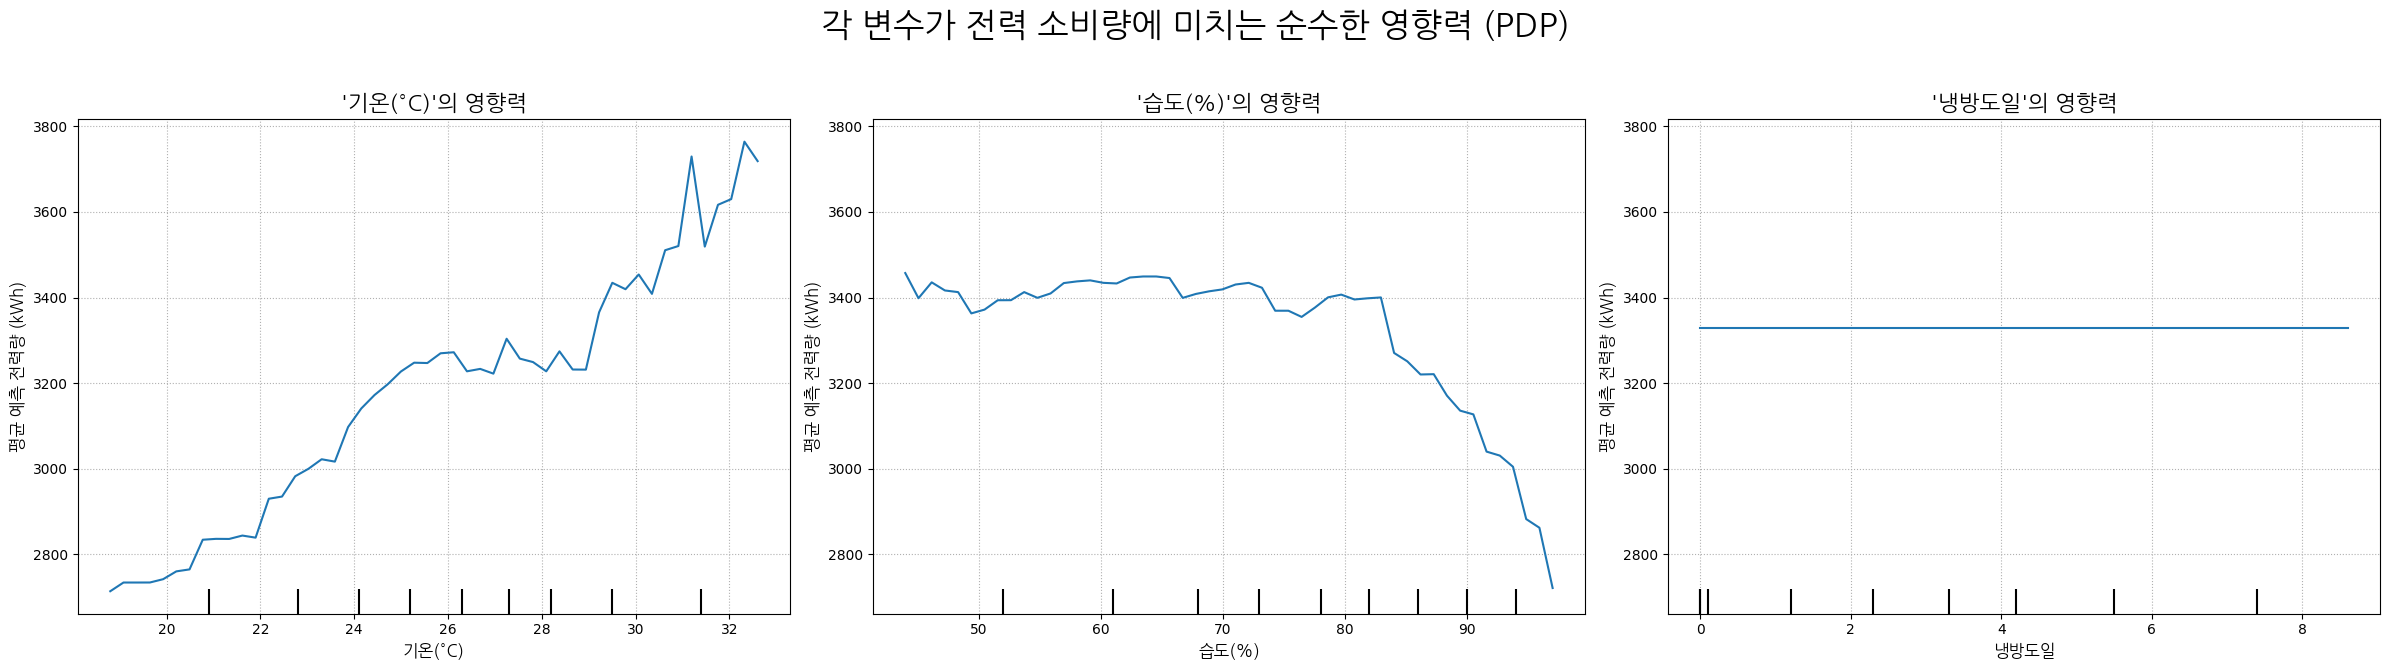


시각화가 완료되었습니다.


In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay # PDP를 위한 라이브러리
import warnings
import os
import urllib.request
from matplotlib import font_manager

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 폰트 직접 다운로드 및 경로 지정 ---
font_path = 'NanumGothic.ttf'
if not os.path.exists(font_path):
    print("나눔고딕 폰트를 다운로드합니다...")
    url = 'https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf'
    try:
        urllib.request.urlretrieve(url, font_path)
        print("폰트 다운로드 완료.")
    except Exception as e:
        print(f"폰트 다운로드 중 오류가 발생했습니다: {e}")
        font_path = None
if font_path:
    font_prop = font_manager.FontProperties(fname=font_path)
    print(f"'{font_path}' 폰트를 그래프에 적용합니다.")
else:
    font_prop = None
    print("한글 폰트를 설정할 수 없어, 텍스트가 깨질 수 있습니다.")
plt.rcParams['axes.unicode_minus'] = False


# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")

# --- 2. Data Preparation & Feature Engineering ---
print("분석을 위한 데이터를 준비합니다...")
# --- ★★★ 핵심 수정 사항: 전체 데이터를 모두 사용 ★★★ ---
# .sample() 부분을 제거하여 모든 학습 데이터를 분석에 포함합니다.
# (주의: 계산 시간이 길어질 수 있습니다.)
eda_df = pd.merge(train_df, building_info_df, on='건물번호', how='left')

# 최종 모델과 유사한 기본 변수들을 생성합니다.
eda_df['일시_dt'] = pd.to_datetime(eda_df['일시'], format='%Y%m%d %H')
eda_df['hour'] = eda_df['일시_dt'].dt.hour
eda_df['weekday'] = eda_df['일시_dt'].dt.weekday
best_bp = 24
eda_df['냉방도일'] = (eda_df['기온(°C)'] > best_bp) * (eda_df['기온(°C)'] - best_bp)
eda_df = pd.get_dummies(eda_df, columns=['건물유형'], drop_first=True)


# --- 3. 모델 학습 ---
print("\n분석을 위한 XGBoost 모델을 학습합니다...")

# PDP 분석에 사용할 변수 리스트
features_to_analyze = ['기온(°C)', '습도(%)', '냉방도일']
other_features = ['hour', 'weekday', '강수량(mm)', '풍속(m/s)'] + [col for col in eda_df.columns if '건물유형_' in col]
all_features = features_to_analyze + other_features

X = eda_df[all_features]
y = eda_df['전력소비량(kWh)']

# 모델 학습
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=--1)
model.fit(X, y)
print("모델 학습 완료.")


# --- 4. Visualization: Partial Dependence Plots ---
print("\n부분 의존성 그림(PDP) 생성을 시작합니다...")

fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('각 변수가 전력 소비량에 미치는 순수한 영향력 (PDP)', fontsize=24, fontproperties=font_prop if font_prop else None)

# PDP 생성 및 시각화
# features: 분석하고 싶은 변수
# grid_resolution: 얼마나 세밀하게 x축을 나눌지
display = PartialDependenceDisplay.from_estimator(
    model,
    X,
    features=features_to_analyze,
    kind='average', # 'average'는 PDP를 의미
    grid_resolution=50,
    ax=axes
)

# 각 그래프에 대한 추가 설정
titles = ['기온(°C)', '습도(%)', '냉방도일']
for i, ax in enumerate(axes):
    if font_prop:
        ax.set_title(f"'{titles[i]}'의 영향력", fontproperties=font_prop, fontsize=16)
        ax.set_xlabel(titles[i], fontproperties=font_prop, fontsize=12)
        ax.set_ylabel('평균 예측 전력량 (kWh)', fontproperties=font_prop, fontsize=12)
    ax.grid(True, linestyle=':')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\n시각화가 완료되었습니다.")



'NanumGothic.ttf' 폰트를 그래프에 적용합니다.
데이터를 불러오는 중입니다...
데이터 로딩 완료.
온도별 평균 전력 소비량을 계산합니다...
전력 소비량 임계점(Threshold) 시각화를 시작합니다...


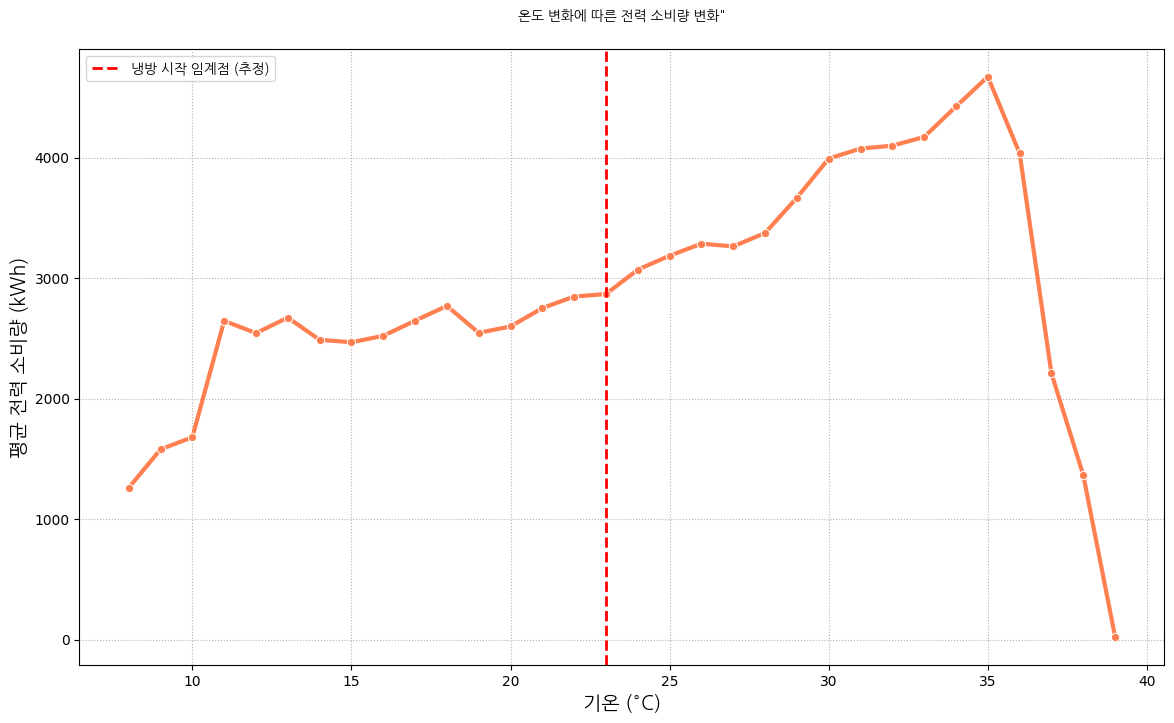

시각화가 완료되었습니다.


In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import urllib.request
from matplotlib import font_manager

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 폰트 직접 다운로드 및 경로 지정 ---
font_path = 'NanumGothic.ttf'
if not os.path.exists(font_path):
    print("나눔고딕 폰트를 다운로드합니다...")
    url = 'https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf'
    try:
        urllib.request.urlretrieve(url, font_path)
        print("폰트 다운로드 완료.")
    except Exception as e:
        print(f"폰트 다운로드 중 오류가 발생했습니다: {e}")
        font_path = None
if font_path:
    font_prop = font_manager.FontProperties(fname=font_path)
    print(f"'{font_path}' 폰트를 그래프에 적용합니다.")
else:
    font_prop = None
    print("한글 폰트를 설정할 수 없어, 텍스트가 깨질 수 있습니다.")
plt.rcParams['axes.unicode_minus'] = False


# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")

# --- 2. Data Aggregation ---
print("온도별 평균 전력 소비량을 계산합니다...")

# --- ★★★ 핵심 1: 데이터 단순화 ★★★ ---
# 분석을 위해 기온을 정수 단위로 반올림하여 그룹화합니다.
eda_df = train_df.copy()
eda_df['기온_rounded'] = eda_df['기온(°C)'].round()

# 각 온도별로 평균 전력 소비량을 계산합니다.
temp_vs_power = eda_df.groupby('기온_rounded')['전력소비량(kWh)'].mean().reset_index()


# --- 3. Visualization: "문턱 효과"의 명확한 증명 ---
print("전력 소비량 임계점(Threshold) 시각화를 시작합니다...")

plt.figure(figsize=(14, 8))

# --- ★★★ 핵심 2: 단순 꺾은선 그래프로 추세 시각화 ★★★ ---
sns.lineplot(
    data=temp_vs_power,
    x='기온_rounded',
    y='전력소비량(kWh)',
    marker='o', # 각 평균 지점을 동그라미로 표시
    linewidth=3,
    color='coral'
)

# 임계점을 시각적으로 강조
plt.axvline(x=23, color='red', linestyle='--', linewidth=2, label='냉방 시작 임계점 (추정)')

# 그래프 해석을 돕는 텍스트와 화살표
if font_prop:
    plt.title('온도 변화에 따른 전력 소비량 변화"', fontsize=22, pad=20, fontproperties=font_prop)
    plt.xlabel('기온 (°C)', fontsize=14, fontproperties=font_prop)
    plt.ylabel('평균 전력 소비량 (kWh)', fontsize=14, fontproperties=font_prop)
    plt.legend(prop=font_prop, fontsize=12)

    # 화살표와 텍스트로 패턴 변화를 명확히 표시

else:
    plt.title('"Threshold Effect" of Average Power Consumption by Temperature', fontsize=22, pad=20)
    plt.xlabel('Temperature (°C)', fontsize=14)
    plt.ylabel('Average Power Consumption (kWh)', fontsize=14)
    plt.legend(fontsize=12)

plt.grid(True, linestyle=':')
plt.show()

print("시각화가 완료되었습니다.")


In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import urllib.request
from matplotlib import font_manager

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 폰트 직접 다운로드 및 경로 지정 ---
font_path = 'NanumGothic.ttf'
if not os.path.exists(font_path):
    print("나눔고딕 폰트를 다운로드합니다...")
    url = 'https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf'
    try:
        urllib.request.urlretrieve(url, font_path)
        print("폰트 다운로드 완료.")
    except Exception as e:
        print(f"폰트 다운로드 중 오류가 발생했습니다: {e}")
        font_path = None
if font_path:
    font_prop = font_manager.FontProperties(fname=font_path)
    print(f"'{font_path}' 폰트를 그래프에 적용합니다.")
else:
    font_prop = None
    print("한글 폰트를 설정할 수 없어, 텍스트가 깨질 수 있습니다.")
plt.rcParams['axes.unicode_minus'] = False


# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")

# --- 2. Data Aggregation ---
print("온도별 평균 전력 소비량을 계산합니다...")

# 분석을 위해 기온을 정수 단위로 반올림하여 그룹화합니다.
eda_df = train_df.copy()
eda_df['기온_rounded'] = eda_df['기온(°C)'].round()

# 각 온도별로 평균 전력 소비량을 계산합니다.
temp_vs_power = eda_df.groupby('기온_rounded')['전력소비량(kWh)'].mean().reset_index()


# --- 3. Visualization: "문턱 효과" 시각화 ---
print("평균 전력 소비량의 '문턱 효과'를 시각화합니다...")

plt.figure(figsize=(14, 8))

sns.lineplot(data=temp_vs_power, x='기온_rounded', y='전력소비량(kWh)', marker='o', linewidth=3, color='coral')

# --- ★★★ 핵심 수정 사항: 임계점을 23°C로 변경 ★★★ ---
plt.axvline(x=23, color='red', linestyle='--', linewidth=2, label='냉방 시작 임계점 (23°C 가설)')

if font_prop:
    plt.title('평균 전력 소비량의 "문턱 효과"', fontsize=22, pad=20, fontproperties=font_prop)
    plt.xlabel('기온 (°C)', fontsize=14, fontproperties=font_prop)
    plt.ylabel('평균 전력 소비량 (kWh)', fontsize=14, fontproperties=font_prop)
    plt.legend(prop=font_prop)
else:
    plt.title('"Threshold Effect" of Average Power Consumption', fontsize=22, pad=20)
    plt.xlabel('Temperature (°C)', fontsize=14)
    plt.ylabel('Average Power Consumption (kWh)', fontsize=14)
    plt.legend()

plt.grid(True, linestyle=':')
plt.show()

print("시각화가 완료되었습니다.")



나눔고딕 폰트를 다운로드합니다...
폰트 다운로드 완료.
'NanumGothic.ttf' 폰트를 그래프에 적용합니다.
데이터를 불러오는 중입니다...
오류: 'train.csv' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.
데이터 로딩 완료.
온도별 평균 전력 소비량을 계산합니다...


NameError: name 'train_df' is not defined

'NanumGothic.ttf' 폰트를 그래프에 적용합니다.
데이터를 불러오는 중입니다...
데이터 로딩 완료.
온도별 평균 전력 소비량 및 증가율을 계산합니다...
기온 1°C 상승 시 전력 소비량 '증가율'을 시각화합니다...


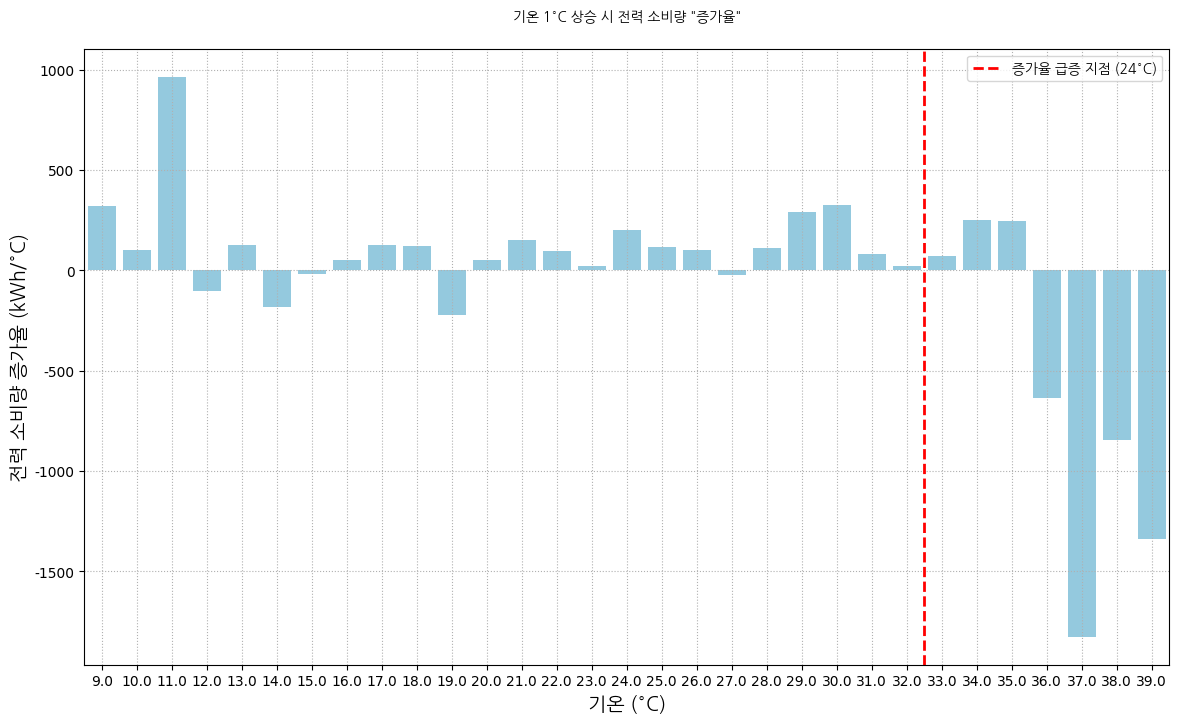

시각화가 완료되었습니다.


In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import urllib.request
from matplotlib import font_manager

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 폰트 직접 다운로드 및 경로 지정 ---
font_path = 'NanumGothic.ttf'
if not os.path.exists(font_path):
    print("나눔고딕 폰트를 다운로드합니다...")
    url = 'https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf'
    try:
        urllib.request.urlretrieve(url, font_path)
        print("폰트 다운로드 완료.")
    except Exception as e:
        print(f"폰트 다운로드 중 오류가 발생했습니다: {e}")
        font_path = None
if font_path:
    font_prop = font_manager.FontProperties(fname=font_path)
    print(f"'{font_path}' 폰트를 그래프에 적용합니다.")
else:
    font_prop = None
    print("한글 폰트를 설정할 수 없어, 텍스트가 깨질 수 있습니다.")
plt.rcParams['axes.unicode_minus'] = False


# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")

# --- 2. Data Aggregation ---
print("온도별 평균 전력 소비량 및 증가율을 계산합니다...")

# 분석을 위해 기온을 정수 단위로 반올림하여 그룹화합니다.
eda_df = train_df.copy()
eda_df['기온_rounded'] = eda_df['기온(°C)'].round()

# 각 온도별로 평균 전력 소비량을 계산합니다.
temp_vs_power = eda_df.groupby('기온_rounded')['전력소비량(kWh)'].mean().reset_index()

# 온도별 전력 소비량 증가율 계산
temp_vs_power['증가율(kWh/°C)'] = temp_vs_power['전력소비량(kWh)'].diff()


# --- 3. Visualization: "증가율" 시각화 ---
print("기온 1°C 상승 시 전력 소비량 '증가율'을 시각화합니다...")

plt.figure(figsize=(14, 8))

sns.barplot(data=temp_vs_power.dropna(), x='기온_rounded', y='증가율(kWh/°C)', color='skyblue')
plt.axvline(x=23.5, color='red', linestyle='--', linewidth=2, label='증가율 급증 지점 (24°C)')

if font_prop:
    plt.title('기온 1°C 상승 시 전력 소비량 "증가율"', fontsize=22, pad=20, fontproperties=font_prop)
    plt.xlabel('기온 (°C)', fontsize=14, fontproperties=font_prop)
    plt.ylabel('전력 소비량 증가율 (kWh/°C)', fontsize=14, fontproperties=font_prop)
    plt.legend(prop=font_prop)
else:
    plt.title('Rate of Increase in Power Consumption per 1°C Rise', fontsize=22, pad=20)
    plt.xlabel('Temperature (°C)', fontsize=14)
    plt.ylabel('Increase Rate (kWh/°C)', fontsize=14)
    plt.legend()

plt.grid(True, linestyle=':')
plt.show()

print("시각화가 완료되었습니다.")


'NanumGothic.ttf' 폰트를 그래프에 적용합니다.
데이터를 불러오는 중입니다...
데이터 로딩 완료.
분석을 위한 데이터를 준비합니다...

두 모델의 예측 성능(RMSE)을 비교합니다...
  - 모델 A (기온+습도 사용) 학습 중...
    -> 완료. RMSE: 2615.051
  - 모델 B (체감온도 사용) 학습 중...
    -> 완료. RMSE: 2658.786

RMSE 비교를 위한 시각화를 시작합니다...


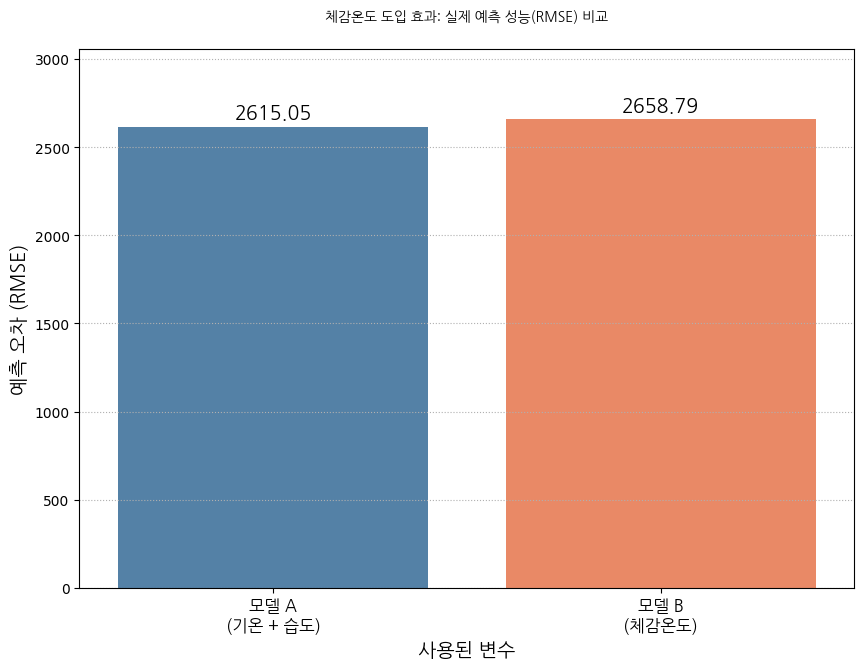


시각화가 완료되었습니다.


In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
import os
import urllib.request
from matplotlib import font_manager

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 폰트 직접 다운로드 및 경로 지정 ---
font_path = 'NanumGothic.ttf'
if not os.path.exists(font_path):
    print("나눔고딕 폰트를 다운로드합니다...")
    url = 'https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf'
    try:
        urllib.request.urlretrieve(url, font_path)
        print("폰트 다운로드 완료.")
    except Exception as e:
        print(f"폰트 다운로드 중 오류가 발생했습니다: {e}")
        font_path = None
if font_path:
    font_prop = font_manager.FontProperties(fname=font_path)
    print(f"'{font_path}' 폰트를 그래프에 적용합니다.")
else:
    font_prop = None
    print("한글 폰트를 설정할 수 없어, 텍스트가 깨질 수 있습니다.")
plt.rcParams['axes.unicode_minus'] = False


# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")

# --- 2. Data Preparation & Feature Engineering ---
print("분석을 위한 데이터를 준비합니다...")
eda_df = pd.merge(train_df, building_info_df, on='건물번호', how='left')

# 기본 시간 변수 및 체감온도 생성
eda_df['일시_dt'] = pd.to_datetime(eda_df['일시'], format='%Y%m%d %H')
eda_df['hour'] = eda_df['일시_dt'].dt.hour
eda_df['weekday'] = eda_df['일시_dt'].dt.weekday

def calculate_apparent_temp_kma(temp, humidity):
    Ta = temp; RH = humidity
    Tw = Ta * np.arctan(0.151977 * (RH + 8.313659)**0.5) + np.arctan(Ta + RH) - np.arctan(RH - 1.676331) + 0.00391838 * (RH**1.5) * np.arctan(0.023101 * RH) - 4.686035
    apparent_temp = -0.2442 + 0.55399*Tw + 0.45535*Ta - 0.0022*(Tw**2) + 0.00278*(Tw*Ta) + 3.0
    return np.where(apparent_temp < Ta, Ta, apparent_temp)
eda_df['체감온도_KMA'] = calculate_apparent_temp_kma(eda_df['기온(°C)'], eda_df['습도(%)'])

# 범주형 변수 처리
eda_df = pd.get_dummies(eda_df, columns=['건물유형'], drop_first=True)


# --- 3. 모델 성능 비교 (RMSE) ---
print("\n두 모델의 예측 성능(RMSE)을 비교합니다...")

# 공통 변수 및 타겟 변수 정의
y = eda_df['전력소비량(kWh)']
common_features = ['hour', 'weekday', '강수량(mm)', '풍속(m/s)'] + [col for col in eda_df.columns if '건물유형_' in col]

# --- 모델 A: 기온, 습도를 개별적으로 사용 ---
print("  - 모델 A (기온+습도 사용) 학습 중...")
features_A = ['기온(°C)', '습도(%)'] + common_features
X_A = eda_df[features_A]
X_train_A, X_val_A, y_train, y_val = train_test_split(X_A, y, test_size=0.2, random_state=42)
model_A = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1, n_estimators=200, learning_rate=0.1)
model_A.fit(X_train_A, y_train)
pred_A = model_A.predict(X_val_A)
rmse_A = np.sqrt(mean_squared_error(y_val, pred_A))
print(f"    -> 완료. RMSE: {rmse_A:.3f}")

# --- 모델 B: 체감온도만 사용 ---
print("  - 모델 B (체감온도 사용) 학습 중...")
features_B = ['체감온도_KMA'] + common_features
X_B = eda_df[features_B]
# 동일한 데이터 분할을 위해 인덱스를 사용
X_train_B, X_val_B = X_B.loc[X_train_A.index], X_B.loc[X_val_A.index]
model_B = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1, n_estimators=200, learning_rate=0.1)
model_B.fit(X_train_B, y_train)
pred_B = model_B.predict(X_val_B)
rmse_B = np.sqrt(mean_squared_error(y_val, pred_B))
print(f"    -> 완료. RMSE: {rmse_B:.3f}")


# --- 4. Visualization: RMSE 막대그래프 비교 ---
print("\nRMSE 비교를 위한 시각화를 시작합니다...")

plt.figure(figsize=(10, 7))
rmse_data = pd.DataFrame({
    '모델': ['모델 A\n(기온 + 습도)', '모델 B\n(체감온도)'],
    'RMSE': [rmse_A, rmse_B]
})

barplot = sns.barplot(data=rmse_data, x='모델', y='RMSE', palette=['steelblue', 'coral'])

# 각 막대 위에 RMSE 값 표시
for p in barplot.patches:
    barplot.annotate(
        format(p.get_height(), '.2f'),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha = 'center', va = 'center',
        xytext = (0, 10),
        textcoords = 'offset points',
        fontproperties=font_prop if font_prop else None,
        fontsize=14
    )

if font_prop:
    plt.title('체감온도 도입 효과: 실제 예측 성능(RMSE) 비교', fontsize=20, pad=20, fontproperties=font_prop)
    plt.xlabel('사용된 변수', fontsize=14, fontproperties=font_prop)
    plt.ylabel('예측 오차 (RMSE)', fontsize=14, fontproperties=font_prop)
    plt.xticks(fontproperties=font_prop, fontsize=12)
else:
    plt.title('Effect of Apparent Temp: Predictive Performance (RMSE) Comparison', fontsize=20, pad=20)
    plt.xlabel('Features Used', fontsize=14)
    plt.ylabel('Prediction Error (RMSE)', fontsize=14)

plt.ylim(0, max(rmse_A, rmse_B) * 1.15)
plt.grid(axis='y', linestyle=':')
plt.show()

print("\n시각화가 완료되었습니다.")



In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    test_df = pd.read_csv('test.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
    submission = pd.read_csv('sample_submission.csv')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")


# --- 2. Feature Engineering & Preprocessing ---
print("Feature Engineering을 시작합니다...")

# 건물 그룹 정의
special_types = ['IDC(전화국)', '호텔', '병원']
building_info_df['group'] = building_info_df['건물유형'].apply(lambda x: 'Special' if x in special_types else 'General')

# Combine train and test for consistent feature creation
test_df['전력소비량(kWh)'] = np.nan
all_df = pd.concat([train_df, test_df], ignore_index=True)

# Merge building info early
all_df = pd.merge(all_df, building_info_df, on='건물번호', how='left')

# 파생변수 생성
holidays = ['2024-06-06', '2024-08-15', '2025-06-06', '2025-08-15']
all_df['일시_dt'] = pd.to_datetime(all_df['일시'], format='%Y%m%d %H')
all_df['is_holiday'] = all_df['일시_dt'].dt.date.astype(str).isin(holidays).astype(int)
best_bp = 24
all_df['냉방도일'] = (all_df['기온(°C)'] > best_bp) * (all_df['기온(°C)'] - best_bp)

# --- ★★★ 핵심 수정 사항: '체감온도' 대신 '기온'과 '습도'를 그대로 사용 ★★★ ---
# EDA 결과에 따라, XGBoost가 스스로 학습하도록 원본 변수를 유지합니다.
print("  - '체감온도' 대신 '기온'과 '습도' 원본 변수를 사용합니다...")

all_df['month'] = all_df['일시_dt'].dt.month
all_df['day'] = all_df['일시_dt'].dt.day
all_df['hour'] = all_df['일시_dt'].dt.hour
all_df['weekday'] = all_df['일시_dt'].dt.weekday

# 요일 원-핫 인코딩
all_df = pd.get_dummies(all_df, columns=['weekday'], prefix='weekday')

# Lag Features (Short & Long term)
all_df = all_df.sort_values(by=['건물번호', '일시'])
all_df['lag_24h'] = all_df.groupby('건물번호')['전력소비량(kWh)'].shift(24)
all_df['lag_168h'] = all_df.groupby('건물번호')['전력소비량(kWh)'].shift(168)
all_df['lag_1h'] = all_df.groupby('건물번호')['전력소비량(kWh)'].shift(1)
all_df['lag_3h'] = all_df.groupby('건물번호')['전력소비량(kWh)'].shift(3)

# Interaction Features for General group
all_df = pd.get_dummies(all_df, columns=['건물유형'], prefix='b_type')
b_type_cols = [col for col in all_df.columns if 'b_type_' in col]
for b_type in b_type_cols:
    # 상호작용 변수도 '기온'을 기반으로 생성
    all_df[f'temp_x_{b_type}'] = all_df['기온(°C)'] * all_df[b_type]

# 최종 데이터셋 준비
all_df.fillna(method='bfill', inplace=True)
# '체감온도'를 만드는 데 사용했던 '풍속'은 제거, '기온'과 '습도'는 유지
all_df = all_df.drop(columns=['풍속(m/s)', '일시_dt'])
train_processed_df = all_df[all_df['전력소비량(kWh)'].notna()].copy()
test_processed_df = all_df[all_df['전력소비량(kWh)'].isna()].drop(columns=['전력소비량(kWh)'])

# Winsorizing
print("  - 전력소비량 이상치를 처리합니다 (Winsorizing)...")
for building_num in train_processed_df['건물번호'].unique():
    subset_mask = train_processed_df['건물번호'] == building_num
    power_consumption = train_processed_df.loc[subset_mask, '전력소비량(kWh)']
    p01 = power_consumption.quantile(0.01)
    p99 = power_consumption.quantile(0.99)
    train_processed_df.loc[subset_mask, '전력소비량(kWh)'] = power_consumption.clip(p01, p99)

train_final_df = train_processed_df
test_final_df = test_processed_df
for df in [train_final_df, test_final_df]:
    for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
        if col in df.columns:
             df[col] = df[col].replace('-', 0).astype(float).fillna(0)

target = '전력소비량(kWh)'
train_cols = [col for col in train_final_df.columns if col != target]
test_final_df = test_final_df.reindex(columns=train_cols, fill_value=0)

# 그룹별 변수 리스트 재정의
base_features = [col for col in train_cols if 'temp_x_b_type' not in col and col not in ['num_date_time', '일시', 'group']]
interaction_features = [col for col in train_cols if 'temp_x_b_type' in col]
general_features = base_features + interaction_features
special_features = base_features
print("Feature Engineering 완료.")


# --- 3. Model Evaluation & Prediction ---
evaluation_results = []
all_predictions = []
print("\n각 건물별 모델 학습, 평가 및 예측을 시작합니다...")

for building_num in range(1, 101):
    train_building = train_final_df[train_final_df['건물번호'] == building_num]
    test_building = test_final_df[test_final_df['건물번호'] == building_num]

    building_group = train_building['group'].iloc[0]
    features = special_features if building_group == 'Special' else general_features

    X = train_building[features]
    y = train_building[target]
    X_test = test_building[features]

    # Part 1: Model Evaluation
    X_train_split, X_val, y_train_split, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    eval_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, early_stopping_rounds=50)
    eval_model.fit(X_train_split, y_train_split, eval_set=[(X_val, y_val)], verbose=False)
    y_pred = eval_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    evaluation_results.append({'건물번호': building_num, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

    # Part 2: Final Prediction for Submission
    final_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
    final_model.fit(X, y)
    final_preds = final_model.predict(X_test)

    pred_df = pd.DataFrame({'num_date_time': test_building['num_date_time'], 'answer': final_preds})
    all_predictions.append(pred_df)

    if building_num % 10 == 0:
        print(f"  ... {building_num}번 건물 ({building_group} 그룹) 처리 완료.")

# --- 4. Evaluation Result Display & Submission File Creation ---
print("\n--- 모델 성능 평가 결과 (EDA 최종 반영 후) ---")
results_df = pd.DataFrame(evaluation_results)
average_performance = results_df.drop(columns='건물번호').mean()
print(f"Average RMSE (평균 오차): {average_performance['RMSE']:.3f} kWh")
print(f"Average MAE (평균 절대 오차): {average_performance['MAE']:.3f} kWh")
print(f"Average R2 Score (모델 설명력): {average_performance['R2']:.3f}")

final_submission_df = pd.concat(all_predictions, ignore_index=True)
submission = submission.drop(columns='answer').merge(final_submission_df, on='num_date_time', how='left')
submission.to_csv('submission_final.csv', index=False)
print("\n제출 파일 'submission_final.csv'이(가) 성공적으로 생성되었습니다!")


데이터를 불러오는 중입니다...
데이터 로딩 완료.
Feature Engineering을 시작합니다...
  - '체감온도' 대신 '기온'과 '습도' 원본 변수를 사용합니다...
  - 전력소비량 이상치를 처리합니다 (Winsorizing)...
Feature Engineering 완료.

각 건물별 모델 학습, 평가 및 예측을 시작합니다...
  ... 10번 건물 (Special 그룹) 처리 완료.
  ... 20번 건물 (General 그룹) 처리 완료.
  ... 30번 건물 (Special 그룹) 처리 완료.
  ... 40번 건물 (General 그룹) 처리 완료.
  ... 50번 건물 (General 그룹) 처리 완료.
  ... 60번 건물 (General 그룹) 처리 완료.
  ... 70번 건물 (General 그룹) 처리 완료.
  ... 80번 건물 (General 그룹) 처리 완료.
  ... 90번 건물 (Special 그룹) 처리 완료.
  ... 100번 건물 (Special 그룹) 처리 완료.

--- 모델 성능 평가 결과 (EDA 최종 반영 후) ---
Average RMSE (평균 오차): 121.100 kWh
Average MAE (평균 절대 오차): 69.132 kWh
Average R2 Score (모델 설명력): 0.984

제출 파일 'submission_final.csv'이(가) 성공적으로 생성되었습니다!


나눔고딕 폰트를 다운로드합니다...
폰트 다운로드 완료.
'NanumGothic.ttf' 폰트를 그래프에 적용합니다.
데이터를 불러오는 중입니다...
데이터 로딩 완료.
분석을 위한 데이터를 준비합니다...
자기상관함수(ACF) 그래프를 생성합니다...


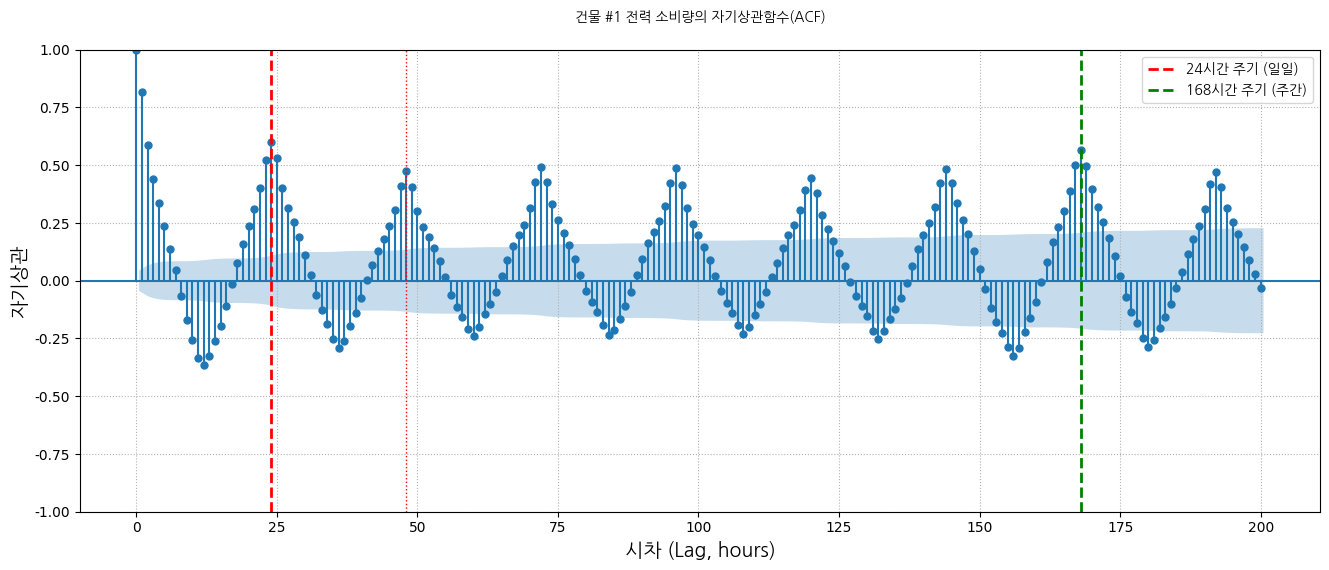


시각화가 완료되었습니다.

[그래프 해석]
파란색 음영 영역은 신뢰구간을 의미하며, 이 영역을 벗어나는 막대는 통계적으로 유의미한 상관관계가 있음을 나타냅니다.
Lag 24, 48, 72... 등 24의 배수 지점에서 높은 상관관계를 보이는 것은 강력한 '일일 주기성'의 증거입니다.
Lag 168 지점에서도 높은 상관관계를 보이는 것은 '주간 주기성'이 존재함을 의미합니다.


In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import warnings
import os
import urllib.request
from matplotlib import font_manager

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 폰트 직접 다운로드 및 경로 지정 ---
font_path = 'NanumGothic.ttf'
if not os.path.exists(font_path):
    print("나눔고딕 폰트를 다운로드합니다...")
    url = 'https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf'
    try:
        urllib.request.urlretrieve(url, font_path)
        print("폰트 다운로드 완료.")
    except Exception as e:
        print(f"폰트 다운로드 중 오류가 발생했습니다: {e}")
        font_path = None
if font_path:
    font_prop = font_manager.FontProperties(fname=font_path)
    print(f"'{font_path}' 폰트를 그래프에 적용합니다.")
else:
    font_prop = None
    print("한글 폰트를 설정할 수 없어, 텍스트가 깨질 수 있습니다.")
plt.rcParams['axes.unicode_minus'] = False


# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")

# --- 2. Data Preparation ---
print("분석을 위한 데이터를 준비합니다...")
# 대표 건물 선택 (예: 1번 건물)
building_num_to_analyze = 1
building_df = train_df[train_df['건물번호'] == building_num_to_analyze].copy()
building_df['일시'] = pd.to_datetime(building_df['일시'], format='%Y%m%d %H')
building_df = building_df.set_index('일시')

# 분석할 시계열 데이터 선택
power_series = building_df['전력소비량(kWh)']


# --- 3. Visualization: Autocorrelation Function (ACF) Plot ---
print("자기상관함수(ACF) 그래프를 생성합니다...")

# ACF를 계산하고 시각화합니다.
# lags 파라미터를 통해 확인할 최대 시차(lag)를 지정합니다. (예: 200시간)
fig, ax = plt.subplots(figsize=(16, 6))
plot_acf(power_series, ax=ax, lags=200)

# --- ★★★ 핵심: 주요 주기성 지점 강조 ★★★ ---
plt.axvline(x=24, color='red', linestyle='--', linewidth=2, label='24시간 주기 (일일)')
plt.axvline(x=48, color='red', linestyle=':', linewidth=1)
plt.axvline(x=168, color='green', linestyle='--', linewidth=2, label='168시간 주기 (주간)')


# 제목 및 라벨 설정
if font_prop:
    plt.title(f'건물 #{building_num_to_analyze} 전력 소비량의 자기상관함수(ACF)', fontsize=20, pad=20, fontproperties=font_prop)
    plt.xlabel('시차 (Lag, hours)', fontsize=14, fontproperties=font_prop)
    plt.ylabel('자기상관', fontsize=14, fontproperties=font_prop)
    plt.legend(prop=font_prop, fontsize=12)
else:
    plt.title(f'Autocorrelation Function (ACF) for Building #{building_num_to_analyze}', fontsize=20, pad=20)
    plt.xlabel('Lag (hours)', fontsize=14)
    plt.ylabel('Autocorrelation', fontsize=14)
    plt.legend(fontsize=12)

plt.grid(True, linestyle=':')
plt.show()

print("\n시각화가 완료되었습니다.")
print("\n[그래프 해석]")
print("파란색 음영 영역은 신뢰구간을 의미하며, 이 영역을 벗어나는 막대는 통계적으로 유의미한 상관관계가 있음을 나타냅니다.")
print("Lag 24, 48, 72... 등 24의 배수 지점에서 높은 상관관계를 보이는 것은 강력한 '일일 주기성'의 증거입니다.")
print("Lag 168 지점에서도 높은 상관관계를 보이는 것은 '주간 주기성'이 존재함을 의미합니다.")



'NanumGothic.ttf' 폰트를 그래프에 적용합니다.
데이터를 불러오는 중입니다...
데이터 로딩 완료.
시각화를 위한 데이터를 준비합니다...
모든 건물 유형의 시간대별 평균 전력 소비 패턴을 시각화합니다...


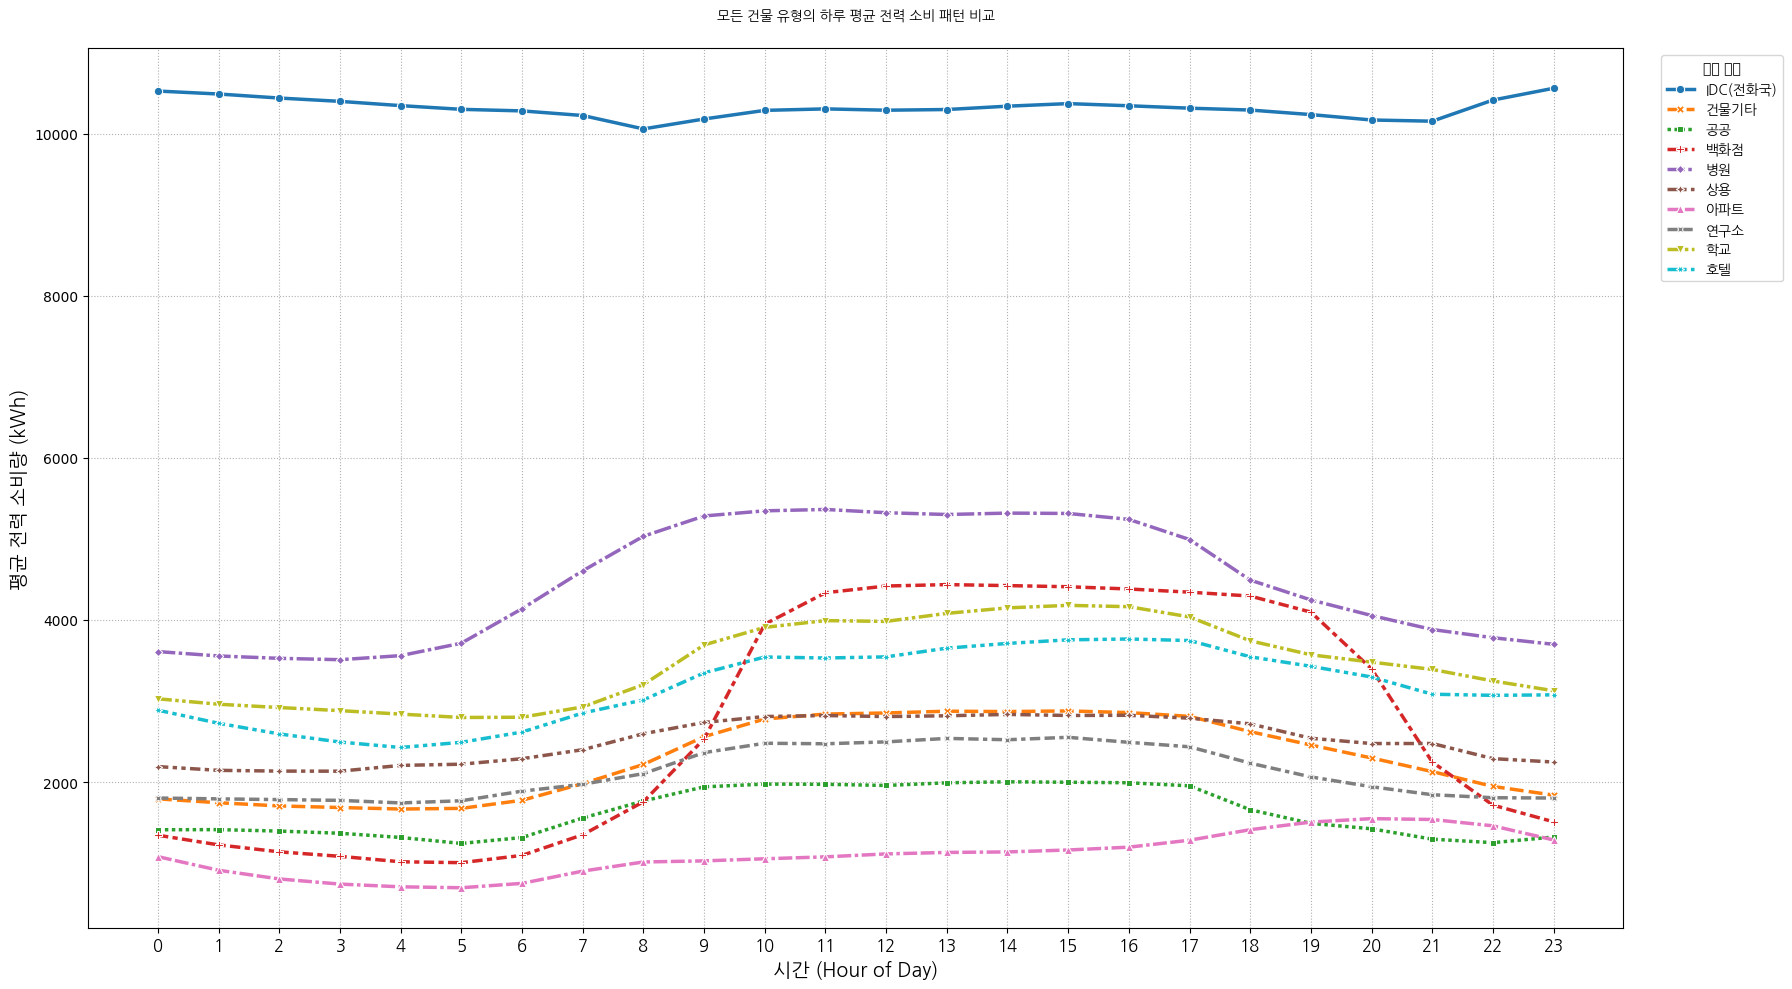


시각화가 완료되었습니다.


In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import urllib.request
from matplotlib import font_manager

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 폰트 직접 다운로드 및 경로 지정 ---
font_path = 'NanumGothic.ttf'
if not os.path.exists(font_path):
    print("나눔고딕 폰트를 다운로드합니다...")
    url = 'https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf'
    try:
        urllib.request.urlretrieve(url, font_path)
        print("폰트 다운로드 완료.")
    except Exception as e:
        print(f"폰트 다운로드 중 오류가 발생했습니다: {e}")
        font_path = None
if font_path:
    font_prop = font_manager.FontProperties(fname=font_path)
    print(f"'{font_path}' 폰트를 그래프에 적용합니다.")
else:
    font_prop = None
    print("한글 폰트를 설정할 수 없어, 텍스트가 깨질 수 있습니다.")
plt.rcParams['axes.unicode_minus'] = False


# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")

# --- 2. Data Preparation ---
print("시각화를 위한 데이터를 준비합니다...")
eda_df = pd.merge(train_df, building_info_df, on='건물번호', how='left')

# --- ★★★ 핵심 수정 사항: 모든 건물 유형을 포함하도록 필터링 제거 ★★★ ---
# 이전 코드와 달리, 특정 유형만 선택하지 않고 모든 데이터를 사용합니다.

# 시간 변수 생성
eda_df['일시_dt'] = pd.to_datetime(eda_df['일시'], format='%Y%m%d %H')
eda_df['hour'] = eda_df['일시_dt'].dt.hour

# 건물 유형별, 시간대별 평균 전력 소비량 계산
hourly_patterns = eda_df.groupby(['건물유형', 'hour'])['전력소비량(kWh)'].mean().reset_index()


# --- 3. Visualization: Hourly Consumption Patterns by All Building Types ---
print("모든 건물 유형의 시간대별 평균 전력 소비 패턴을 시각화합니다...")

plt.figure(figsize=(18, 10))

# 꺾은선 그래프 생성
sns.lineplot(
    data=hourly_patterns,
    x='hour',
    y='전력소비량(kWh)',
    hue='건물유형', # 건물 유형에 따라 다른 색상의 선을 그림
    style='건물유형', # 건물 유형에 따라 다른 스타일의 선을 그림
    markers=True,
    linewidth=2.5
)

# 제목 및 라벨 설정
if font_prop:
    plt.title('모든 건물 유형의 하루 평균 전력 소비 패턴 비교', fontsize=22, pad=20, fontproperties=font_prop)
    plt.xlabel('시간 (Hour of Day)', fontsize=14, fontproperties=font_prop)
    plt.ylabel('평균 전력 소비량 (kWh)', fontsize=14, fontproperties=font_prop)
    plt.xticks(np.arange(0, 24, 1), fontproperties=font_prop, fontsize=12)
    # 범례가 그래프를 가리지 않도록 바깥쪽에 배치합니다.
    plt.legend(title='건물 유형', prop=font_prop, fontsize=12, bbox_to_anchor=(1.02, 1), loc='upper left')
else:
    plt.title('Avg. Hourly Power Consumption Pattern Across All Building Types', fontsize=22, pad=20)
    plt.xlabel('Hour of Day', fontsize=14)
    plt.ylabel('Average Power Consumption (kWh)', fontsize=14)
    plt.xticks(np.arange(0, 24, 1), fontsize=12)
    plt.legend(title='Building Type', fontsize=12, bbox_to_anchor=(1.02, 1), loc='upper left')

plt.grid(True, linestyle=':')
plt.tight_layout() # 범례가 잘리지 않도록 레이아웃 조정
plt.show()

print("\n시각화가 완료되었습니다.")


'NanumGothic.ttf' 폰트를 그래프에 적용합니다.
데이터를 불러오는 중입니다...
데이터 로딩 완료.
시각화를 위한 데이터를 준비합니다...
전체 평균 전력 소비량의 자기상관함수(ACF)를 시각화합니다...


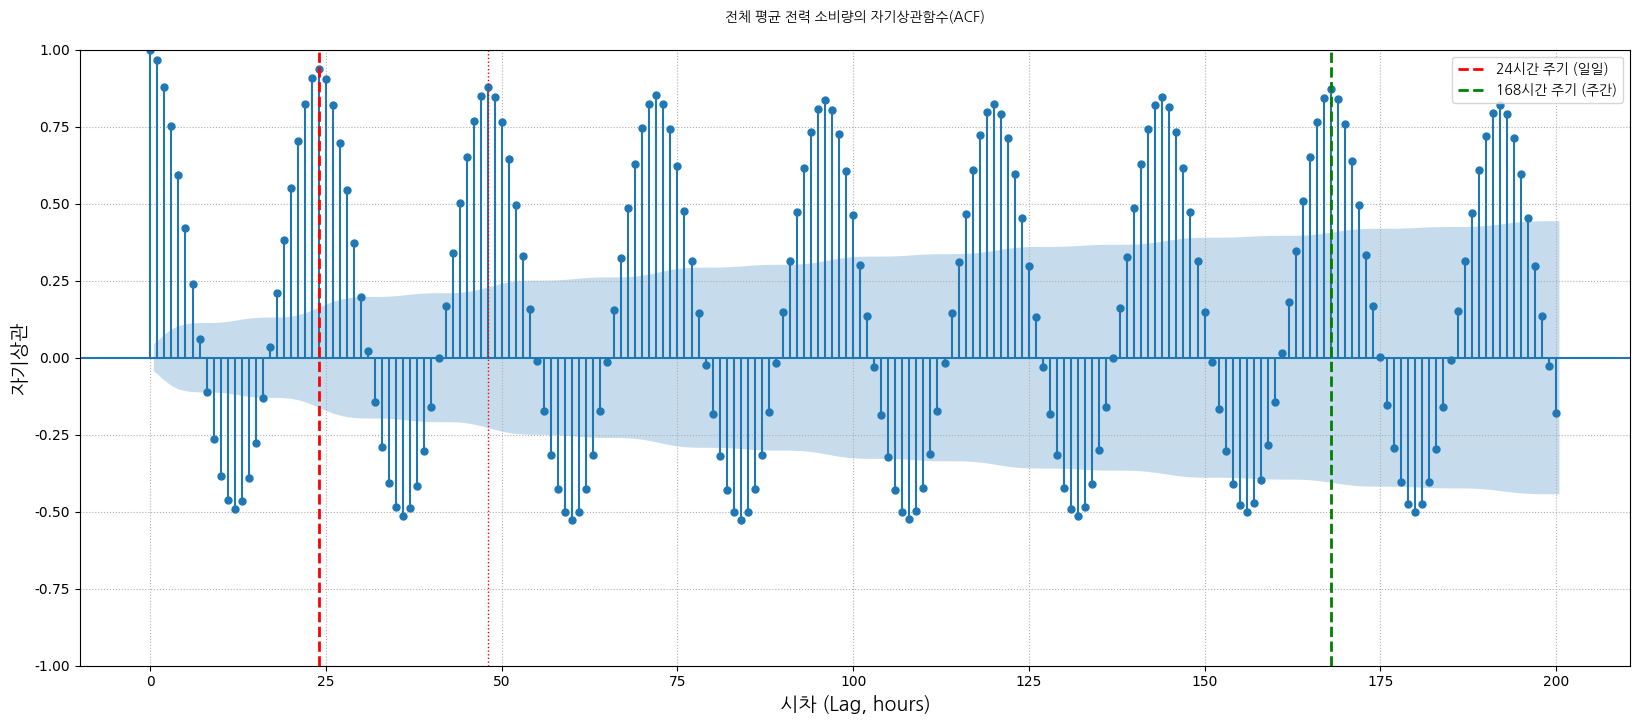


시각화가 완료되었습니다.

[그래프 해석]
파란색 음영 영역을 벗어나는 막대는 통계적으로 유의미한 상관관계가 있음을 나타냅니다.
Lag 24, 48, 72... 등 24의 배수 지점에서 높은 상관관계를 보이는 것은 강력한 '일일 주기성'의 증거입니다.
Lag 168 지점에서도 높은 상관관계를 보이는 것은 '주간 주기성'이 존재함을 의미합니다.


In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import urllib.request
from matplotlib import font_manager
# --- ★★★ 핵심 수정 사항 1: ACF 플롯을 위한 라이브러리 추가 ★★★ ---
from statsmodels.graphics.tsaplots import plot_acf

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 폰트 직접 다운로드 및 경로 지정 ---
font_path = 'NanumGothic.ttf'
if not os.path.exists(font_path):
    print("나눔고딕 폰트를 다운로드합니다...")
    url = 'https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf'
    try:
        urllib.request.urlretrieve(url, font_path)
        print("폰트 다운로드 완료.")
    except Exception as e:
        print(f"폰트 다운로드 중 오류가 발생했습니다: {e}")
        font_path = None
if font_path:
    font_prop = font_manager.FontProperties(fname=font_path)
    print(f"'{font_path}' 폰트를 그래프에 적용합니다.")
else:
    font_prop = None
    print("한글 폰트를 설정할 수 없어, 텍스트가 깨질 수 있습니다.")
plt.rcParams['axes.unicode_minus'] = False


# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")

# --- 2. Data Preparation ---
print("시각화를 위한 데이터를 준비합니다...")
eda_df = train_df.copy()

# '일시' 컬럼을 datetime 객체로 변환
eda_df['일시'] = pd.to_datetime(eda_df['일시'], format='%Y%m%d %H')

# 전체 건물의 시간대별 평균 계산
overall_mean_power = eda_df.groupby('일시')['전력소비량(kWh)'].mean()


# --- ★★★ 핵심 수정 사항 2: 자기상관함수(ACF) 그래프 생성 ★★★ ---
print("전체 평균 전력 소비량의 자기상관함수(ACF)를 시각화합니다...")

fig, ax = plt.subplots(figsize=(20, 8))

# ACF를 계산하고 시각화합니다. (최대 200시간 전까지의 상관관계 확인)
plot_acf(overall_mean_power, ax=ax, lags=200)

# 주요 주기성 지점을 시각적으로 강조
plt.axvline(x=24, color='red', linestyle='--', linewidth=2, label='24시간 주기 (일일)')
plt.axvline(x=48, color='red', linestyle=':', linewidth=1)
plt.axvline(x=168, color='green', linestyle='--', linewidth=2, label='168시간 주기 (주간)')

# 제목 및 라벨 설정
if font_prop:
    plt.title('전체 평균 전력 소비량의 자기상관함수(ACF)', fontsize=22, pad=20, fontproperties=font_prop)
    plt.xlabel('시차 (Lag, hours)', fontsize=14, fontproperties=font_prop)
    plt.ylabel('자기상관', fontsize=14, fontproperties=font_prop)
    plt.legend(prop=font_prop, fontsize=12)
else:
    plt.title('Autocorrelation Function (ACF) of Overall Average Power Consumption', fontsize=22, pad=20)
    plt.xlabel('Lag (hours)', fontsize=14)
    plt.ylabel('Autocorrelation', fontsize=14)
    plt.legend(fontsize=12)

plt.grid(True, linestyle=':')
plt.show()

print("\n시각화가 완료되었습니다.")
print("\n[그래프 해석]")
print("파란색 음영 영역을 벗어나는 막대는 통계적으로 유의미한 상관관계가 있음을 나타냅니다.")
print("Lag 24, 48, 72... 등 24의 배수 지점에서 높은 상관관계를 보이는 것은 강력한 '일일 주기성'의 증거입니다.")
print("Lag 168 지점에서도 높은 상관관계를 보이는 것은 '주간 주기성'이 존재함을 의미합니다.")



'NanumGothic.ttf' 폰트를 그래프에 적용합니다.
데이터를 불러오는 중입니다...
데이터 로딩 완료.
시각화를 위한 데이터를 준비합니다...
이동평균 모형의 '노이즈 제거 및 추세 파악' 효과를 시각화합니다...


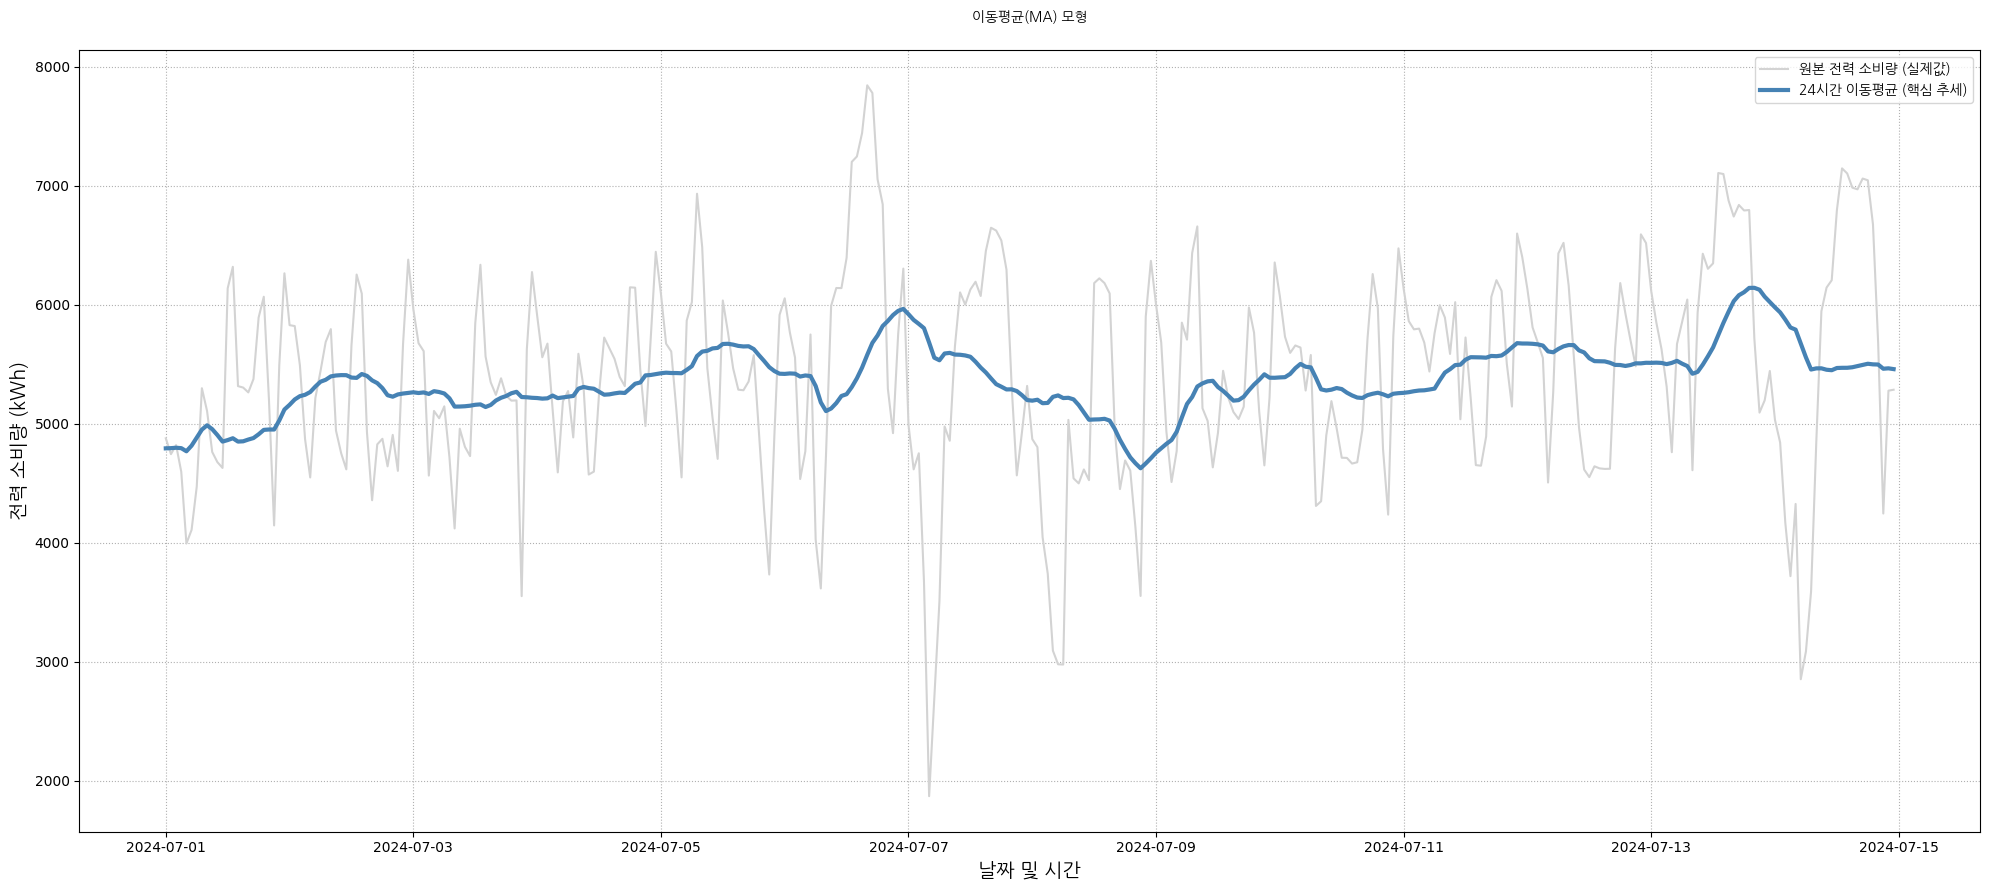

시각화가 완료되었습니다.


In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import urllib.request
from matplotlib import font_manager

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 폰트 직접 다운로드 및 경로 지정 ---
font_path = 'NanumGothic.ttf'
if not os.path.exists(font_path):
    print("나눔고딕 폰트를 다운로드합니다...")
    url = 'https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf'
    try:
        urllib.request.urlretrieve(url, font_path)
        print("폰트 다운로드 완료.")
    except Exception as e:
        print(f"폰트 다운로드 중 오류가 발생했습니다: {e}")
        font_path = None
if font_path:
    font_prop = font_manager.FontProperties(fname=font_path)
    print(f"'{font_path}' 폰트를 그래프에 적용합니다.")
else:
    font_prop = None
    print("한글 폰트를 설정할 수 없어, 텍스트가 깨질 수 있습니다.")
plt.rcParams['axes.unicode_minus'] = False


# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")

# --- 2. Data Preparation ---
print("시각화를 위한 데이터를 준비합니다...")
# 대표 건물 선택 (예: 1번 건물)
building_num_to_analyze = 1
eda_df = train_df[train_df['건물번호'] == building_num_to_analyze].copy()
eda_df['일시'] = pd.to_datetime(eda_df['일시'], format='%Y%m%d %H')
eda_df = eda_df.set_index('일시')

# --- ★★★ 핵심 1: 24시간 이동평균 계산 ★★★ ---
eda_df['MA_24h'] = eda_df['전력소비량(kWh)'].rolling(window=24).mean()

# 분석을 위해 특정 기간만 선택 (예: 2주)
eda_df_sample = eda_df['2024-07-01':'2024-07-14']


# --- 3. Visualization: "노이즈 제거" 효과 시각화 ---
print("이동평균 모형의 '노이즈 제거 및 추세 파악' 효과를 시각화합니다...")

plt.figure(figsize=(20, 9))

# 1. 원본 시계열 데이터
plt.plot(eda_df_sample.index, eda_df_sample['전력소비량(kWh)'], color='lightgray', linewidth=1.5, label='원본 전력 소비량 (실제값)')

# 2. 24시간 이동평균 추세선
plt.plot(eda_df_sample.index, eda_df_sample['MA_24h'], color='steelblue', linewidth=3, label='24시간 이동평균 (핵심 추세)')

# 제목 및 라벨, 범례 설정
if font_prop:
    plt.title(f'이동평균(MA) 모형', fontsize=22, pad=20, fontproperties=font_prop)
    plt.xlabel('날짜 및 시간', fontsize=14, fontproperties=font_prop)
    plt.ylabel('전력 소비량 (kWh)', fontsize=14, fontproperties=font_prop)
    plt.legend(prop=font_prop, fontsize=12, loc='upper right')

    # 그래프에 해석을 돕는 텍스트 추가

else:
    plt.title(f'Effect of Moving Average: Smoothing Noise & Identifying Trend (Building #{building_num_to_analyze})', fontsize=22, pad=20)
    plt.xlabel('Date and Time', fontsize=14)
    plt.ylabel('Power Consumption (kWh)', fontsize=14)
    plt.legend(fontsize=12, loc='upper right')

plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

print("시각화가 완료되었습니다.")


'NanumGothic.ttf' 폰트를 그래프에 적용합니다.
데이터를 불러오는 중입니다...
데이터 로딩 완료.
시각화를 위한 데이터를 준비합니다...
이동평균 모형의 '변동성 감소' 효과를 시각화합니다...


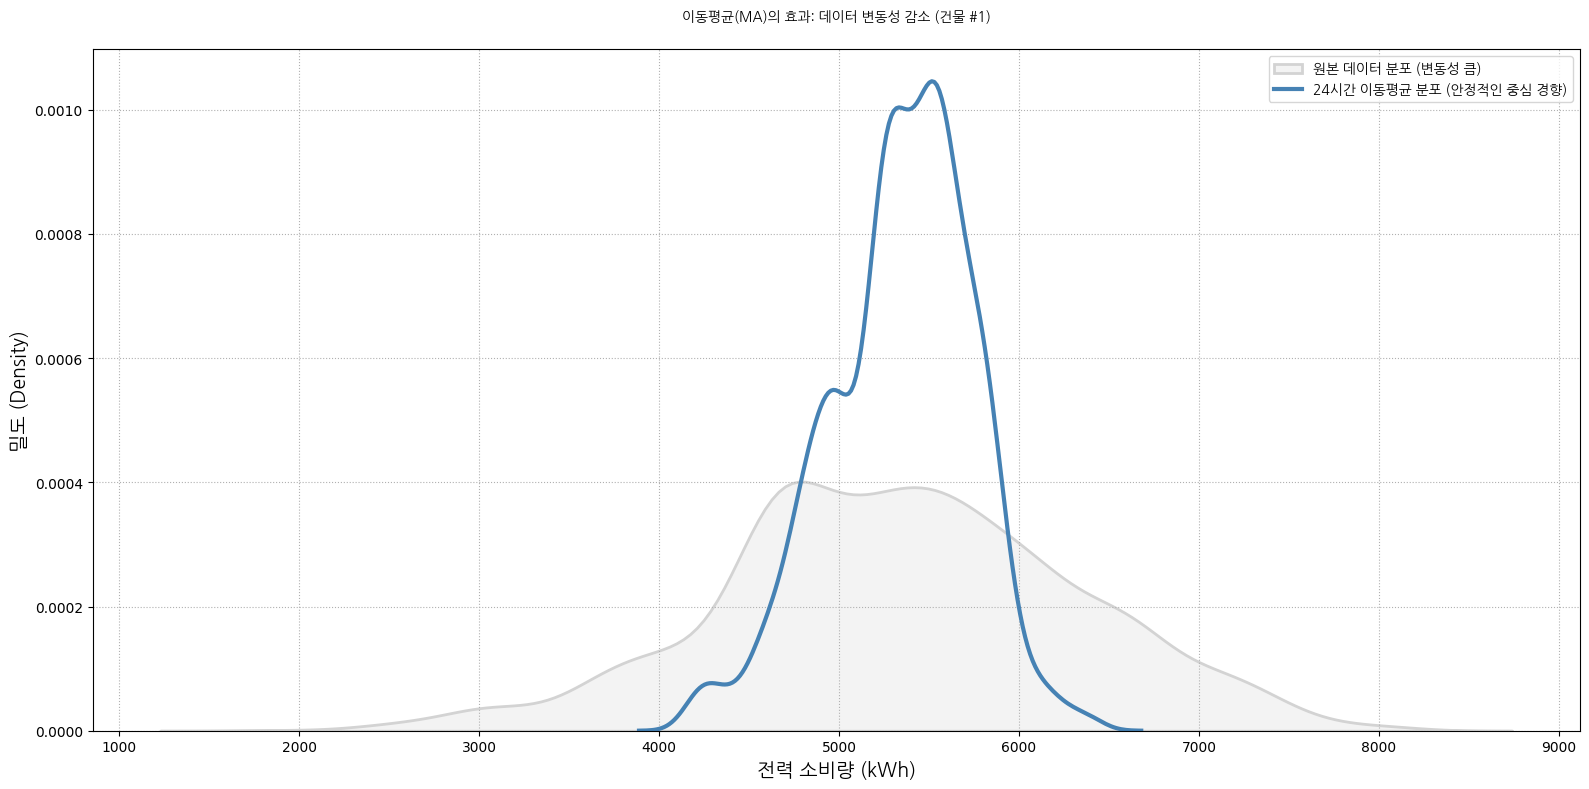

시각화가 완료되었습니다.


In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import urllib.request
from matplotlib import font_manager

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 폰트 직접 다운로드 및 경로 지정 ---
font_path = 'NanumGothic.ttf'
if not os.path.exists(font_path):
    print("나눔고딕 폰트를 다운로드합니다...")
    url = 'https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf'
    try:
        urllib.request.urlretrieve(url, font_path)
        print("폰트 다운로드 완료.")
    except Exception as e:
        print(f"폰트 다운로드 중 오류가 발생했습니다: {e}")
        font_path = None
if font_path:
    font_prop = font_manager.FontProperties(fname=font_path)
    print(f"'{font_path}' 폰트를 그래프에 적용합니다.")
else:
    font_prop = None
    print("한글 폰트를 설정할 수 없어, 텍스트가 깨질 수 있습니다.")
plt.rcParams['axes.unicode_minus'] = False


# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")

# --- 2. Data Preparation ---
print("시각화를 위한 데이터를 준비합니다...")
# 대표 건물 선택 (예: 1번 건물)
building_num_to_analyze = 1
eda_df = train_df[train_df['건물번호'] == building_num_to_analyze].copy()
eda_df['일시'] = pd.to_datetime(eda_df['일시'], format='%Y%m%d %H')
eda_df = eda_df.set_index('일시')

# --- ★★★ 핵심 1: 24시간 이동평균 계산 ★★★ ---
eda_df['MA_24h'] = eda_df['전력소비량(kWh)'].rolling(window=24).mean()


# --- 3. Visualization: "변동성 감소" 효과 시각화 (밀도 그림) ---
print("이동평균 모형의 '변동성 감소' 효과를 시각화합니다...")

plt.figure(figsize=(16, 8))

# 1. 원본 데이터의 분포 (Density Plot)
sns.kdeplot(data=eda_df['전력소비량(kWh)'], color='lightgray', fill=True, linewidth=2, label='원본 데이터 분포 (변동성 큼)')

# 2. 24시간 이동평균 데이터의 분포
sns.kdeplot(data=eda_df['MA_24h'].dropna(), color='steelblue', linewidth=3, label='24시간 이동평균 분포 (안정적인 중심 경향)')

# 제목 및 라벨, 범례 설정
if font_prop:
    plt.title(f'이동평균(MA)의 효과: 데이터 변동성 감소 (건물 #{building_num_to_analyze})', fontsize=22, pad=20, fontproperties=font_prop)
    plt.xlabel('전력 소비량 (kWh)', fontsize=14, fontproperties=font_prop)
    plt.ylabel('밀도 (Density)', fontsize=14, fontproperties=font_prop)
    plt.legend(prop=font_prop, fontsize=12, loc='upper right')

else:
    plt.title(f'Effect of Moving Average: Reduction in Data Volatility (Building #{building_num_to_analyze})', fontsize=22, pad=20)
    plt.xlabel('Power Consumption (kWh)', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend(fontsize=12, loc='upper right')

plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

print("시각화가 완료되었습니다.")



In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- SMAPE 계산 함수 정의 ---
def smape(actual, forecast):
    epsilon = 1e-10
    return np.mean(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast) + epsilon)) * 100


# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    train_df = pd.read_csv('train.csv', encoding='utf-8')
    test_df = pd.read_csv('test.csv', encoding='utf-8')
    building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')
    # --- ★★★ 핵심 수정 사항 1: 최종 제출 파일을 미리 한번만 불러오기 ★★★ ---
    final_submission = pd.read_csv('sample_submission.csv')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")


# --- 2. K-Means Clustering for Building Grouping (K=4) ---
print("\nK-Means 클러스터링으로 건물 그룹을 생성합니다 (K=4)...")
cluster_df = train_df.copy()
cluster_df['일시_dt'] = pd.to_datetime(cluster_df['일시'], format='%Y%m%d %H')
cluster_df['hour'] = cluster_df['일시_dt'].dt.hour
cluster_df['weekday'] = cluster_df['일시_dt'].dt.weekday
hourly_profile = cluster_df.groupby(['건물번호', 'hour'])['전력소비량(kWh)'].mean().unstack().fillna(0)
weekday_profile = cluster_df.groupby(['건물번호', 'weekday'])['전력소비량(kWh)'].mean().unstack().fillna(0)
building_profiles = pd.concat([hourly_profile, weekday_profile], axis=1)
scaler = StandardScaler()
scaled_profiles = scaler.fit_transform(building_profiles)
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
building_info_df['cluster'] = kmeans.fit_predict(scaled_profiles)
print("건물 그룹핑 완료.")


# --- 3. Feature Engineering & Preprocessing ---
print("\nFeature Engineering을 시작합니다...")

# 이상치 처리
train_df['일시_dt_temp'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')
train_df['hour_temp'] = train_df['일시_dt_temp'].dt.hour
train_df['weekday_temp'] = train_df['일시_dt_temp'].dt.weekday
for building_num in train_df['건물번호'].unique():
    building_mask = train_df['건물번호'] == building_num
    power_series = train_df.loc[building_mask, '전력소비량(kWh)']
    Q1, Q3 = power_series.quantile(0.25), power_series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    outlier_indices = power_series[(power_series < lower_bound) | (power_series > upper_bound)].index
    if not outlier_indices.empty:
        non_outlier_mask = building_mask & ~train_df.index.isin(outlier_indices)
        replacement_map = train_df.loc[non_outlier_mask].groupby(['weekday_temp', 'hour_temp'])['전력소비량(kWh)'].mean()
        for idx in outlier_indices:
            weekday, hour = train_df.loc[idx, 'weekday_temp'], train_df.loc[idx, 'hour_temp']
            replacement_value = replacement_map.get((weekday, hour), power_series.median())
            train_df.loc[idx, '전력소비량(kWh)'] = replacement_value
train_df = train_df.drop(columns=['일시_dt_temp', 'hour_temp', 'weekday_temp'])

# Combine train and test for consistent feature creation
test_df['전력소비량(kWh)'] = np.nan
all_df = pd.concat([train_df, test_df], ignore_index=True)

# Merge building info
all_df = pd.merge(all_df, building_info_df, on='건물번호', how='left')

# 파생변수 생성
holidays = ['2024-06-06', '2024-08-15', '2025-06-06', '2025-08-15']
all_df['일시_dt'] = pd.to_datetime(all_df['일시'], format='%Y%m%d %H')
all_df['주말여부'] = all_df['일시_dt'].dt.weekday.isin([5, 6]).astype(int)
all_df['is_holiday'] = all_df['일시_dt'].dt.date.astype(str).isin(holidays).astype(int)
best_bp = 24
all_df['냉방도일'] = (all_df['기온(°C)'] > best_bp) * (all_df['기온(°C)'] - best_bp)
all_df['hour'] = all_df['일시_dt'].dt.hour
all_df['weekday'] = all_df['일시_dt'].dt.weekday
all_df['month'] = all_df['일시_dt'].dt.month
all_df['day'] = all_df['일시_dt'].dt.day

# 주기성: 삼각함수 + 이동평균
all_df['hour_sin'] = np.sin(2 * np.pi * all_df['hour'] / 24)
all_df['hour_cos'] = np.cos(2 * np.pi * all_df['hour'] / 24)
all_df['weekday_sin'] = np.sin(2 * np.pi * all_df['weekday'] / 7)
all_df['weekday_cos'] = np.cos(2 * np.pi * all_df['weekday'] / 7)
all_df = all_df.sort_values(by=['건물번호', '일시'])
all_df['MA_24h'] = all_df.groupby('건물번호')['전력소비량(kWh)'].shift(1).rolling(window=24).mean()
all_df['MA_168h'] = all_df.groupby('건물번호')['전력소비량(kWh)'].shift(1).rolling(window=168).mean()

# K-Means 클러스터 라벨을 변수로 사용
all_df = pd.get_dummies(all_df, columns=['cluster'], prefix='cluster')

# 오차 분석 기반 변수 추가
all_df['lag_1h'] = all_df.groupby('건물번호')['전력소비량(kWh)'].shift(1)
all_df['lag_3h'] = all_df.groupby('건물번호')['전력소비량(kWh)'].shift(3)
all_df_temp = pd.get_dummies(all_df, columns=['건물유형'], prefix='b_type')
b_type_cols = [col for col in all_df_temp.columns if 'b_type_' in col]
for b_type in b_type_cols:
    all_df_temp[f'temp_x_{b_type}'] = all_df_temp['기온(°C)'] * all_df_temp[b_type]
all_df = all_df_temp

# 최종 데이터셋 준비
all_df.fillna(method='bfill', inplace=True)
all_df = all_df.drop(columns=['일시_dt', 'hour', 'weekday'])
train_processed_df = all_df[all_df['전력소비량(kWh)'].notna()].copy()
test_processed_df = all_df[all_df['전력소비량(kWh)'].isna()].drop(columns=['전력소비량(kWh)'])

train_final_df = train_processed_df
test_final_df = test_processed_df
for df in [train_final_df, test_final_df]:
    for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
        if col in df.columns:
             df[col] = df[col].replace('-', 0).astype(float).fillna(0)

target = '전력소비량(kWh)'
train_cols = [col for col in train_final_df.columns if col != target]
test_final_df = test_final_df.reindex(columns=train_cols, fill_value=0)
initial_features = [col for col in train_cols if col not in ['num_date_time', '일시']]
print("Feature Engineering 완료.")


# --- 4. 순열 중요도 기반 특성 선택 및 최적 개수 탐색 ---
print("\n--- 특성 선택(Feature Selection)을 시작합니다 (순열 중요도 방식) ---")
X_fs = train_final_df[initial_features]
y_fs = train_final_df[target]
X_train_fs, X_val_fs, y_train_fs, y_val_fs = train_test_split(X_fs, y_fs, test_size=0.2, random_state=42)
perm_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42, n_jobs=-1)
perm_model.fit(X_train_fs, y_train_fs)
result = permutation_importance(perm_model, X_val_fs, y_val_fs, n_repeats=5, random_state=42, n_jobs=-1)
perm_importances = pd.DataFrame({'feature': initial_features, 'importance_mean': result.importances_mean})
perm_importances = perm_importances.sort_values(by='importance_mean', ascending=False)
ranked_features = perm_importances[perm_importances['importance_mean'] > 0]['feature'].tolist()
performance_results = []
num_features_to_test = list(range(10, len(ranked_features) + 1, 10))
if len(ranked_features) not in num_features_to_test:
    num_features_to_test.append(len(ranked_features))
for k in num_features_to_test:
    top_k_features = ranked_features[:k]
    temp_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42, n_jobs=-1)
    temp_model.fit(X_train_fs[top_k_features], y_train_fs)
    y_pred_k = temp_model.predict(X_val_fs[top_k_features])
    rmse_k = np.sqrt(mean_squared_error(y_val_fs, y_pred_k))
    performance_results.append({'num_features': k, 'rmse': rmse_k})
performance_df = pd.DataFrame(performance_results)
best_performance = performance_df.loc[performance_df['rmse'].idxmin()]
optimal_k = int(best_performance['num_features'])
selected_features = ranked_features[:optimal_k]
print(f"\n  >> 최적의 변수 개수는 {optimal_k}개로 확인되었습니다.")


# --- 5. Model Evaluation & Prediction (선택된 변수 사용) ---
evaluation_results = []
print("\n각 건물별 모델 학습, 평가 및 예측을 시작합니다...")

for building_num in range(1, 101):
    train_building = train_final_df[train_final_df['건물번호'] == building_num]
    test_building = test_final_df[test_final_df['건물번호'] == building_num]

    X = train_building[selected_features]
    y = train_building[target]
    X_test = test_building[selected_features]

    # Part 1: Model Evaluation
    X_train_split, X_val, y_train_split, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    eval_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, early_stopping_rounds=50)
    eval_model.fit(X_train_split, y_train_split, eval_set=[(X_val, y_val)], verbose=False)
    y_pred = eval_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    smape_score = smape(y_val, y_pred)
    evaluation_results.append({'건물번호': building_num, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'SMAPE': smape_score})

    # Part 2: Final Prediction for Submission
    final_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
    final_model.fit(X, y)
    final_preds = final_model.predict(X_test)

    # --- ★★★ 핵심 수정 사항 2: .isin()을 사용한 가장 안정적인 값 할당 ★★★ ---
    # 현재 건물의 test 데이터에 해당하는 num_date_time 목록을 가져옵니다.
    target_ids = test_building['num_date_time']
    # submission 파일에서 이 목록에 포함된 행을 정확히 찾아 예측값을 할당합니다.
    final_submission.loc[final_submission['num_date_time'].isin(target_ids), 'answer'] = final_preds

    if building_num % 10 == 0:
        print(f"  ... {building_num}번 건물 처리 완료.")

# --- 6. Evaluation Result Display & Submission File Creation ---
print("\n--- 모델 성능 평가 결과 (최종 최적화 적용 후) ---")
results_df = pd.DataFrame(evaluation_results)
average_performance = results_df.drop(columns='건물번호').mean()
print(f"Average RMSE (평균 오차): {average_performance['RMSE']:.3f} kWh")
print(f"Average MAE (평균 절대 오차): {average_performance['MAE']:.3f} kWh")
print(f"Average R2 Score (모델 설명력): {average_performance['R2']:.3f}")
print(f"Average SMAPE (평균 백분율 오차): {average_performance['SMAPE']:.3f} %")


# --- ★★★ 핵심 수정 사항 3: 최종 제출 파일 생성 ★★★ ---
# 이제 final_submission 데이터프레임에는 모든 예측값이 채워져 있습니다.
# 혹시 모를 결측치가 있는지 확인하고 채워줍니다.
nan_count = final_submission['answer'].isna().sum()
if nan_count > 0:
    print(f"\n[경고] 제출 파일 생성 후 {nan_count}개의 예측값이 누락(NaN)되었습니다.")
    final_submission['answer'].fillna(0, inplace=True)
else:
    print("\n[성공] 모든 예측값이 제출 파일에 성공적으로 입력되었습니다.")

final_submission.to_csv('submission_final_fixed.csv', index=False)
print("\n제출 파일 'submission_final_fixed.csv'이(가) 성공적으로 생성되었습니다!")



데이터를 불러오는 중입니다...
데이터 로딩 완료.

K-Means 클러스터링으로 건물 그룹을 생성합니다 (K=4)...
건물 그룹핑 완료.

Feature Engineering을 시작합니다...
Feature Engineering 완료.

--- 특성 선택(Feature Selection)을 시작합니다 (순열 중요도 방식) ---

  >> 최적의 변수 개수는 20개로 확인되었습니다.

각 건물별 모델 학습, 평가 및 예측을 시작합니다...
  ... 10번 건물 처리 완료.
  ... 20번 건물 처리 완료.
  ... 30번 건물 처리 완료.
  ... 40번 건물 처리 완료.
  ... 50번 건물 처리 완료.
  ... 60번 건물 처리 완료.
  ... 70번 건물 처리 완료.
  ... 80번 건물 처리 완료.
  ... 90번 건물 처리 완료.
  ... 100번 건물 처리 완료.

--- 모델 성능 평가 결과 (최종 최적화 적용 후) ---
Average RMSE (평균 오차): 111.437 kWh
Average MAE (평균 절대 오차): 65.406 kWh
Average R2 Score (모델 설명력): 0.982
Average SMAPE (평균 백분율 오차): 2.999 %

[성공] 모든 예측값이 제출 파일에 성공적으로 입력되었습니다.

제출 파일 'submission_final_fixed.csv'이(가) 성공적으로 생성되었습니다!


In [ ]:
# 1. Import Libraries
import pandas as pd
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Data Loading ---
print("데이터를 불러오는 중입니다...")
try:
    # train.csv 파일만 필요합니다.
    train_df = pd.read_csv('train.csv', encoding='utf-8')
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 스크립트와 같은 디렉토리에 파일이 있는지 확인해주세요.")
    exit()
print("데이터 로딩 완료.")


# --- 2. Extract Data with Zero Humidity ---
print("\n'습도(%)'가 0인 데이터를 추출합니다...")

# '습도(%)' 컬럼의 값이 정확히 0인 모든 행을 필터링합니다.
zero_humidity_df = train_df[train_df['습도(%)'] == 0].copy()


# --- 3. Display Results ---
if not zero_humidity_df.empty:
    print(f"\n총 {len(zero_humidity_df)}개의 '습도 0' 데이터를 발견했습니다.")
    print("--- 추출된 데이터 (상위 20개) ---")

    # 더 많은 정보를 보기 위해 '일시'를 datetime으로 변환하여 요일과 시간을 추가합니다.
    zero_humidity_df['일시_dt'] = pd.to_datetime(zero_humidity_df['일시'], format='%Y%m%d %H')
    zero_humidity_df['요일'] = zero_humidity_df['일시_dt'].dt.day_name()
    zero_humidity_df['시간'] = zero_humidity_df['일시_dt'].dt.hour

    # 주요 컬럼만 선택하여 출력
    display_cols = ['건물번호', '일시', '요일', '시간', '기온(°C)', '강수량(mm)', '습도(%)', '전력소비량(kWh)']
    print(zero_humidity_df[display_cols].head(20).to_string())

    print("\n\n--- '습도 0' 데이터 요약 ---")
    print("어떤 건물, 어떤 시간대에 주로 발생하는지 확인해볼 수 있습니다.")
    print("\n[건물번호별 발생 빈도]")
    print(zero_humidity_df['건물번호'].value_counts().head())
    print("\n[시간대별 발생 빈도]")
    print(zero_humidity_df['시간'].value_counts().sort_index())

else:
    print("\n'습도(%)'가 0인 데이터는 발견되지 않았습니다.")


데이터를 불러오는 중입니다...
데이터 로딩 완료.

'습도(%)'가 0인 데이터를 추출합니다...

총 49개의 '습도 0' 데이터를 발견했습니다.
--- 추출된 데이터 (상위 20개) ---
        건물번호           일시         요일  시간  기온(°C)  강수량(mm)  습도(%)  전력소비량(kWh)
115801    57  20240805 01     Monday   1    27.5      0.6    0.0    20602.26
115802    57  20240805 02     Monday   2    27.3      0.0    0.0    20520.06
115803    57  20240805 03     Monday   3    26.9      0.0    0.0    20394.06
115804    57  20240805 04     Monday   4    26.6      0.0    0.0    20238.00
115805    57  20240805 05     Monday   5    26.4      0.0    0.0    20124.54
115806    57  20240805 06     Monday   6    26.4      0.0    0.0    19721.58
115810    57  20240805 10     Monday  10    29.8      0.0    0.0    17445.18
115811    57  20240805 11     Monday  11    31.0      0.0    0.0    17624.70
115812    57  20240805 12     Monday  12    31.9      0.0    0.0    17572.74
115813    57  20240805 13     Monday  13    33.2      0.0    0.0    17576.64
115814    57  20240805 14     Monday  14    